In [244]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from torchvision.models import vgg16
import os
from PIL import Image
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [245]:
# from skmultilearn.model_selection import iterative_train_test_split
# t_train, y_train, t_test, y_test = iterative_train_test_split(X, y, test_size = 0.2)

In [246]:
# Dataset Load and split

# 96 eyes, 49 OCT images, 2 visits, 16 biomarkers (binary)
# 96 eyes, 49 OCT images, 2 visits, 496 x 504 OCT images (grayscale)
scan_N = 9408
oct_N = 49
eye_N = 96
sh = [496, 504]

# csv_file = '~/scratch/OLIVES/OLIVES/Biomarker_Clinical_Data_Images_Updated.csv'
csv_file = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES/Biomarker_Clinical_Data_Images.csv'
data = pd.read_csv(csv_file)
col_names = data.columns
file_paths = data['Path (Trial/Arm/Folder/Visit/Eye/Image Name)'].values #[9408,]
file_paths = file_paths.reshape([eye_N,2*oct_N])
bio_markers = data[col_names[2:18]].values
bio_markers = bio_markers.reshape([eye_N,2*oct_N,-1])

clin_data = data[col_names[19:21]].values
clin_data = clin_data.reshape([eye_N,2*oct_N,-1])

home_dir = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'



In [247]:
# Check for rows with Nan and identify the rows (get rid of them after Data split)
rows_with_nan = data[data.isna().any(axis=1)]
# data = data.dropna()

In [248]:

########## Preprocessing ###########################
model_name = 'vgg16'
input_dim = 224 # Input size for VGG16
transform_vgg = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.CenterCrop(496),
    transforms.Resize((224,224)),                # 224x224 or 384x384
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize with ImageNet stats
        std=[0.229, 0.224, 0.225])
])

#####################################################

class OCTDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        # Dynamically replace 'TREX DME' with 'TREX_DME' in the file path
        corrected_path = self.file_paths[index][0].replace('TREX DME', 'TREX_DME')
        img = Image.open(home_dir + corrected_path).convert("L")
        label = self.labels[index]  # Shape: [sample N, bio_marker_N]
        
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(label, dtype=torch.float32)
        
        return img, label

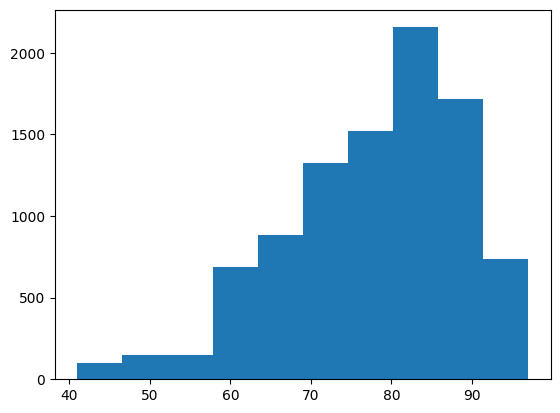

77.71354166666667 10.929043109528417
334.9270833333333 117.8748227987062


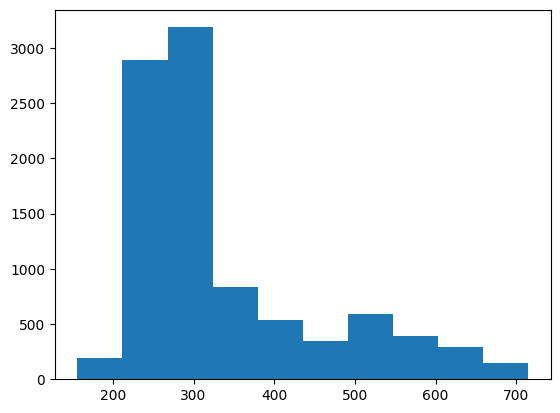

In [249]:
import matplotlib.pyplot as plt
plt.hist(clin_data[:,:,0].flatten())
plt.show()
plt.hist(clin_data[:,:,1].flatten())
zero = clin_data[:,:,0].flatten()
one = clin_data[:,:,1].flatten()
print( np.mean(zero), np.std(zero))
print(np.mean(one), np.std(one))

In [94]:
'''
Data setup - No Stratification (OCT + clinical label)

'''

# Eye-wise split
# Split dataset into train/val/test

# Clinical data (96,98,2)
train_val_files, test_files, train_val_labels, test_labels, train_val_clin, test_clin = train_test_split(
    file_paths, bio_markers, clin_data, test_size=0.2, random_state=42
)

train_files, val_files, train_labels, val_labels, train_clin, val_clin = train_test_split(
    train_val_files, train_val_labels, train_val_clin, test_size=0.25, random_state=42
)
print(train_files.shape, val_files.shape, test_files.shape)
# Eye-wise -> scan-wise
train_files = train_files.reshape([-1,1])
val_files = val_files.reshape([-1,1])
test_files = test_files.reshape([-1,1])

train_labels = train_labels.reshape([-1,16])
val_labels = val_labels.reshape([-1,16])
test_labels = test_labels.reshape([-1,16])

train_clin = train_clin.reshape([-1,2])
val_clin = val_clin.reshape([-1,2])
test_clin = test_clin.reshape([-1,2])

######## Get rid of data points with Nan values #########
train_nan = ~np.isnan(train_labels).any(axis=1)
val_nan = ~np.isnan(val_labels).any(axis=1)
test_nan = ~np.isnan(test_labels).any(axis=1)

train_labels = train_labels[train_nan]
val_labels = val_labels[val_nan]
test_labels = test_labels[test_nan]

train_files = train_files[train_nan]
val_files = val_files[val_nan]
test_files = test_files[test_nan]

train_clin = train_clin[train_nan]
val_clin = val_clin[val_nan]
test_clin = test_clin[test_nan]
#########################################################

train_dataset = OCTDataset(train_files, train_labels, transform=transform_vgg)
val_dataset = OCTDataset(val_files, val_labels, transform=transform_vgg)
test_dataset = OCTDataset(test_files, test_labels, transform=transform_vgg)

# Make DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

(57, 98) (19, 98) (20, 98)


In [95]:
print(np.sum(train_labels, 0),np.sum(val_labels, 0),np.sum(test_labels, 0))

[1.280e+02 3.500e+02 4.000e+00 2.460e+02 3.815e+03 1.627e+03 3.251e+03
 5.300e+02 1.853e+03 7.000e+00 1.849e+03 2.528e+03 1.430e+02 3.000e+00
 1.000e+01 3.500e+01] [1.600e+01 1.050e+02 9.000e+00 6.900e+01 1.102e+03 5.850e+02 1.086e+03
 9.700e+01 6.180e+02 0.000e+00 4.600e+02 6.430e+02 3.700e+01 1.000e+00
 0.000e+00 1.600e+01] [  22.  149.   19.   58. 1421.  772.  879.  180.  365.    3.  694.  916.
   53.    6.    0.   25.]


In [96]:
# Weighted BCE for multi-label imbalanced (pos vs. neg) data

train_pos_weights = torch.tensor(train_labels.shape[0] / (2* np.sum(train_labels,axis=0)))
# val_pos_weights = val_labels.shape[0] / (2* np.sum(val_labels,axis=0))
# test_pos_weights = test_labels.shape[0] / (2* np.sum(test_labels,axis=0))

class WeightedBinaryCrossEntropyLoss(nn.Module):
    def __init__(self, pos_weights):
        """
        pos_weights: Tensor of shape (num_biomarkers,) containing weights for positive labels.
        """
        super(WeightedBinaryCrossEntropyLoss, self).__init__()
        self.pos_weights = pos_weights

    def forward(self, logits, targets):
        """
        logits: Predicted logits from the model, shape (batch_size, num_biomarkers).
        targets: Ground truth binary labels, shape (batch_size, num_biomarkers).
        """
        loss = nn.BCEWithLogitsLoss(reduction='none')(logits, targets)  # Compute BCE loss
        weighted_loss = loss * self.pos_weights  # Apply positive weights
        return weighted_loss.mean()
    


class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        Focal Loss for multi-label classification.

        Parameters:
        - gamma (float): Focusing parameter that reduces the loss for well-classified samples (default: 2.0).
        - alpha (float or Tensor): Balancing factor to address class imbalance (default: None).
          If a tensor is provided, it should be of shape (num_classes,).
        - reduction (str): Specifies the reduction to apply to the output: 'none', 'mean', 'sum' (default: 'mean').
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        Compute Focal Loss.

        Parameters:
        - logits (Tensor): Predicted logits of shape (batch_size, num_classes).
        - targets (Tensor): Ground truth labels of shape (batch_size, num_classes).

        Returns:
        - loss (Tensor): Calculated focal loss.
        """
        # Convert logits to probabilities using sigmoid
        probs = torch.sigmoid(logits)
        
        # Binary cross-entropy loss
        bce_loss = F.binary_cross_entropy(probs, targets, reduction='none')
        
        # Compute the modulating factor (1 - p_t)^gamma
        pt = probs * targets + (1 - probs) * (1 - targets)
        focal_factor = (1 - pt) ** self.gamma

        # Apply class balancing factor alpha if provided
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            elif isinstance(self.alpha, torch.Tensor):
                alpha_factor = self.alpha.unsqueeze(0) * targets + (1 - self.alpha).unsqueeze(0) * (1 - targets)
            else:
                raise ValueError("Alpha must be a float, int, or torch.Tensor.")
            focal_loss = alpha_factor * focal_factor * bce_loss
        else:
            focal_loss = focal_factor * bce_loss

        # Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Initialize Focal Loss (Example)
# 1. gamma (Focusing Parameter):
# Controls the strength of the focusing effect.
# Higher values put more focus on hard-to-classify samples.

# 2. alpha (Class Balancing Factor):
# Helps address class imbalance.
# If alpha is a scalar, it applies the same balancing for all classes.
# If alpha is a tensor, it applies per-class balancing.

# 3. reduction:
# 'mean': Average loss across the batch.
# 'sum': Sum of the loss across the batch.
# 'none': No reduction is applied; returns loss for each sample.

focal_loss = FocalLoss(gamma=2.0, alpha=0.25)

In [250]:
'''
Data setup - No Stratification (OCT only)

'''

# Eye-wise split
# Split dataset into train/val/test
train_val_files, test_files, train_val_labels, test_labels = train_test_split(
    file_paths, bio_markers, test_size=0.2, random_state=42
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_val_files, train_val_labels, test_size=0.25, random_state=42
)
print(train_files.shape, val_files.shape, test_files.shape)
# Eye-wise -> scan-wise
train_files = train_files.reshape([-1,1])
val_files = val_files.reshape([-1,1])
test_files = test_files.reshape([-1,1])

train_labels = train_labels.reshape([-1,16])
val_labels = val_labels.reshape([-1,16])
test_labels = test_labels.reshape([-1,16])

######## Get rid of data points with Nan values #########
train_nan = ~np.isnan(train_labels).any(axis=1)
val_nan = ~np.isnan(val_labels).any(axis=1)
test_nan = ~np.isnan(test_labels).any(axis=1)

train_labels = train_labels[train_nan]
val_labels = val_labels[val_nan]
test_labels = test_labels[test_nan]

train_files = train_files[train_nan]
val_files = val_files[val_nan]
test_files = test_files[test_nan]
#########################################################

train_dataset = OCTDataset(train_files, train_labels, transform=transform_vgg)
val_dataset = OCTDataset(val_files, val_labels, transform=transform_vgg)
test_dataset = OCTDataset(test_files, test_labels, transform=transform_vgg)

# Make DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

(57, 98) (19, 98) (20, 98)


In [251]:
'''
Dataset setup with Stratification (OCT only)
'''

# Eye-wise split
# Split dataset into train/val/test

####### Handle rows with Nan -> mark them with ones(16,) ############
nan_rows = np.isnan(bio_markers).any(axis=2)  # Shape (96, 98), True where NaNs are present
print(np.sum(nan_rows))
# Replace NaN rows ones (checked that no data rows are filled with 1's)
alternating_row = np.ones(16)  
bio_markers[nan_rows] = alternating_row

####### Data stratification based on positive label count per eye #######
pos_count = np.sum(bio_markers,axis=(1,2)) # pos label count per eye
bins = [0,200,300,400,np.inf]
# print(pos_count)
stratify_bins = np.digitize(pos_count, bins)
# print(stratify_bins)
train_val_files, test_files, train_val_labels, test_labels = train_test_split(
    file_paths, bio_markers, test_size=0.2,
    stratify = stratify_bins,
    random_state=42
)

pos_count = np.sum(train_val_labels,axis=(1,2)) # pos label count per eye
bins = [0,200,300,400,np.inf]
stratify_bins = np.digitize(pos_count, bins)
# print(pos_count)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_val_files, train_val_labels, test_size=0.25, 
    stratify = stratify_bins,
    random_state=42
)
print(train_files.shape, val_files.shape, test_files.shape)
##########################################################
# Eye-wise -> scan-wise
train_files = train_files.reshape([-1,1])
val_files = val_files.reshape([-1,1])
test_files = test_files.reshape([-1,1])

train_labels = train_labels.reshape([-1,16])
val_labels = val_labels.reshape([-1,16])
test_labels = test_labels.reshape([-1,16])

############################################
# Get rid of marked Nan rows
train_nan = np.sum(train_labels,axis=1)!=16
val_nan = np.sum(val_labels,axis=1)!=16
test_nan = np.sum(test_labels,axis=1)!=16

train_labels = train_labels[train_nan]
val_labels = val_labels[val_nan]
test_labels = test_labels[test_nan]

train_files = train_files[train_nan]
val_files = val_files[val_nan]
test_files = test_files[test_nan]

########################################################

train_dataset = OCTDataset(train_files, train_labels, transform=transform_vgg)
val_dataset = OCTDataset(val_files, val_labels, transform=transform_vgg)
test_dataset = OCTDataset(test_files, test_labels, transform=transform_vgg)

# Make DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

12
(57, 98) (19, 98) (20, 98)


(array([ 1.,  7.,  7., 10., 11.,  9.,  9., 11.,  7.,  4.]),
 array([ 96. , 131.6, 167.2, 202.8, 238.4, 274. , 309.6, 345.2, 380.8,
        416.4, 452. ]),
 <BarContainer object of 10 artists>)

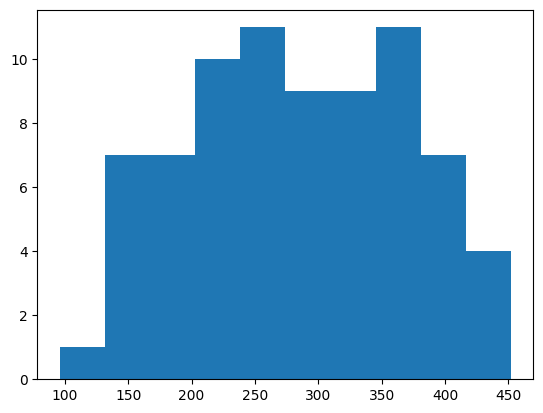

In [252]:
# Check pos_sum distribution for stratification label
import matplotlib.pyplot as plt
plt.hist(np.sum(train_val_labels, axis=(1,2)))

In [253]:
train_files.shape

(5580, 1)

In [254]:
np.argwhere(np.isnan(clin_data))

array([], shape=(0, 3), dtype=int64)

In [255]:
# Quick analysis of biomarker distribution

train_ratio = np.sum(train_labels, axis=(0)) / np.sum(train_labels)
val_ratio = np.sum(val_labels, axis=(0)) / np.sum(val_labels)
test_ratio = np.sum(test_labels, axis=(0)) / np.sum(test_labels)
print(train_ratio/val_ratio)
print(test_ratio/train_ratio)


[2.84166093 0.47015315 3.20810382 0.41405084 0.95131629 0.84717532
 1.31237086 1.13214838 1.40275397 0.         0.91685974 0.88384977
 0.57101645 0.0948208         inf 4.23137832]
[0.2752807  1.11423837 0.         3.03390688 1.15353915 1.06970319
 0.83560094 0.59204797 0.61667378        inf 1.20991035 1.12685867
 1.19016822 1.45051752 0.         1.19454384]


/scratch/999629/ipykernel_2155710/1940320430.py:6: RuntimeWarning: divide by zero encountered in divide
  print(train_ratio/val_ratio)
/scratch/999629/ipykernel_2155710/1940320430.py:7: RuntimeWarning: divide by zero encountered in divide
  print(test_ratio/train_ratio)


In [256]:
# !pip install timm
torch.cuda.is_available()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


True

In [257]:
(2* np.sum(train_labels,axis=0)),(2* np.sum(val_labels,axis=0)),(2* np.sum(test_labels,axis=0))

(array([2.740e+02, 5.780e+02, 5.800e+01, 2.620e+02, 7.258e+03, 3.390e+03,
        6.770e+03, 1.078e+03, 3.914e+03, 0.000e+00, 3.376e+03, 4.634e+03,
        2.340e+02, 4.000e+00, 2.000e+01, 1.020e+02]),
 array([  32.,  408.,    6.,  210., 2532., 1328., 1712.,  316.,  926.,
          14., 1222., 1740.,  136.,   14.,    0.,    8.]),
 array([2.600e+01, 2.220e+02, 0.000e+00, 2.740e+02, 2.886e+03, 1.250e+03,
        1.950e+03, 2.200e+02, 8.320e+02, 6.000e+00, 1.408e+03, 1.800e+03,
        9.600e+01, 2.000e+00, 0.000e+00, 4.200e+01]))

In [258]:
# Weighted BCE for multi-label imbalanced (pos vs. neg) data

train_pos_weights = torch.tensor(train_labels.shape[0] / (2* np.sum(train_labels,axis=0)))
# val_pos_weights = val_labels.shape[0] / (2* np.sum(val_labels,axis=0))
# test_pos_weights = test_labels.shape[0] / (2* np.sum(test_labels,axis=0))

class WeightedBinaryCrossEntropyLoss(nn.Module):
    def __init__(self, pos_weights):
        """
        pos_weights: Tensor of shape (num_biomarkers,) containing weights for positive labels.
        """
        super(WeightedBinaryCrossEntropyLoss, self).__init__()
        self.pos_weights = pos_weights

    def forward(self, logits, targets):
        """
        logits: Predicted logits from the model, shape (batch_size, num_biomarkers).
        targets: Ground truth binary labels, shape (batch_size, num_biomarkers).
        """
        loss = nn.BCEWithLogitsLoss(reduction='none')(logits, targets)  # Compute BCE loss
        weighted_loss = loss * self.pos_weights  # Apply positive weights
        return weighted_loss.mean()
    


class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        Focal Loss for multi-label classification.

        Parameters:
        - gamma (float): Focusing parameter that reduces the loss for well-classified samples (default: 2.0).
        - alpha (float or Tensor): Balancing factor to address class imbalance (default: None).
          If a tensor is provided, it should be of shape (num_classes,).
        - reduction (str): Specifies the reduction to apply to the output: 'none', 'mean', 'sum' (default: 'mean').
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        Compute Focal Loss.

        Parameters:
        - logits (Tensor): Predicted logits of shape (batch_size, num_classes).
        - targets (Tensor): Ground truth labels of shape (batch_size, num_classes).

        Returns:
        - loss (Tensor): Calculated focal loss.
        """
        # Convert logits to probabilities using sigmoid
        probs = torch.sigmoid(logits)
        
        # Binary cross-entropy loss
        bce_loss = F.binary_cross_entropy(probs, targets, reduction='none')
        
        # Compute the modulating factor (1 - p_t)^gamma
        pt = probs * targets + (1 - probs) * (1 - targets)
        focal_factor = (1 - pt) ** self.gamma

        # Apply class balancing factor alpha if provided
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            elif isinstance(self.alpha, torch.Tensor):
                alpha_factor = self.alpha.unsqueeze(0) * targets + (1 - self.alpha).unsqueeze(0) * (1 - targets)
            else:
                raise ValueError("Alpha must be a float, int, or torch.Tensor.")
            focal_loss = alpha_factor * focal_factor * bce_loss
        else:
            focal_loss = focal_factor * bce_loss

        # Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Initialize Focal Loss (Example)
# 1. gamma (Focusing Parameter):
# Controls the strength of the focusing effect.
# Higher values put more focus on hard-to-classify samples.

# 2. alpha (Class Balancing Factor):
# Helps address class imbalance.
# If alpha is a scalar, it applies the same balancing for all classes.
# If alpha is a tensor, it applies per-class balancing.

# 3. reduction:
# 'mean': Average loss across the batch.
# 'sum': Sum of the loss across the batch.
# 'none': No reduction is applied; returns loss for each sample.

focal_loss = FocalLoss(gamma=2.0, alpha=0.25)


/scratch/999629/ipykernel_2155710/3028831730.py:3: RuntimeWarning: divide by zero encountered in divide
  train_pos_weights = torch.tensor(train_labels.shape[0] / (2* np.sum(train_labels,axis=0)))


In [259]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        Focal Loss for multi-label classification.

        Parameters:
        - gamma (float): Focusing parameter that reduces the loss for well-classified samples (default: 2.0).
        - alpha (float or Tensor): Balancing factor to address class imbalance (default: None).
          If a tensor is provided, it should be of shape (num_classes,).
        - reduction (str): Specifies the reduction to apply to the output: 'none', 'mean', 'sum' (default: 'mean').
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        Compute Focal Loss.

        Parameters:
        - logits (Tensor): Predicted logits of shape (batch_size, num_classes).
        - targets (Tensor): Ground truth labels of shape (batch_size, num_classes).

        Returns:
        - loss (Tensor): Calculated focal loss.
        """
        # Convert logits to probabilities using sigmoid
        probs = torch.sigmoid(logits)
        
        # Binary cross-entropy loss
        bce_loss = F.binary_cross_entropy(probs, targets, reduction='none')
        
        # Compute the modulating factor (1 - p_t)^gamma
        pt = probs * targets + (1 - probs) * (1 - targets)
        focal_factor = (1 - pt) ** self.gamma

        # Apply class balancing factor alpha if provided
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            elif isinstance(self.alpha, torch.Tensor):
                alpha_factor = self.alpha.unsqueeze(0) * targets + (1 - self.alpha).unsqueeze(0) * (1 - targets)
            else:
                raise ValueError("Alpha must be a float, int, or torch.Tensor.")
            focal_loss = alpha_factor * focal_factor * bce_loss
        else:
            focal_loss = focal_factor * bce_loss

        # Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Initialize Focal Loss (Example)
# 1. gamma (Focusing Parameter):
# Controls the strength of the focusing effect.
# Higher values put more focus on hard-to-classify samples.

# 2. alpha (Class Balancing Factor):
# Helps address class imbalance.
# If alpha is a scalar, it applies the same balancing for all classes.
# If alpha is a tensor, it applies per-class balancing.

# 3. reduction:
# 'mean': Average loss across the batch.
# 'sum': Sum of the loss across the batch.
# 'none': No reduction is applied; returns loss for each sample.

focal_loss = FocalLoss(gamma=2.0, alpha=0.25)


In [15]:
!pip install timm

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [260]:
import timm 
import tqdm

###### Parameters ######
lr = 1e-3
num_classes = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10

class CustomVGG16(nn.Module):
    def __init__(self, original_model, num_classes):
        super(CustomVGG16, self).__init__()
        self.features = original_model.features  # Feature extraction layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),  # 512*7*7 for VGG16 feature output before classifier
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),  # `num_classes` = 16 for your case
            nn.Sigmoid(),  # Multi-label classification
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the output of the features
        x = self.classifier(x)
        return x


# Create the custom model with `timm`'s VGG16
model = CustomVGG16(timm.create_model('vgg16', pretrained=True), num_classes)



# # Modify the classifier head for multi-class output
model.fc = nn.Sequential(
    nn.Linear(4096, 512),  # Match the expected 4096 input features
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes),  # `num_classes` = 16 for your case
    nn.Sigmoid(),  # Multi-label classification
)

model = model.to('cuda')
    
# Freeze the feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False

# Ensure the classifier parameters are trainable
for param in model.classifier.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
######### Loss ###########
# criterion = torch.nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
# criterion = WeightedBinaryCrossEntropyLoss(train_pos_weights.to('cuda'))
criterion = FocalLoss(gamma=2.0, alpha=0.25)
##########################
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# # Training and validation
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm.tqdm(train_loader):
        images, labels = images.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        print('loss : ',loss.item())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def validate_one_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_outputs = np.zeros([len(val_dataset),num_classes])
    all_labels = np.zeros([len(val_dataset),num_classes])
    i = 0
    with torch.no_grad():
        for images, labels in tqdm.tqdm(val_loader):
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
#             print(i*batch_size, min((i+1)*batch_size,len(val_dataset)))
#             print(outputs.shape)
            all_outputs[i*batch_size: min((i+1)*batch_size,len(val_dataset)),:] = outputs.cpu()
            all_labels[i*batch_size: min((i+1)*batch_size,len(val_dataset)),:] = labels.cpu()
            i+=1

    return running_loss / len(val_loader), all_outputs, all_labels

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_outputs, val_labels = validate_one_epoch(model, val_loader, criterion)
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    scheduler.step()

Epoch 1/10


  1%|          | 1/175 [00:00<01:05,  2.64it/s]

loss :  0.2409725934267044


  1%|          | 2/175 [00:00<01:12,  2.38it/s]

loss :  0.1254015862941742


  2%|▏         | 3/175 [00:01<01:19,  2.17it/s]

loss :  0.1163903996348381


  2%|▏         | 4/175 [00:01<01:20,  2.13it/s]

loss :  0.11465594172477722


  3%|▎         | 5/175 [00:02<01:22,  2.07it/s]

loss :  0.11490446329116821


  3%|▎         | 6/175 [00:02<01:23,  2.03it/s]

loss :  0.11524312943220139


  4%|▍         | 7/175 [00:03<01:24,  1.99it/s]

loss :  0.11219668388366699


  5%|▍         | 8/175 [00:03<01:19,  2.09it/s]

loss :  0.11151951551437378


  5%|▌         | 9/175 [00:04<01:16,  2.18it/s]

loss :  0.11490421742200851


  6%|▌         | 10/175 [00:04<01:15,  2.20it/s]

loss :  0.11524250358343124


  6%|▋         | 11/175 [00:05<01:10,  2.32it/s]

loss :  0.11524255573749542


  7%|▋         | 12/175 [00:05<01:14,  2.18it/s]

loss :  0.11287333071231842


  7%|▋         | 13/175 [00:06<01:17,  2.08it/s]

loss :  0.11541169881820679


  8%|▊         | 14/175 [00:06<01:17,  2.09it/s]

loss :  0.11778087168931961


  9%|▊         | 15/175 [00:07<01:17,  2.05it/s]

loss :  0.11456558853387833


  9%|▉         | 16/175 [00:07<01:20,  1.98it/s]

loss :  0.11490403115749359


 10%|▉         | 17/175 [00:08<01:21,  1.93it/s]

loss :  0.11456558108329773


 10%|█         | 18/175 [00:08<01:16,  2.04it/s]

loss :  0.11541171371936798


 11%|█         | 19/175 [00:09<01:16,  2.03it/s]

loss :  0.11541171371936798


 11%|█▏        | 20/175 [00:09<01:18,  1.98it/s]

loss :  0.1143963634967804


 12%|█▏        | 21/175 [00:10<01:15,  2.04it/s]

loss :  0.11473481357097626


 13%|█▎        | 22/175 [00:10<01:20,  1.91it/s]

loss :  0.11558093875646591


 13%|█▎        | 23/175 [00:11<01:20,  1.88it/s]

loss :  0.1143963634967804


 14%|█▎        | 24/175 [00:11<01:14,  2.03it/s]

loss :  0.11490403860807419


 14%|█▍        | 25/175 [00:12<01:12,  2.06it/s]

loss :  0.1121964305639267


 15%|█▍        | 26/175 [00:12<01:13,  2.03it/s]

loss :  0.11490403860807419


 15%|█▌        | 27/175 [00:13<01:12,  2.04it/s]

loss :  0.1143963634967804


 16%|█▌        | 28/175 [00:13<01:08,  2.16it/s]

loss :  0.11338101327419281


 17%|█▋        | 29/175 [00:13<01:07,  2.15it/s]

loss :  0.1143963634967804


 17%|█▋        | 30/175 [00:14<01:10,  2.05it/s]

loss :  0.11371946334838867


 18%|█▊        | 31/175 [00:14<01:07,  2.13it/s]

loss :  0.11575016379356384


 18%|█▊        | 32/175 [00:15<01:02,  2.29it/s]

loss :  0.11118108034133911


 19%|█▉        | 33/175 [00:15<01:03,  2.22it/s]

loss :  0.11558093875646591


 19%|█▉        | 34/175 [00:16<01:03,  2.21it/s]

loss :  0.11321178823709488


 20%|██        | 35/175 [00:16<01:05,  2.13it/s]

loss :  0.1160886138677597


 21%|██        | 36/175 [00:17<01:09,  1.99it/s]

loss :  0.11456558853387833


 21%|██        | 37/175 [00:17<01:09,  1.98it/s]

loss :  0.11304255574941635


 22%|██▏       | 38/175 [00:18<01:11,  1.92it/s]

loss :  0.11575016379356384


 22%|██▏       | 39/175 [00:18<01:11,  1.90it/s]

loss :  0.11338101327419281


 23%|██▎       | 40/175 [00:19<01:05,  2.06it/s]

loss :  0.11456558108329773


 23%|██▎       | 41/175 [00:19<01:11,  1.88it/s]

loss :  0.11524248868227005


 24%|██▍       | 42/175 [00:20<01:08,  1.93it/s]

loss :  0.11473481357097626


 25%|██▍       | 43/175 [00:20<01:10,  1.89it/s]

loss :  0.11744241416454315


 25%|██▌       | 44/175 [00:21<01:09,  1.89it/s]

loss :  0.11355023831129074


 26%|██▌       | 45/175 [00:22<01:07,  1.94it/s]

loss :  0.1160886138677597


 26%|██▋       | 46/175 [00:22<01:05,  1.97it/s]

loss :  0.1138886883854866


 27%|██▋       | 47/175 [00:22<01:04,  1.99it/s]

loss :  0.11541171371936798


 27%|██▋       | 48/175 [00:23<01:04,  1.98it/s]

loss :  0.11304256319999695


 28%|██▊       | 49/175 [00:24<01:05,  1.92it/s]

loss :  0.11321178078651428


 29%|██▊       | 50/175 [00:24<01:06,  1.88it/s]

loss :  0.11575016379356384


 29%|██▉       | 51/175 [00:25<01:00,  2.03it/s]

loss :  0.1138886883854866


 30%|██▉       | 52/175 [00:25<00:59,  2.06it/s]

loss :  0.11473481357097626


 30%|███       | 53/175 [00:26<01:02,  1.95it/s]

loss :  0.1165962889790535


 31%|███       | 54/175 [00:26<01:03,  1.91it/s]

loss :  0.11591939628124237


 31%|███▏      | 55/175 [00:27<01:04,  1.87it/s]

loss :  0.1143963634967804


 32%|███▏      | 56/175 [00:27<01:00,  1.95it/s]

loss :  0.113888680934906


 33%|███▎      | 57/175 [00:28<01:05,  1.81it/s]

loss :  0.11575016379356384


 33%|███▎      | 58/175 [00:28<00:59,  1.98it/s]

loss :  0.11338101327419281


 34%|███▎      | 59/175 [00:29<00:59,  1.95it/s]

loss :  0.11676551401615143


 34%|███▍      | 60/175 [00:29<00:59,  1.93it/s]

loss :  0.11575016379356384


 35%|███▍      | 61/175 [00:30<01:04,  1.77it/s]

loss :  0.11541171371936798


 35%|███▌      | 62/175 [00:30<00:59,  1.90it/s]

loss :  0.11456559598445892


 36%|███▌      | 63/175 [00:31<00:56,  1.97it/s]

loss :  0.11253488063812256


 37%|███▋      | 64/175 [00:31<00:53,  2.07it/s]

loss :  0.11287333071231842


 37%|███▋      | 65/175 [00:32<00:56,  1.95it/s]

loss :  0.11541171371936798


 38%|███▊      | 66/175 [00:33<01:03,  1.72it/s]

loss :  0.11795009672641754


 38%|███▊      | 67/175 [00:33<01:01,  1.77it/s]

loss :  0.11304256319999695


 39%|███▉      | 68/175 [00:34<00:57,  1.86it/s]

loss :  0.11321178078651428


 39%|███▉      | 69/175 [00:34<00:55,  1.90it/s]

loss :  0.11473481357097626


 40%|████      | 70/175 [00:35<00:53,  1.95it/s]

loss :  0.11575016379356384


 41%|████      | 71/175 [00:35<00:55,  1.87it/s]

loss :  0.1160886138677597


 41%|████      | 72/175 [00:35<00:48,  2.11it/s]

loss :  0.11591938883066177


 42%|████▏     | 73/175 [00:36<00:49,  2.05it/s]

loss :  0.11676551401615143


 42%|████▏     | 74/175 [00:36<00:47,  2.11it/s]

loss :  0.11253488063812256


 43%|████▎     | 75/175 [00:37<00:50,  1.97it/s]

loss :  0.11338101327419281


 43%|████▎     | 76/175 [00:38<00:50,  1.98it/s]

loss :  0.11524248868227005


 44%|████▍     | 77/175 [00:38<00:49,  1.96it/s]

loss :  0.113888680934906


 45%|████▍     | 78/175 [00:39<00:50,  1.93it/s]

loss :  0.11490403860807419


 45%|████▌     | 79/175 [00:39<00:52,  1.82it/s]

loss :  0.11507326364517212


 46%|████▌     | 80/175 [00:40<00:51,  1.84it/s]

loss :  0.11405791342258453


 46%|████▋     | 81/175 [00:40<00:49,  1.90it/s]

loss :  0.11473481357097626


 47%|████▋     | 82/175 [00:41<00:47,  1.97it/s]

loss :  0.11321178078651428


 47%|████▋     | 83/175 [00:41<00:45,  2.04it/s]

loss :  0.11710396409034729


 48%|████▊     | 84/175 [00:42<00:48,  1.89it/s]

loss :  0.11287333071231842


 49%|████▊     | 85/175 [00:42<00:47,  1.91it/s]

loss :  0.11710396409034729


 49%|████▉     | 86/175 [00:43<00:42,  2.08it/s]

loss :  0.11253488063812256


 50%|████▉     | 87/175 [00:43<00:41,  2.11it/s]

loss :  0.11304255574941635


 50%|█████     | 88/175 [00:44<00:40,  2.16it/s]

loss :  0.11575016379356384


 51%|█████     | 89/175 [00:44<00:40,  2.14it/s]

loss :  0.1138886883854866


 51%|█████▏    | 90/175 [00:45<00:42,  1.98it/s]

loss :  0.1143963634967804


 52%|█████▏    | 91/175 [00:45<00:42,  1.97it/s]

loss :  0.11422713100910187


 53%|█████▎    | 92/175 [00:46<00:42,  1.95it/s]

loss :  0.11371946334838867


 53%|█████▎    | 93/175 [00:46<00:42,  1.94it/s]

loss :  0.11422713100910187


 54%|█████▎    | 94/175 [00:47<00:41,  1.94it/s]

loss :  0.11473481357097626


 54%|█████▍    | 95/175 [00:47<00:40,  1.98it/s]

loss :  0.11236565560102463


 55%|█████▍    | 96/175 [00:48<00:40,  1.94it/s]

loss :  0.11524248868227005


 55%|█████▌    | 97/175 [00:48<00:39,  1.96it/s]

loss :  0.11473481357097626


 56%|█████▌    | 98/175 [00:49<00:41,  1.84it/s]

loss :  0.11253488808870316


 57%|█████▋    | 99/175 [00:49<00:39,  1.90it/s]

loss :  0.1121964305639267


 57%|█████▋    | 100/175 [00:50<00:36,  2.07it/s]

loss :  0.113888680934906


 58%|█████▊    | 101/175 [00:50<00:36,  2.03it/s]

loss :  0.11253488808870316


 58%|█████▊    | 102/175 [00:51<00:33,  2.21it/s]

loss :  0.11236566305160522


 59%|█████▉    | 103/175 [00:51<00:34,  2.12it/s]

loss :  0.11304255574941635


 59%|█████▉    | 104/175 [00:52<00:32,  2.15it/s]

loss :  0.11185798048973083


 60%|██████    | 105/175 [00:52<00:32,  2.13it/s]

loss :  0.11473481357097626


 61%|██████    | 106/175 [00:52<00:32,  2.12it/s]

loss :  0.11185798048973083


 61%|██████    | 107/175 [00:53<00:31,  2.16it/s]

loss :  0.11625783890485764


 62%|██████▏   | 108/175 [00:53<00:32,  2.06it/s]

loss :  0.11541171371936798


 62%|██████▏   | 109/175 [00:54<00:32,  2.06it/s]

loss :  0.11507326364517212


 63%|██████▎   | 110/175 [00:54<00:30,  2.16it/s]

loss :  0.11270411312580109


 63%|██████▎   | 111/175 [00:55<00:30,  2.09it/s]

loss :  0.11422713845968246


 64%|██████▍   | 112/175 [00:55<00:31,  2.01it/s]

loss :  0.11338101327419281


 65%|██████▍   | 113/175 [00:56<00:30,  2.03it/s]

loss :  0.11456558853387833


 65%|██████▌   | 114/175 [00:56<00:30,  2.03it/s]

loss :  0.1165962889790535


 66%|██████▌   | 115/175 [00:57<00:29,  2.01it/s]

loss :  0.11456558853387833


 66%|██████▋   | 116/175 [00:57<00:29,  2.03it/s]

loss :  0.11727318912744522


 67%|██████▋   | 117/175 [00:58<00:27,  2.08it/s]

loss :  0.11321178078651428


 67%|██████▋   | 118/175 [00:58<00:28,  1.97it/s]

loss :  0.11270410567522049


 68%|██████▊   | 119/175 [00:59<00:28,  1.97it/s]

loss :  0.1143963634967804


 69%|██████▊   | 120/175 [00:59<00:28,  1.96it/s]

loss :  0.113888680934906


 69%|██████▉   | 121/175 [01:00<00:26,  2.03it/s]

loss :  0.1121964305639267


 70%|██████▉   | 122/175 [01:00<00:25,  2.09it/s]

loss :  0.11710396409034729


 70%|███████   | 123/175 [01:01<00:25,  2.03it/s]

loss :  0.11524248868227005


 71%|███████   | 124/175 [01:01<00:26,  1.94it/s]

loss :  0.11338100582361221


 71%|███████▏  | 125/175 [01:02<00:26,  1.89it/s]

loss :  0.11405791342258453


 72%|███████▏  | 126/175 [01:02<00:24,  1.98it/s]

loss :  0.11456558853387833


 73%|███████▎  | 127/175 [01:03<00:24,  1.95it/s]

loss :  0.1160886138677597


 73%|███████▎  | 128/175 [01:03<00:22,  2.08it/s]

loss :  0.11321178078651428


 74%|███████▎  | 129/175 [01:04<00:23,  1.93it/s]

loss :  0.1165962889790535


 74%|███████▍  | 130/175 [01:04<00:22,  2.04it/s]

loss :  0.11422713100910187


 75%|███████▍  | 131/175 [01:05<00:21,  2.09it/s]

loss :  0.11507326364517212


 75%|███████▌  | 132/175 [01:05<00:21,  2.04it/s]

loss :  0.11118108034133911


 76%|███████▌  | 133/175 [01:06<00:19,  2.15it/s]

loss :  0.11202721297740936


 77%|███████▋  | 134/175 [01:06<00:20,  1.98it/s]

loss :  0.11287333071231842


 77%|███████▋  | 135/175 [01:07<00:20,  1.96it/s]

loss :  0.11473481357097626


 78%|███████▊  | 136/175 [01:07<00:20,  1.92it/s]

loss :  0.11338101327419281


 78%|███████▊  | 137/175 [01:08<00:18,  2.06it/s]

loss :  0.11524248868227005


 79%|███████▉  | 138/175 [01:08<00:19,  1.91it/s]

loss :  0.11473481357097626


 79%|███████▉  | 139/175 [01:09<00:18,  1.99it/s]

loss :  0.11558093875646591


 80%|████████  | 140/175 [01:09<00:16,  2.13it/s]

loss :  0.11625783890485764


 81%|████████  | 141/175 [01:10<00:15,  2.22it/s]

loss :  0.11541171371936798


 81%|████████  | 142/175 [01:10<00:13,  2.39it/s]

loss :  0.11338101327419281


 82%|████████▏ | 143/175 [01:11<00:14,  2.21it/s]

loss :  0.11473481357097626


 82%|████████▏ | 144/175 [01:11<00:15,  1.99it/s]

loss :  0.11490403860807419


 83%|████████▎ | 145/175 [01:12<00:14,  2.02it/s]

loss :  0.11185798048973083


 83%|████████▎ | 146/175 [01:12<00:14,  2.05it/s]

loss :  0.11473481357097626


 84%|████████▍ | 147/175 [01:13<00:13,  2.08it/s]

loss :  0.1143963634967804


 85%|████████▍ | 148/175 [01:13<00:12,  2.10it/s]

loss :  0.11422713845968246


 85%|████████▌ | 149/175 [01:14<00:12,  2.12it/s]

loss :  0.11405791342258453


 86%|████████▌ | 150/175 [01:14<00:12,  2.08it/s]

loss :  0.11405791342258453


 86%|████████▋ | 151/175 [01:15<00:11,  2.01it/s]

loss :  0.1165962889790535


 87%|████████▋ | 152/175 [01:15<00:11,  2.03it/s]

loss :  0.11591938883066177


 87%|████████▋ | 153/175 [01:16<00:11,  1.98it/s]

loss :  0.11355023086071014


 88%|████████▊ | 154/175 [01:16<00:10,  1.96it/s]

loss :  0.11490403860807419


 89%|████████▊ | 155/175 [01:17<00:10,  1.92it/s]

loss :  0.11338101327419281


 89%|████████▉ | 156/175 [01:17<00:10,  1.84it/s]

loss :  0.11676551401615143


 90%|████████▉ | 157/175 [01:18<00:09,  1.98it/s]

loss :  0.11422713100910187


 90%|█████████ | 158/175 [01:18<00:08,  2.00it/s]

loss :  0.11456558853387833


 91%|█████████ | 159/175 [01:19<00:07,  2.07it/s]

loss :  0.11693473905324936


 91%|█████████▏| 160/175 [01:19<00:07,  1.96it/s]

loss :  0.11202721297740936


 92%|█████████▏| 161/175 [01:20<00:07,  1.92it/s]

loss :  0.11591939628124237


 93%|█████████▎| 162/175 [01:20<00:06,  2.13it/s]

loss :  0.11778086423873901


 93%|█████████▎| 163/175 [01:21<00:05,  2.14it/s]

loss :  0.11371945589780807


 94%|█████████▎| 164/175 [01:21<00:05,  2.08it/s]

loss :  0.11405790597200394


 94%|█████████▍| 165/175 [01:22<00:04,  2.04it/s]

loss :  0.11507326364517212


 95%|█████████▍| 166/175 [01:22<00:04,  2.06it/s]

loss :  0.11473481357097626


 95%|█████████▌| 167/175 [01:22<00:03,  2.09it/s]

loss :  0.11693473905324936


 96%|█████████▌| 168/175 [01:23<00:03,  2.14it/s]

loss :  0.11270411312580109


 97%|█████████▋| 169/175 [01:23<00:02,  2.20it/s]

loss :  0.11338101327419281


 97%|█████████▋| 170/175 [01:24<00:02,  2.12it/s]

loss :  0.11371946334838867


 98%|█████████▊| 171/175 [01:24<00:01,  2.05it/s]

loss :  0.1121964305639267


 98%|█████████▊| 172/175 [01:25<00:01,  2.04it/s]

loss :  0.1143963634967804


 99%|█████████▉| 173/175 [01:25<00:01,  1.94it/s]

loss :  0.11321178078651428


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


loss :  0.11270410567522049
loss :  0.11417073011398315


100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Train Loss: 0.1152, Val Loss: 0.1145
Epoch 2/10


  1%|          | 1/175 [00:00<00:22,  7.69it/s]

loss :  0.11405791342258453


  1%|          | 2/175 [00:00<00:22,  7.79it/s]

loss :  0.11676551401615143


  2%|▏         | 3/175 [00:00<00:21,  7.93it/s]

loss :  0.11575016379356384


  2%|▏         | 4/175 [00:00<00:21,  7.96it/s]

loss :  0.11456558853387833


  3%|▎         | 5/175 [00:00<00:21,  8.00it/s]

loss :  0.11591938883066177


  3%|▎         | 6/175 [00:00<00:21,  7.94it/s]

loss :  0.11541171371936798


  4%|▍         | 7/175 [00:00<00:21,  8.00it/s]

loss :  0.11507326364517212


  5%|▍         | 8/175 [00:01<00:20,  8.07it/s]

loss :  0.11338101327419281


  5%|▌         | 9/175 [00:01<00:20,  8.08it/s]

loss :  0.1121964305639267


  6%|▌         | 10/175 [00:01<00:20,  8.06it/s]

loss :  0.1143963634967804


  6%|▋         | 11/175 [00:01<00:20,  8.03it/s]

loss :  0.11456558108329773


  7%|▋         | 12/175 [00:01<00:20,  8.07it/s]

loss :  0.11490403860807419


  7%|▋         | 13/175 [00:01<00:20,  8.10it/s]

loss :  0.11321178078651428


  8%|▊         | 14/175 [00:01<00:19,  8.12it/s]

loss :  0.11321178078651428


  9%|▊         | 15/175 [00:01<00:19,  8.13it/s]

loss :  0.11558093875646591


  9%|▉         | 16/175 [00:01<00:19,  8.09it/s]

loss :  0.11253488808870316


 10%|▉         | 17/175 [00:02<00:19,  8.10it/s]

loss :  0.11490403860807419


 10%|█         | 18/175 [00:02<00:19,  8.09it/s]

loss :  0.11558093875646591


 11%|█         | 19/175 [00:02<00:19,  8.14it/s]

loss :  0.1138886883854866


 11%|█▏        | 20/175 [00:02<00:19,  8.13it/s]

loss :  0.11405791342258453


 12%|█▏        | 21/175 [00:02<00:18,  8.12it/s]

loss :  0.1160886138677597


 13%|█▎        | 22/175 [00:02<00:18,  8.06it/s]

loss :  0.11338100582361221


 13%|█▎        | 23/175 [00:02<00:18,  8.06it/s]

loss :  0.11473481357097626


 14%|█▎        | 24/175 [00:02<00:18,  8.02it/s]

loss :  0.11575016379356384


 14%|█▍        | 25/175 [00:03<00:18,  8.06it/s]

loss :  0.11591938883066177


 15%|█▍        | 26/175 [00:03<00:18,  8.03it/s]

loss :  0.11676551401615143


 15%|█▌        | 27/175 [00:03<00:18,  8.06it/s]

loss :  0.11591938138008118


 16%|█▌        | 28/175 [00:03<00:18,  8.09it/s]

loss :  0.11744241416454315


 17%|█▋        | 29/175 [00:03<00:18,  8.06it/s]

loss :  0.1121964305639267


 17%|█▋        | 30/175 [00:03<00:17,  8.09it/s]

loss :  0.11304255574941635


 18%|█▊        | 31/175 [00:03<00:17,  8.11it/s]

loss :  0.11642706394195557


 18%|█▊        | 32/175 [00:03<00:17,  8.03it/s]

loss :  0.11591938883066177


 19%|█▉        | 33/175 [00:04<00:17,  8.06it/s]

loss :  0.1165962964296341


 19%|█▉        | 34/175 [00:04<00:17,  8.02it/s]

loss :  0.113888680934906


 20%|██        | 35/175 [00:04<00:17,  8.05it/s]

loss :  0.11304256319999695


 21%|██        | 36/175 [00:04<00:17,  8.05it/s]

loss :  0.11625783890485764


 21%|██        | 37/175 [00:04<00:17,  7.88it/s]

loss :  0.1116887629032135


 22%|██▏       | 38/175 [00:04<00:17,  7.91it/s]

loss :  0.11524249613285065


 22%|██▏       | 39/175 [00:04<00:17,  7.98it/s]

loss :  0.11575016379356384


 23%|██▎       | 40/175 [00:04<00:16,  8.01it/s]

loss :  0.11321178823709488


 23%|██▎       | 41/175 [00:05<00:16,  8.03it/s]

loss :  0.11321178078651428


 24%|██▍       | 42/175 [00:05<00:16,  8.09it/s]

loss :  0.11405791342258453


 25%|██▍       | 43/175 [00:05<00:16,  8.10it/s]

loss :  0.11473481357097626


 25%|██▌       | 44/175 [00:05<00:16,  8.15it/s]

loss :  0.11744241416454315


 26%|██▌       | 45/175 [00:05<00:15,  8.14it/s]

loss :  0.11558093875646591


 26%|██▋       | 46/175 [00:05<00:15,  8.15it/s]

loss :  0.11405791342258453


 27%|██▋       | 47/175 [00:05<00:15,  8.14it/s]

loss :  0.113888680934906


 27%|██▋       | 48/175 [00:05<00:15,  8.14it/s]

loss :  0.11507326364517212


 28%|██▊       | 49/175 [00:06<00:15,  8.08it/s]

loss :  0.11304256319999695


 29%|██▊       | 50/175 [00:06<00:15,  8.11it/s]

loss :  0.11270410567522049


 29%|██▉       | 51/175 [00:06<00:15,  8.13it/s]

loss :  0.1143963634967804


 30%|██▉       | 52/175 [00:06<00:15,  8.15it/s]

loss :  0.11371946334838867


 30%|███       | 53/175 [00:06<00:14,  8.15it/s]

loss :  0.11456558108329773


 31%|███       | 54/175 [00:06<00:14,  8.09it/s]

loss :  0.11507326364517212


 31%|███▏      | 55/175 [00:06<00:14,  8.11it/s]

loss :  0.11490404605865479


 32%|███▏      | 56/175 [00:06<00:14,  8.12it/s]

loss :  0.11456558853387833


 33%|███▎      | 57/175 [00:07<00:14,  8.15it/s]

loss :  0.11591939628124237


 33%|███▎      | 58/175 [00:07<00:14,  8.13it/s]

loss :  0.11321178078651428


 34%|███▎      | 59/175 [00:07<00:14,  8.10it/s]

loss :  0.11507326364517212


 34%|███▍      | 60/175 [00:07<00:14,  8.11it/s]

loss :  0.11270410567522049


 35%|███▍      | 61/175 [00:07<00:14,  8.13it/s]

loss :  0.11727319657802582


 35%|███▌      | 62/175 [00:07<00:13,  8.13it/s]

loss :  0.11456558853387833


 36%|███▌      | 63/175 [00:07<00:13,  8.15it/s]

loss :  0.11507326364517212


 37%|███▋      | 64/175 [00:07<00:13,  8.15it/s]

loss :  0.11507326364517212


 37%|███▋      | 65/175 [00:08<00:13,  8.15it/s]

loss :  0.11422713845968246


 38%|███▊      | 66/175 [00:08<00:13,  8.09it/s]

loss :  0.11304255574941635


 38%|███▊      | 67/175 [00:08<00:13,  8.05it/s]

loss :  0.11507326364517212


 39%|███▉      | 68/175 [00:08<00:13,  8.07it/s]

loss :  0.11422713845968246


 39%|███▉      | 69/175 [00:08<00:13,  8.11it/s]

loss :  0.1160886138677597


 40%|████      | 70/175 [00:08<00:13,  8.05it/s]

loss :  0.11558093875646591


 41%|████      | 71/175 [00:08<00:12,  8.00it/s]

loss :  0.11405791342258453


 41%|████      | 72/175 [00:08<00:12,  7.97it/s]

loss :  0.1160886138677597


 42%|████▏     | 73/175 [00:09<00:12,  8.01it/s]

loss :  0.11422713845968246


 42%|████▏     | 74/175 [00:09<00:12,  7.92it/s]

loss :  0.1143963634967804


 43%|████▎     | 75/175 [00:09<00:12,  7.93it/s]

loss :  0.11591938883066177


 43%|████▎     | 76/175 [00:09<00:12,  8.00it/s]

loss :  0.11371946334838867


 44%|████▍     | 77/175 [00:09<00:12,  7.95it/s]

loss :  0.11676551401615143


 45%|████▍     | 78/175 [00:09<00:12,  7.90it/s]

loss :  0.11507326364517212


 45%|████▌     | 79/175 [00:09<00:12,  7.97it/s]

loss :  0.11185798048973083


 46%|████▌     | 80/175 [00:09<00:11,  7.97it/s]

loss :  0.11642706394195557


 46%|████▋     | 81/175 [00:10<00:11,  8.03it/s]

loss :  0.11473481357097626


 47%|████▋     | 82/175 [00:10<00:11,  8.07it/s]

loss :  0.1165962889790535


 47%|████▋     | 83/175 [00:10<00:11,  8.10it/s]

loss :  0.11490403115749359


 48%|████▊     | 84/175 [00:10<00:11,  8.13it/s]

loss :  0.11151953041553497


 49%|████▊     | 85/175 [00:10<00:11,  8.13it/s]

loss :  0.1138886883854866


 49%|████▉     | 86/175 [00:10<00:11,  8.01it/s]

loss :  0.11507326364517212


 50%|████▉     | 87/175 [00:10<00:11,  7.94it/s]

loss :  0.11456558108329773


 50%|█████     | 88/175 [00:10<00:10,  8.00it/s]

loss :  0.1165962889790535


 51%|█████     | 89/175 [00:11<00:10,  8.05it/s]

loss :  0.11490403115749359


 51%|█████▏    | 90/175 [00:11<00:10,  8.08it/s]

loss :  0.11304255574941635


 52%|█████▏    | 91/175 [00:11<00:10,  8.10it/s]

loss :  0.11642706394195557


 53%|█████▎    | 92/175 [00:11<00:10,  8.08it/s]

loss :  0.11405791342258453


 53%|█████▎    | 93/175 [00:11<00:10,  8.10it/s]

loss :  0.11321178078651428


 54%|█████▎    | 94/175 [00:11<00:09,  8.12it/s]

loss :  0.1165962889790535


 54%|█████▍    | 95/175 [00:11<00:10,  7.95it/s]

loss :  0.11355023831129074


 55%|█████▍    | 96/175 [00:11<00:09,  8.01it/s]

loss :  0.11422713100910187


 55%|█████▌    | 97/175 [00:12<00:09,  7.87it/s]

loss :  0.11507326364517212


 56%|█████▌    | 98/175 [00:12<00:10,  7.64it/s]

loss :  0.11456558853387833


 57%|█████▋    | 99/175 [00:12<00:09,  7.69it/s]

loss :  0.11490403860807419


 57%|█████▋    | 100/175 [00:12<00:09,  7.83it/s]

loss :  0.11118108034133911


 58%|█████▊    | 101/175 [00:12<00:09,  7.93it/s]

loss :  0.11625783890485764


 58%|█████▊    | 102/175 [00:12<00:09,  8.00it/s]

loss :  0.11405791342258453


 59%|█████▉    | 103/175 [00:12<00:08,  8.04it/s]

loss :  0.11744241416454315


 59%|█████▉    | 104/175 [00:12<00:08,  8.08it/s]

loss :  0.11541171371936798


 60%|██████    | 105/175 [00:13<00:08,  8.03it/s]

loss :  0.11473481357097626


 61%|██████    | 106/175 [00:13<00:08,  8.07it/s]

loss :  0.11456558108329773


 61%|██████    | 107/175 [00:13<00:08,  8.11it/s]

loss :  0.113888680934906


 62%|██████▏   | 108/175 [00:13<00:08,  8.07it/s]

loss :  0.11473481357097626


 62%|██████▏   | 109/175 [00:13<00:08,  8.03it/s]

loss :  0.11355023086071014


 63%|██████▎   | 110/175 [00:13<00:08,  8.00it/s]

loss :  0.1138886883854866


 63%|██████▎   | 111/175 [00:13<00:07,  8.05it/s]

loss :  0.1143963560461998


 64%|██████▍   | 112/175 [00:13<00:07,  8.09it/s]

loss :  0.11355023086071014


 65%|██████▍   | 113/175 [00:14<00:07,  8.10it/s]

loss :  0.113888680934906


 65%|██████▌   | 114/175 [00:14<00:07,  8.10it/s]

loss :  0.11355023086071014


 66%|██████▌   | 115/175 [00:14<00:07,  8.10it/s]

loss :  0.11575016379356384


 66%|██████▋   | 116/175 [00:14<00:07,  8.09it/s]

loss :  0.1143963634967804


 67%|██████▋   | 117/175 [00:14<00:07,  8.08it/s]

loss :  0.1138886883854866


 67%|██████▋   | 118/175 [00:14<00:07,  8.01it/s]

loss :  0.11202719807624817


 68%|██████▊   | 119/175 [00:14<00:06,  8.00it/s]

loss :  0.11405791342258453


 69%|██████▊   | 120/175 [00:14<00:06,  8.03it/s]

loss :  0.11321178078651428


 69%|██████▉   | 121/175 [00:15<00:06,  8.10it/s]

loss :  0.11507326364517212


 70%|██████▉   | 122/175 [00:15<00:06,  8.10it/s]

loss :  0.1165962889790535


 70%|███████   | 123/175 [00:15<00:06,  8.08it/s]

loss :  0.11253488063812256


 71%|███████   | 124/175 [00:15<00:06,  8.07it/s]

loss :  0.11236566305160522


 71%|███████▏  | 125/175 [00:15<00:06,  8.07it/s]

loss :  0.11304256319999695


 72%|███████▏  | 126/175 [00:15<00:06,  8.08it/s]

loss :  0.11270411312580109


 73%|███████▎  | 127/175 [00:15<00:05,  8.01it/s]

loss :  0.11422713845968246


 73%|███████▎  | 128/175 [00:15<00:05,  8.01it/s]

loss :  0.11304256319999695


 74%|███████▎  | 129/175 [00:16<00:05,  8.04it/s]

loss :  0.11507326364517212


 74%|███████▍  | 130/175 [00:16<00:05,  8.09it/s]

loss :  0.11490403860807419


 75%|███████▍  | 131/175 [00:16<00:05,  8.10it/s]

loss :  0.11236566305160522


 75%|███████▌  | 132/175 [00:16<00:05,  8.09it/s]

loss :  0.11422713100910187


 76%|███████▌  | 133/175 [00:16<00:05,  8.09it/s]

loss :  0.11236566305160522


 77%|███████▋  | 134/175 [00:16<00:05,  8.09it/s]

loss :  0.11490403860807419


 77%|███████▋  | 135/175 [00:16<00:04,  8.06it/s]

loss :  0.11490403860807419


 78%|███████▊  | 136/175 [00:16<00:04,  8.09it/s]

loss :  0.11202720552682877


 78%|███████▊  | 137/175 [00:17<00:04,  8.05it/s]

loss :  0.113888680934906


 79%|███████▉  | 138/175 [00:17<00:04,  8.01it/s]

loss :  0.11236566305160522


 79%|███████▉  | 139/175 [00:17<00:04,  8.06it/s]

loss :  0.11405791342258453


 80%|████████  | 140/175 [00:17<00:04,  8.08it/s]

loss :  0.11050418019294739


 81%|████████  | 141/175 [00:17<00:04,  7.97it/s]

loss :  0.11355023831129074


 81%|████████  | 142/175 [00:17<00:04,  7.92it/s]

loss :  0.11405790597200394


 82%|████████▏ | 143/175 [00:17<00:04,  7.98it/s]

loss :  0.11591938883066177


 82%|████████▏ | 144/175 [00:17<00:03,  7.80it/s]

loss :  0.11575016379356384


 83%|████████▎ | 145/175 [00:18<00:03,  7.89it/s]

loss :  0.11473481357097626


 83%|████████▎ | 146/175 [00:18<00:03,  7.98it/s]

loss :  0.1143963634967804


 84%|████████▍ | 147/175 [00:18<00:03,  7.96it/s]

loss :  0.11135029792785645


 85%|████████▍ | 148/175 [00:18<00:03,  7.99it/s]

loss :  0.11642706394195557


 85%|████████▌ | 149/175 [00:18<00:03,  8.02it/s]

loss :  0.11591938883066177


 86%|████████▌ | 150/175 [00:18<00:03,  8.02it/s]

loss :  0.11591939628124237


 86%|████████▋ | 151/175 [00:18<00:03,  7.98it/s]

loss :  0.11304256319999695


 87%|████████▋ | 152/175 [00:18<00:02,  8.02it/s]

loss :  0.11321178078651428


 87%|████████▋ | 153/175 [00:19<00:02,  7.89it/s]

loss :  0.1143963560461998


 88%|████████▊ | 154/175 [00:19<00:02,  7.97it/s]

loss :  0.11321178078651428


 89%|████████▊ | 155/175 [00:19<00:02,  7.96it/s]

loss :  0.11338101327419281


 89%|████████▉ | 156/175 [00:19<00:02,  7.95it/s]

loss :  0.11625783890485764


 90%|████████▉ | 157/175 [00:19<00:02,  8.00it/s]

loss :  0.11591938883066177


 90%|█████████ | 158/175 [00:19<00:02,  8.00it/s]

loss :  0.11405790597200394


 91%|█████████ | 159/175 [00:19<00:01,  8.03it/s]

loss :  0.113888680934906


 91%|█████████▏| 160/175 [00:19<00:01,  8.08it/s]

loss :  0.11422713100910187


 92%|█████████▏| 161/175 [00:20<00:01,  8.03it/s]

loss :  0.11507326364517212


 93%|█████████▎| 162/175 [00:20<00:01,  8.07it/s]

loss :  0.11287333071231842


 93%|█████████▎| 163/175 [00:20<00:01,  8.02it/s]

loss :  0.11422713100910187


 94%|█████████▎| 164/175 [00:20<00:01,  8.07it/s]

loss :  0.11371946334838867


 94%|█████████▍| 165/175 [00:20<00:01,  8.11it/s]

loss :  0.11355023086071014


 95%|█████████▍| 166/175 [00:20<00:01,  8.11it/s]

loss :  0.11490403115749359


 95%|█████████▌| 167/175 [00:20<00:00,  8.08it/s]

loss :  0.11575016379356384


 96%|█████████▌| 168/175 [00:20<00:00,  8.07it/s]

loss :  0.1121964305639267


 97%|█████████▋| 169/175 [00:21<00:00,  8.07it/s]

loss :  0.11371946334838867


 97%|█████████▋| 170/175 [00:21<00:00,  7.68it/s]

loss :  0.11642706394195557


 98%|█████████▊| 171/175 [00:21<00:00,  7.81it/s]

loss :  0.11591938883066177


 98%|█████████▊| 172/175 [00:21<00:00,  7.93it/s]

loss :  0.1143963634967804


 99%|█████████▉| 173/175 [00:21<00:00,  8.00it/s]

loss :  0.11371945589780807


100%|██████████| 175/175 [00:21<00:00,  8.06it/s]


loss :  0.11642706394195557
loss :  0.11371946334838867


100%|██████████| 58/58 [00:06<00:00,  8.32it/s]


Train Loss: 0.1145, Val Loss: 0.1145
Epoch 3/10


  1%|          | 1/175 [00:00<00:21,  8.14it/s]

loss :  0.11507326364517212


  1%|          | 2/175 [00:00<00:21,  8.05it/s]

loss :  0.1160886138677597


  2%|▏         | 3/175 [00:00<00:21,  8.10it/s]

loss :  0.1143963634967804


  2%|▏         | 4/175 [00:00<00:21,  8.12it/s]

loss :  0.11507326364517212


  3%|▎         | 5/175 [00:00<00:20,  8.15it/s]

loss :  0.11456558853387833


  3%|▎         | 6/175 [00:00<00:20,  8.14it/s]

loss :  0.1116887554526329


  4%|▍         | 7/175 [00:00<00:20,  8.12it/s]

loss :  0.11422713100910187


  5%|▍         | 8/175 [00:00<00:20,  8.15it/s]

loss :  0.11473481357097626


  5%|▌         | 9/175 [00:01<00:20,  8.14it/s]

loss :  0.11338101327419281


  6%|▌         | 10/175 [00:01<00:20,  8.12it/s]

loss :  0.11778086423873901


  6%|▋         | 11/175 [00:01<00:20,  8.10it/s]

loss :  0.11338101327419281


  7%|▋         | 12/175 [00:01<00:20,  8.12it/s]

loss :  0.1160886138677597


  7%|▋         | 13/175 [00:01<00:20,  8.08it/s]

loss :  0.11524248868227005


  8%|▊         | 14/175 [00:01<00:19,  8.11it/s]

loss :  0.1165962889790535


  9%|▊         | 15/175 [00:01<00:19,  8.06it/s]

loss :  0.11625783890485764


  9%|▉         | 16/175 [00:01<00:19,  8.10it/s]

loss :  0.11456558108329773


 10%|▉         | 17/175 [00:02<00:19,  8.13it/s]

loss :  0.11490403860807419


 10%|█         | 18/175 [00:02<00:19,  8.14it/s]

loss :  0.11558093875646591


 11%|█         | 19/175 [00:02<00:19,  8.09it/s]

loss :  0.11473481357097626


 11%|█▏        | 20/175 [00:02<00:19,  8.11it/s]

loss :  0.11727319657802582


 12%|█▏        | 21/175 [00:02<00:19,  8.07it/s]

loss :  0.1143963634967804


 13%|█▎        | 22/175 [00:02<00:19,  8.03it/s]

loss :  0.11202721297740936


 13%|█▎        | 23/175 [00:02<00:18,  8.08it/s]

loss :  0.11456558853387833


 14%|█▎        | 24/175 [00:02<00:18,  8.12it/s]

loss :  0.11253488063812256


 14%|█▍        | 25/175 [00:03<00:18,  8.12it/s]

loss :  0.11355023086071014


 15%|█▍        | 26/175 [00:03<00:18,  8.12it/s]

loss :  0.11287333071231842


 15%|█▌        | 27/175 [00:03<00:18,  8.07it/s]

loss :  0.11371946334838867


 16%|█▌        | 28/175 [00:03<00:18,  8.12it/s]

loss :  0.1121964305639267


 17%|█▋        | 29/175 [00:03<00:17,  8.16it/s]

loss :  0.11524248868227005


 17%|█▋        | 30/175 [00:03<00:17,  8.09it/s]

loss :  0.11338101327419281


 18%|█▊        | 31/175 [00:03<00:17,  8.11it/s]

loss :  0.11507326364517212


 18%|█▊        | 32/175 [00:03<00:17,  8.12it/s]

loss :  0.11304256319999695


 19%|█▉        | 33/175 [00:04<00:17,  8.02it/s]

loss :  0.11355023086071014


 19%|█▉        | 34/175 [00:04<00:17,  8.05it/s]

loss :  0.11422713845968246


 20%|██        | 35/175 [00:04<00:17,  8.04it/s]

loss :  0.1143963634967804


 21%|██        | 36/175 [00:04<00:17,  8.07it/s]

loss :  0.1138886883854866


 21%|██        | 37/175 [00:04<00:17,  8.04it/s]

loss :  0.11355023086071014


 22%|██▏       | 38/175 [00:04<00:17,  8.01it/s]

loss :  0.11676552146673203


 22%|██▏       | 39/175 [00:04<00:16,  8.08it/s]

loss :  0.11118107289075851


 23%|██▎       | 40/175 [00:04<00:16,  8.10it/s]

loss :  0.11575016379356384


 23%|██▎       | 41/175 [00:05<00:16,  8.07it/s]

loss :  0.11253488808870316


 24%|██▍       | 42/175 [00:05<00:16,  8.09it/s]

loss :  0.11321178078651428


 25%|██▍       | 43/175 [00:05<00:16,  8.07it/s]

loss :  0.11507326364517212


 25%|██▌       | 44/175 [00:05<00:16,  8.02it/s]

loss :  0.11642706394195557


 26%|██▌       | 45/175 [00:05<00:16,  8.06it/s]

loss :  0.11558093875646591


 26%|██▋       | 46/175 [00:05<00:16,  8.03it/s]

loss :  0.11287333816289902


 27%|██▋       | 47/175 [00:05<00:15,  8.07it/s]

loss :  0.11371946334838867


 27%|██▋       | 48/175 [00:05<00:15,  8.03it/s]

loss :  0.11371946334838867


 28%|██▊       | 49/175 [00:06<00:15,  8.06it/s]

loss :  0.11693473905324936


 29%|██▊       | 50/175 [00:06<00:15,  8.10it/s]

loss :  0.11456558853387833


 29%|██▉       | 51/175 [00:06<00:15,  8.12it/s]

loss :  0.11405791342258453


 30%|██▉       | 52/175 [00:06<00:15,  8.15it/s]

loss :  0.11676551401615143


 30%|███       | 53/175 [00:06<00:14,  8.17it/s]

loss :  0.11541171371936798


 31%|███       | 54/175 [00:06<00:14,  8.15it/s]

loss :  0.11558093875646591


 31%|███▏      | 55/175 [00:06<00:15,  7.99it/s]

loss :  0.113888680934906


 32%|███▏      | 56/175 [00:06<00:14,  8.05it/s]

loss :  0.11541171371936798


 33%|███▎      | 57/175 [00:07<00:14,  8.01it/s]

loss :  0.11541171371936798


 33%|███▎      | 58/175 [00:07<00:14,  8.05it/s]

loss :  0.11338101327419281


 34%|███▎      | 59/175 [00:07<00:14,  8.09it/s]

loss :  0.11405791342258453


 34%|███▍      | 60/175 [00:07<00:14,  8.12it/s]

loss :  0.11473481357097626


 35%|███▍      | 61/175 [00:07<00:14,  8.14it/s]

loss :  0.11507326364517212


 35%|███▌      | 62/175 [00:07<00:13,  8.11it/s]

loss :  0.11321178078651428


 36%|███▌      | 63/175 [00:07<00:13,  8.12it/s]

loss :  0.11625783890485764


 37%|███▋      | 64/175 [00:07<00:13,  8.09it/s]

loss :  0.11355023831129074


 37%|███▋      | 65/175 [00:08<00:13,  8.14it/s]

loss :  0.11558093875646591


 38%|███▊      | 66/175 [00:08<00:13,  8.15it/s]

loss :  0.11541171371936798


 38%|███▊      | 67/175 [00:08<00:13,  8.03it/s]

loss :  0.11321178823709488


 39%|███▉      | 68/175 [00:08<00:13,  8.02it/s]

loss :  0.11338100582361221


 39%|███▉      | 69/175 [00:08<00:13,  8.07it/s]

loss :  0.11405791342258453


 40%|████      | 70/175 [00:08<00:13,  8.04it/s]

loss :  0.11541171371936798


 41%|████      | 71/175 [00:08<00:12,  8.11it/s]

loss :  0.11541171371936798


 41%|████      | 72/175 [00:08<00:12,  8.12it/s]

loss :  0.113888680934906


 42%|████▏     | 73/175 [00:09<00:12,  8.14it/s]

loss :  0.11355023086071014


 42%|████▏     | 74/175 [00:09<00:12,  8.07it/s]

loss :  0.11422713100910187


 43%|████▎     | 75/175 [00:09<00:12,  8.09it/s]

loss :  0.11625783890485764


 43%|████▎     | 76/175 [00:09<00:12,  8.14it/s]

loss :  0.11507326364517212


 44%|████▍     | 77/175 [00:09<00:11,  8.18it/s]

loss :  0.11287333071231842


 45%|████▍     | 78/175 [00:09<00:11,  8.16it/s]

loss :  0.11236566305160522


 45%|████▌     | 79/175 [00:09<00:11,  8.12it/s]

loss :  0.11541171371936798


 46%|████▌     | 80/175 [00:09<00:11,  8.10it/s]

loss :  0.11473481357097626


 46%|████▋     | 81/175 [00:10<00:11,  8.09it/s]

loss :  0.11473481357097626


 47%|████▋     | 82/175 [00:10<00:11,  8.06it/s]

loss :  0.11473481357097626


 47%|████▋     | 83/175 [00:10<00:11,  8.06it/s]

loss :  0.11591938883066177


 48%|████▊     | 84/175 [00:10<00:11,  8.07it/s]

loss :  0.11422713845968246


 49%|████▊     | 85/175 [00:10<00:11,  8.12it/s]

loss :  0.1165962889790535


 49%|████▉     | 86/175 [00:10<00:10,  8.13it/s]

loss :  0.1138886883854866


 50%|████▉     | 87/175 [00:10<00:10,  8.03it/s]

loss :  0.11558093875646591


 50%|█████     | 88/175 [00:10<00:10,  8.03it/s]

loss :  0.11473480612039566


 51%|█████     | 89/175 [00:11<00:10,  8.06it/s]

loss :  0.1160886138677597


 51%|█████▏    | 90/175 [00:11<00:10,  8.10it/s]

loss :  0.11371946334838867


 52%|█████▏    | 91/175 [00:11<00:10,  8.12it/s]

loss :  0.11202720552682877


 53%|█████▎    | 92/175 [00:11<00:10,  8.08it/s]

loss :  0.11558093875646591


 53%|█████▎    | 93/175 [00:11<00:10,  8.14it/s]

loss :  0.11253488063812256


 54%|█████▎    | 94/175 [00:11<00:10,  8.09it/s]

loss :  0.11625783890485764


 54%|█████▍    | 95/175 [00:11<00:09,  8.11it/s]

loss :  0.11507326364517212


 55%|█████▍    | 96/175 [00:11<00:09,  8.13it/s]

loss :  0.11338101327419281


 55%|█████▌    | 97/175 [00:11<00:09,  8.15it/s]

loss :  0.11473481357097626


 56%|█████▌    | 98/175 [00:12<00:09,  8.15it/s]

loss :  0.113888680934906


 57%|█████▋    | 99/175 [00:12<00:09,  8.15it/s]

loss :  0.11456559598445892


 57%|█████▋    | 100/175 [00:12<00:09,  8.09it/s]

loss :  0.11270409822463989


 58%|█████▊    | 101/175 [00:12<00:09,  8.04it/s]

loss :  0.11575016379356384


 58%|█████▊    | 102/175 [00:12<00:09,  8.00it/s]

loss :  0.11422713100910187


 59%|█████▉    | 103/175 [00:12<00:08,  8.04it/s]

loss :  0.1143963634967804


 59%|█████▉    | 104/175 [00:12<00:08,  8.09it/s]

loss :  0.1116887554526329


 60%|██████    | 105/175 [00:12<00:08,  8.11it/s]

loss :  0.11405791342258453


 61%|██████    | 106/175 [00:13<00:08,  8.13it/s]

loss :  0.11355023831129074


 61%|██████    | 107/175 [00:13<00:08,  8.08it/s]

loss :  0.11405791342258453


 62%|██████▏   | 108/175 [00:13<00:08,  8.09it/s]

loss :  0.11558093875646591


 62%|██████▏   | 109/175 [00:13<00:08,  8.12it/s]

loss :  0.11321178078651428


 63%|██████▎   | 110/175 [00:13<00:08,  8.00it/s]

loss :  0.1138886883854866


 63%|██████▎   | 111/175 [00:13<00:07,  8.07it/s]

loss :  0.11456558108329773


 64%|██████▍   | 112/175 [00:13<00:07,  8.11it/s]

loss :  0.11287333071231842


 65%|██████▍   | 113/175 [00:13<00:07,  8.12it/s]

loss :  0.11338101327419281


 65%|██████▌   | 114/175 [00:14<00:07,  8.07it/s]

loss :  0.11473481357097626


 66%|██████▌   | 115/175 [00:14<00:07,  8.09it/s]

loss :  0.11507326364517212


 66%|██████▋   | 116/175 [00:14<00:07,  8.13it/s]

loss :  0.11575016379356384


 67%|██████▋   | 117/175 [00:14<00:07,  8.14it/s]

loss :  0.11456558108329773


 67%|██████▋   | 118/175 [00:14<00:07,  8.14it/s]

loss :  0.11287333071231842


 68%|██████▊   | 119/175 [00:14<00:06,  8.15it/s]

loss :  0.11422713845968246


 69%|██████▊   | 120/175 [00:14<00:06,  8.15it/s]

loss :  0.11304256319999695


 69%|██████▉   | 121/175 [00:14<00:06,  8.01it/s]

loss :  0.1143963634967804


 70%|██████▉   | 122/175 [00:15<00:06,  8.06it/s]

loss :  0.11625783890485764


 70%|███████   | 123/175 [00:15<00:06,  8.08it/s]

loss :  0.11541171371936798


 71%|███████   | 124/175 [00:15<00:06,  8.00it/s]

loss :  0.11304255574941635


 71%|███████▏  | 125/175 [00:15<00:06,  8.02it/s]

loss :  0.11473481357097626


 72%|███████▏  | 126/175 [00:15<00:06,  8.06it/s]

loss :  0.11422713845968246


 73%|███████▎  | 127/175 [00:15<00:05,  8.11it/s]

loss :  0.11304256319999695


 73%|███████▎  | 128/175 [00:15<00:05,  8.11it/s]

loss :  0.11422713845968246


 74%|███████▎  | 129/175 [00:15<00:05,  8.07it/s]

loss :  0.11422713845968246


 74%|███████▍  | 130/175 [00:16<00:05,  7.98it/s]

loss :  0.11575016379356384


 75%|███████▍  | 131/175 [00:16<00:05,  8.02it/s]

loss :  0.11558093875646591


 75%|███████▌  | 132/175 [00:16<00:05,  8.08it/s]

loss :  0.11524248868227005


 76%|███████▌  | 133/175 [00:16<00:05,  8.03it/s]

loss :  0.11490403860807419


 77%|███████▋  | 134/175 [00:16<00:05,  8.00it/s]

loss :  0.11456558853387833


 77%|███████▋  | 135/175 [00:16<00:04,  8.05it/s]

loss :  0.113888680934906


 78%|███████▊  | 136/175 [00:16<00:04,  8.02it/s]

loss :  0.11287333816289902


 78%|███████▊  | 137/175 [00:16<00:04,  8.05it/s]

loss :  0.11507326364517212


 79%|███████▉  | 138/175 [00:17<00:04,  8.06it/s]

loss :  0.11473481357097626


 79%|███████▉  | 139/175 [00:17<00:04,  8.08it/s]

loss :  0.11338099837303162


 80%|████████  | 140/175 [00:17<00:04,  8.08it/s]

loss :  0.113888680934906


 81%|████████  | 141/175 [00:17<00:04,  8.12it/s]

loss :  0.11202720552682877


 81%|████████  | 142/175 [00:17<00:04,  8.11it/s]

loss :  0.1138886883854866


 82%|████████▏ | 143/175 [00:17<00:03,  8.10it/s]

loss :  0.11490403115749359


 82%|████████▏ | 144/175 [00:17<00:03,  8.10it/s]

loss :  0.11490403860807419


 83%|████████▎ | 145/175 [00:17<00:03,  8.15it/s]

loss :  0.11575016379356384


 83%|████████▎ | 146/175 [00:18<00:03,  8.07it/s]

loss :  0.11355023086071014


 84%|████████▍ | 147/175 [00:18<00:03,  8.10it/s]

loss :  0.11591939628124237


 85%|████████▍ | 148/175 [00:18<00:03,  8.06it/s]

loss :  0.11151953041553497


 85%|████████▌ | 149/175 [00:18<00:03,  8.09it/s]

loss :  0.11558093875646591


 86%|████████▌ | 150/175 [00:18<00:03,  8.11it/s]

loss :  0.11642706394195557


 86%|████████▋ | 151/175 [00:18<00:02,  8.13it/s]

loss :  0.11338101327419281


 87%|████████▋ | 152/175 [00:18<00:02,  8.14it/s]

loss :  0.11456558853387833


 87%|████████▋ | 153/175 [00:18<00:02,  8.15it/s]

loss :  0.11625783890485764


 88%|████████▊ | 154/175 [00:19<00:02,  8.16it/s]

loss :  0.11575016379356384


 89%|████████▊ | 155/175 [00:19<00:02,  8.15it/s]

loss :  0.11422713845968246


 89%|████████▉ | 156/175 [00:19<00:02,  8.13it/s]

loss :  0.11422713100910187


 90%|████████▉ | 157/175 [00:19<00:02,  8.10it/s]

loss :  0.11591938883066177


 90%|█████████ | 158/175 [00:19<00:02,  8.11it/s]

loss :  0.11321178078651428


 91%|█████████ | 159/175 [00:19<00:01,  8.13it/s]

loss :  0.11625784635543823


 91%|█████████▏| 160/175 [00:19<00:01,  8.06it/s]

loss :  0.11507326364517212


 92%|█████████▏| 161/175 [00:19<00:01,  8.10it/s]

loss :  0.11304256319999695


 93%|█████████▎| 162/175 [00:20<00:01,  8.06it/s]

loss :  0.11507326364517212


 93%|█████████▎| 163/175 [00:20<00:01,  8.08it/s]

loss :  0.11541171371936798


 94%|█████████▎| 164/175 [00:20<00:01,  7.97it/s]

loss :  0.11287333816289902


 94%|█████████▍| 165/175 [00:20<00:01,  7.96it/s]

loss :  0.11575016379356384


 95%|█████████▍| 166/175 [00:20<00:01,  7.99it/s]

loss :  0.11304256319999695


 95%|█████████▌| 167/175 [00:20<00:00,  8.04it/s]

loss :  0.11558093875646591


 96%|█████████▌| 168/175 [00:20<00:00,  8.04it/s]

loss :  0.11168874800205231


 97%|█████████▋| 169/175 [00:20<00:00,  8.05it/s]

loss :  0.11270411312580109


 97%|█████████▋| 170/175 [00:21<00:00,  7.94it/s]

loss :  0.11558094620704651


 98%|█████████▊| 171/175 [00:21<00:00,  8.02it/s]

loss :  0.11811931431293488


 98%|█████████▊| 172/175 [00:21<00:00,  8.06it/s]

loss :  0.11202721297740936


 99%|█████████▉| 173/175 [00:21<00:00,  8.07it/s]

loss :  0.11507326364517212


100%|██████████| 175/175 [00:21<00:00,  8.11it/s]


loss :  0.11456558108329773
loss :  0.11597579717636108


100%|██████████| 58/58 [00:06<00:00,  8.29it/s]


Train Loss: 0.1145, Val Loss: 0.1145
Epoch 4/10


  1%|          | 1/175 [00:00<00:21,  8.16it/s]

loss :  0.11541171371936798


  1%|          | 2/175 [00:00<00:21,  8.04it/s]

loss :  0.11541171371936798


  2%|▏         | 3/175 [00:00<00:21,  8.10it/s]

loss :  0.11575016379356384


  2%|▏         | 4/175 [00:00<00:21,  8.06it/s]

loss :  0.11405791342258453


  3%|▎         | 5/175 [00:00<00:21,  8.03it/s]

loss :  0.113888680934906


  3%|▎         | 6/175 [00:00<00:21,  7.98it/s]

loss :  0.11405791342258453


  4%|▍         | 7/175 [00:00<00:20,  8.03it/s]

loss :  0.11287333071231842


  5%|▍         | 8/175 [00:00<00:20,  8.08it/s]

loss :  0.113888680934906


  5%|▌         | 9/175 [00:01<00:20,  8.07it/s]

loss :  0.1165962889790535


  6%|▌         | 10/175 [00:01<00:20,  8.08it/s]

loss :  0.11524248868227005


  6%|▋         | 11/175 [00:01<00:20,  8.06it/s]

loss :  0.11321178078651428


  7%|▋         | 12/175 [00:01<00:20,  7.97it/s]

loss :  0.1143963634967804


  7%|▋         | 13/175 [00:01<00:20,  8.01it/s]

loss :  0.11456558108329773


  8%|▊         | 14/175 [00:01<00:19,  8.07it/s]

loss :  0.11575016379356384


  9%|▊         | 15/175 [00:01<00:19,  8.09it/s]

loss :  0.11642706394195557


  9%|▉         | 16/175 [00:01<00:19,  8.06it/s]

loss :  0.11558093875646591


 10%|▉         | 17/175 [00:02<00:19,  8.09it/s]

loss :  0.11422713845968246


 10%|█         | 18/175 [00:02<00:19,  8.08it/s]

loss :  0.11558094620704651


 11%|█         | 19/175 [00:02<00:19,  8.09it/s]

loss :  0.1143963634967804


 11%|█▏        | 20/175 [00:02<00:19,  8.10it/s]

loss :  0.11355023831129074


 12%|█▏        | 21/175 [00:02<00:19,  8.10it/s]

loss :  0.11456558853387833


 13%|█▎        | 22/175 [00:02<00:18,  8.13it/s]

loss :  0.11405791342258453


 13%|█▎        | 23/175 [00:02<00:18,  8.13it/s]

loss :  0.11642706394195557


 14%|█▎        | 24/175 [00:02<00:18,  8.14it/s]

loss :  0.11355023086071014


 14%|█▍        | 25/175 [00:03<00:18,  8.15it/s]

loss :  0.11355023831129074


 15%|█▍        | 26/175 [00:03<00:18,  8.17it/s]

loss :  0.11270410567522049


 15%|█▌        | 27/175 [00:03<00:18,  8.06it/s]

loss :  0.11287333071231842


 16%|█▌        | 28/175 [00:03<00:18,  8.03it/s]

loss :  0.11355023086071014


 17%|█▋        | 29/175 [00:03<00:18,  8.07it/s]

loss :  0.11507326364517212


 17%|█▋        | 30/175 [00:03<00:17,  8.08it/s]

loss :  0.11422713845968246


 18%|█▊        | 31/175 [00:03<00:17,  8.03it/s]

loss :  0.11676551401615143


 18%|█▊        | 32/175 [00:03<00:17,  7.99it/s]

loss :  0.11304256319999695


 19%|█▉        | 33/175 [00:04<00:17,  8.05it/s]

loss :  0.1121964305639267


 19%|█▉        | 34/175 [00:04<00:17,  8.03it/s]

loss :  0.11575016379356384


 20%|██        | 35/175 [00:04<00:17,  8.07it/s]

loss :  0.11371946334838867


 21%|██        | 36/175 [00:04<00:17,  8.10it/s]

loss :  0.11575016379356384


 21%|██        | 37/175 [00:04<00:17,  8.12it/s]

loss :  0.11422713845968246


 22%|██▏       | 38/175 [00:04<00:16,  8.12it/s]

loss :  0.11270411312580109


 22%|██▏       | 39/175 [00:04<00:16,  8.16it/s]

loss :  0.11422713845968246


 23%|██▎       | 40/175 [00:04<00:16,  8.20it/s]

loss :  0.11490403115749359


 23%|██▎       | 41/175 [00:05<00:16,  8.13it/s]

loss :  0.11405790597200394


 24%|██▍       | 42/175 [00:05<00:16,  8.13it/s]

loss :  0.11591938883066177


 25%|██▍       | 43/175 [00:05<00:16,  8.15it/s]

loss :  0.11355023831129074


 25%|██▌       | 44/175 [00:05<00:16,  8.08it/s]

loss :  0.11355023831129074


 26%|██▌       | 45/175 [00:05<00:16,  8.10it/s]

loss :  0.1160886138677597


 26%|██▋       | 46/175 [00:05<00:15,  8.12it/s]

loss :  0.11456558853387833


 27%|██▋       | 47/175 [00:05<00:15,  8.14it/s]

loss :  0.1138886883854866


 27%|██▋       | 48/175 [00:05<00:15,  8.16it/s]

loss :  0.11405791342258453


 28%|██▊       | 49/175 [00:06<00:15,  8.10it/s]

loss :  0.1143963634967804


 29%|██▊       | 50/175 [00:06<00:15,  8.12it/s]

loss :  0.11558093875646591


 29%|██▉       | 51/175 [00:06<00:15,  8.07it/s]

loss :  0.11321178078651428


 30%|██▉       | 52/175 [00:06<00:15,  8.03it/s]

loss :  0.11338101327419281


 30%|███       | 53/175 [00:06<00:15,  8.06it/s]

loss :  0.11490403860807419


 31%|███       | 54/175 [00:06<00:15,  8.06it/s]

loss :  0.1143963634967804


 31%|███▏      | 55/175 [00:06<00:15,  7.99it/s]

loss :  0.11558093875646591


 32%|███▏      | 56/175 [00:06<00:14,  8.03it/s]

loss :  0.11541171371936798


 33%|███▎      | 57/175 [00:07<00:14,  8.09it/s]

loss :  0.11338101327419281


 33%|███▎      | 58/175 [00:07<00:14,  8.10it/s]

loss :  0.11575016379356384


 34%|███▎      | 59/175 [00:07<00:14,  8.02it/s]

loss :  0.11202721297740936


 34%|███▍      | 60/175 [00:07<00:14,  8.05it/s]

loss :  0.11338101327419281


 35%|███▍      | 61/175 [00:07<00:14,  8.08it/s]

loss :  0.11507325619459152


 35%|███▌      | 62/175 [00:07<00:13,  8.10it/s]

loss :  0.11558093875646591


 36%|███▌      | 63/175 [00:07<00:13,  8.13it/s]

loss :  0.11507326364517212


 37%|███▋      | 64/175 [00:07<00:13,  8.05it/s]

loss :  0.11321178823709488


 37%|███▋      | 65/175 [00:08<00:13,  8.03it/s]

loss :  0.11405791342258453


 38%|███▊      | 66/175 [00:08<00:13,  8.06it/s]

loss :  0.11575016379356384


 38%|███▊      | 67/175 [00:08<00:13,  8.01it/s]

loss :  0.11355023831129074


 39%|███▉      | 68/175 [00:08<00:13,  8.06it/s]

loss :  0.11456558108329773


 39%|███▉      | 69/175 [00:08<00:13,  8.07it/s]

loss :  0.1165962889790535


 40%|████      | 70/175 [00:08<00:13,  7.98it/s]

loss :  0.11456558853387833


 41%|████      | 71/175 [00:08<00:12,  8.00it/s]

loss :  0.11676551401615143


 41%|████      | 72/175 [00:08<00:12,  8.03it/s]

loss :  0.11625783890485764


 42%|████▏     | 73/175 [00:09<00:12,  7.95it/s]

loss :  0.11253488063812256


 42%|████▏     | 74/175 [00:09<00:12,  8.02it/s]

loss :  0.11473481357097626


 43%|████▎     | 75/175 [00:09<00:12,  8.01it/s]

loss :  0.11575016379356384


 43%|████▎     | 76/175 [00:09<00:12,  8.02it/s]

loss :  0.11304256319999695


 44%|████▍     | 77/175 [00:09<00:12,  8.04it/s]

loss :  0.11591938883066177


 45%|████▍     | 78/175 [00:09<00:12,  8.04it/s]

loss :  0.1138886883854866


 45%|████▌     | 79/175 [00:09<00:11,  8.11it/s]

loss :  0.11371946334838867


 46%|████▌     | 80/175 [00:09<00:11,  8.11it/s]

loss :  0.11236566305160522


 46%|████▋     | 81/175 [00:10<00:11,  8.15it/s]

loss :  0.11507326364517212


 47%|████▋     | 82/175 [00:10<00:11,  8.15it/s]

loss :  0.11405790597200394


 47%|████▋     | 83/175 [00:10<00:11,  8.18it/s]

loss :  0.11507326364517212


 48%|████▊     | 84/175 [00:10<00:11,  8.10it/s]

loss :  0.11507326364517212


 49%|████▊     | 85/175 [00:10<00:11,  8.03it/s]

loss :  0.1143963634967804


 49%|████▉     | 86/175 [00:10<00:11,  8.08it/s]

loss :  0.11490403860807419


 50%|████▉     | 87/175 [00:10<00:10,  8.03it/s]

loss :  0.11321178078651428


 50%|█████     | 88/175 [00:10<00:10,  8.00it/s]

loss :  0.11473481357097626


 51%|█████     | 89/175 [00:11<00:10,  7.91it/s]

loss :  0.11591938883066177


 51%|█████▏    | 90/175 [00:11<00:10,  7.99it/s]

loss :  0.11371946334838867


 52%|█████▏    | 91/175 [00:11<00:10,  8.03it/s]

loss :  0.11507326364517212


 53%|█████▎    | 92/175 [00:11<00:10,  8.08it/s]

loss :  0.11541171371936798


 53%|█████▎    | 93/175 [00:11<00:10,  8.10it/s]

loss :  0.11541171371936798


 54%|█████▎    | 94/175 [00:11<00:09,  8.11it/s]

loss :  0.1138886883854866


 54%|█████▍    | 95/175 [00:11<00:09,  8.11it/s]

loss :  0.11338101327419281


 55%|█████▍    | 96/175 [00:11<00:09,  8.14it/s]

loss :  0.1138886883854866


 55%|█████▌    | 97/175 [00:12<00:09,  8.13it/s]

loss :  0.11591938883066177


 56%|█████▌    | 98/175 [00:12<00:09,  8.12it/s]

loss :  0.11456558853387833


 57%|█████▋    | 99/175 [00:12<00:09,  8.03it/s]

loss :  0.11355023086071014


 57%|█████▋    | 100/175 [00:12<00:09,  8.09it/s]

loss :  0.1121964305639267


 58%|█████▊    | 101/175 [00:12<00:09,  8.10it/s]

loss :  0.11676551401615143


 58%|█████▊    | 102/175 [00:12<00:09,  8.07it/s]

loss :  0.113888680934906


 59%|█████▉    | 103/175 [00:12<00:08,  8.02it/s]

loss :  0.11456558853387833


 59%|█████▉    | 104/175 [00:12<00:08,  8.07it/s]

loss :  0.11405791342258453


 60%|██████    | 105/175 [00:13<00:08,  8.10it/s]

loss :  0.11405790597200394


 61%|██████    | 106/175 [00:13<00:08,  8.06it/s]

loss :  0.11371946334838867


 61%|██████    | 107/175 [00:13<00:08,  8.09it/s]

loss :  0.11507326364517212


 62%|██████▏   | 108/175 [00:13<00:08,  8.11it/s]

loss :  0.11473481357097626


 62%|██████▏   | 109/175 [00:13<00:08,  8.12it/s]

loss :  0.11473481357097626


 63%|██████▎   | 110/175 [00:13<00:07,  8.13it/s]

loss :  0.11405791342258453


 63%|██████▎   | 111/175 [00:13<00:07,  8.14it/s]

loss :  0.11456558853387833


 64%|██████▍   | 112/175 [00:13<00:07,  8.16it/s]

loss :  0.11456558853387833


 65%|██████▍   | 113/175 [00:13<00:07,  8.04it/s]

loss :  0.11338101327419281


 65%|██████▌   | 114/175 [00:14<00:07,  8.09it/s]

loss :  0.11253488063812256


 66%|██████▌   | 115/175 [00:14<00:07,  8.10it/s]

loss :  0.1143963634967804


 66%|██████▋   | 116/175 [00:14<00:07,  8.12it/s]

loss :  0.11473481357097626


 67%|██████▋   | 117/175 [00:14<00:07,  8.14it/s]

loss :  0.11253488063812256


 67%|██████▋   | 118/175 [00:14<00:06,  8.16it/s]

loss :  0.1165962889790535


 68%|██████▊   | 119/175 [00:14<00:06,  8.17it/s]

loss :  0.11490403860807419


 69%|██████▊   | 120/175 [00:14<00:06,  8.09it/s]

loss :  0.11118108034133911


 69%|██████▉   | 121/175 [00:14<00:06,  8.10it/s]

loss :  0.1121964305639267


 70%|██████▉   | 122/175 [00:15<00:06,  8.13it/s]

loss :  0.11371946334838867


 70%|███████   | 123/175 [00:15<00:06,  8.07it/s]

loss :  0.11405791342258453


 71%|███████   | 124/175 [00:15<00:06,  8.09it/s]

loss :  0.11524248868227005


 71%|███████▏  | 125/175 [00:15<00:06,  8.09it/s]

loss :  0.11473481357097626


 72%|███████▏  | 126/175 [00:15<00:06,  8.07it/s]

loss :  0.11541171371936798


 73%|███████▎  | 127/175 [00:15<00:05,  8.11it/s]

loss :  0.11202720552682877


 73%|███████▎  | 128/175 [00:15<00:05,  8.05it/s]

loss :  0.11321178823709488


 74%|███████▎  | 129/175 [00:15<00:05,  8.08it/s]

loss :  0.11575016379356384


 74%|███████▍  | 130/175 [00:16<00:05,  8.04it/s]

loss :  0.1138886883854866


 75%|███████▍  | 131/175 [00:16<00:05,  8.07it/s]

loss :  0.11507326364517212


 75%|███████▌  | 132/175 [00:16<00:05,  8.05it/s]

loss :  0.11473481357097626


 76%|███████▌  | 133/175 [00:16<00:05,  8.06it/s]

loss :  0.11371946334838867


 77%|███████▋  | 134/175 [00:16<00:05,  8.01it/s]

loss :  0.11321178078651428


 77%|███████▋  | 135/175 [00:16<00:04,  8.05it/s]

loss :  0.11338101327419281


 78%|███████▊  | 136/175 [00:16<00:04,  8.09it/s]

loss :  0.11558093875646591


 78%|███████▊  | 137/175 [00:16<00:04,  8.11it/s]

loss :  0.11253488063812256


 79%|███████▉  | 138/175 [00:17<00:04,  8.13it/s]

loss :  0.11473481357097626


 79%|███████▉  | 139/175 [00:17<00:04,  8.08it/s]

loss :  0.1160886138677597


 80%|████████  | 140/175 [00:17<00:04,  8.03it/s]

loss :  0.11405791342258453


 81%|████████  | 141/175 [00:17<00:04,  8.02it/s]

loss :  0.11558093875646591


 81%|████████  | 142/175 [00:17<00:04,  8.05it/s]

loss :  0.1160886138677597


 82%|████████▏ | 143/175 [00:17<00:03,  8.06it/s]

loss :  0.11236565560102463


 82%|████████▏ | 144/175 [00:17<00:03,  8.01it/s]

loss :  0.11371946334838867


 83%|████████▎ | 145/175 [00:17<00:03,  8.07it/s]

loss :  0.11321178823709488


 83%|████████▎ | 146/175 [00:18<00:03,  8.09it/s]

loss :  0.11355023831129074


 84%|████████▍ | 147/175 [00:18<00:03,  8.08it/s]

loss :  0.11507326364517212


 85%|████████▍ | 148/175 [00:18<00:03,  7.88it/s]

loss :  0.11456558853387833


 85%|████████▌ | 149/175 [00:18<00:03,  7.85it/s]

loss :  0.11795009672641754


 86%|████████▌ | 150/175 [00:18<00:03,  7.94it/s]

loss :  0.11355023831129074


 86%|████████▋ | 151/175 [00:18<00:02,  8.01it/s]

loss :  0.11575016379356384


 87%|████████▋ | 152/175 [00:18<00:02,  8.07it/s]

loss :  0.11524248868227005


 87%|████████▋ | 153/175 [00:18<00:02,  8.10it/s]

loss :  0.11558093875646591


 88%|████████▊ | 154/175 [00:19<00:02,  8.12it/s]

loss :  0.11422713845968246


 89%|████████▊ | 155/175 [00:19<00:02,  8.14it/s]

loss :  0.11490403860807419


 89%|████████▉ | 156/175 [00:19<00:02,  8.10it/s]

loss :  0.11625783890485764


 90%|████████▉ | 157/175 [00:19<00:02,  8.11it/s]

loss :  0.11676551401615143


 90%|█████████ | 158/175 [00:19<00:02,  8.13it/s]

loss :  0.11456558853387833


 91%|█████████ | 159/175 [00:19<00:01,  8.15it/s]

loss :  0.11405791342258453


 91%|█████████▏| 160/175 [00:19<00:01,  8.08it/s]

loss :  0.11371946334838867


 92%|█████████▏| 161/175 [00:19<00:01,  8.09it/s]

loss :  0.11321178078651428


 93%|█████████▎| 162/175 [00:20<00:01,  8.12it/s]

loss :  0.11473481357097626


 93%|█████████▎| 163/175 [00:20<00:01,  8.07it/s]

loss :  0.1143963634967804


 94%|█████████▎| 164/175 [00:20<00:01,  8.08it/s]

loss :  0.11185798048973083


 94%|█████████▍| 165/175 [00:20<00:01,  8.07it/s]

loss :  0.11338101327419281


 95%|█████████▍| 166/175 [00:20<00:01,  8.07it/s]

loss :  0.1143963634967804


 95%|█████████▌| 167/175 [00:20<00:00,  8.07it/s]

loss :  0.11490403860807419


 96%|█████████▌| 168/175 [00:20<00:00,  8.07it/s]

loss :  0.11321178078651428


 97%|█████████▋| 169/175 [00:20<00:00,  8.03it/s]

loss :  0.11558093875646591


 97%|█████████▋| 170/175 [00:21<00:00,  8.06it/s]

loss :  0.11355023086071014


 98%|█████████▊| 171/175 [00:21<00:00,  8.10it/s]

loss :  0.1165962889790535


 98%|█████████▊| 172/175 [00:21<00:00,  8.11it/s]

loss :  0.11371946334838867


 99%|█████████▉| 173/175 [00:21<00:00,  8.13it/s]

loss :  0.11693474650382996


100%|██████████| 175/175 [00:21<00:00,  8.10it/s]


loss :  0.11693473905324936
loss :  0.11281692981719971


100%|██████████| 58/58 [00:07<00:00,  8.28it/s]


Train Loss: 0.1145, Val Loss: 0.1145
Epoch 5/10


  1%|          | 1/175 [00:00<00:21,  8.13it/s]

loss :  0.11507326364517212


  1%|          | 2/175 [00:00<00:21,  8.06it/s]

loss :  0.11422713845968246


  2%|▏         | 3/175 [00:00<00:21,  8.08it/s]

loss :  0.11507326364517212


  2%|▏         | 4/175 [00:00<00:21,  8.08it/s]

loss :  0.11422713845968246


  3%|▎         | 5/175 [00:00<00:21,  8.00it/s]

loss :  0.11490403860807419


  3%|▎         | 6/175 [00:00<00:21,  8.01it/s]

loss :  0.11676551401615143


  4%|▍         | 7/175 [00:00<00:20,  8.05it/s]

loss :  0.11575016379356384


  5%|▍         | 8/175 [00:00<00:20,  8.10it/s]

loss :  0.11625784635543823


  5%|▌         | 9/175 [00:01<00:20,  8.14it/s]

loss :  0.11135029792785645


  6%|▌         | 10/175 [00:01<00:20,  8.15it/s]

loss :  0.11625784635543823


  6%|▋         | 11/175 [00:01<00:20,  8.15it/s]

loss :  0.1138886883854866


  7%|▋         | 12/175 [00:01<00:20,  8.10it/s]

loss :  0.11591938883066177


  7%|▋         | 13/175 [00:01<00:20,  8.05it/s]

loss :  0.11371946334838867


  8%|▊         | 14/175 [00:01<00:19,  8.07it/s]

loss :  0.1160886138677597


  9%|▊         | 15/175 [00:01<00:19,  8.07it/s]

loss :  0.11490403860807419


  9%|▉         | 16/175 [00:01<00:19,  8.07it/s]

loss :  0.11456558108329773


 10%|▉         | 17/175 [00:02<00:19,  8.02it/s]

loss :  0.113888680934906


 10%|█         | 18/175 [00:02<00:19,  7.96it/s]

loss :  0.11405791342258453


 11%|█         | 19/175 [00:02<00:19,  8.01it/s]

loss :  0.11456558108329773


 11%|█▏        | 20/175 [00:02<00:19,  8.07it/s]

loss :  0.1138886883854866


 12%|█▏        | 21/175 [00:02<00:19,  8.05it/s]

loss :  0.11778086423873901


 13%|█▎        | 22/175 [00:02<00:18,  8.09it/s]

loss :  0.1121964305639267


 13%|█▎        | 23/175 [00:02<00:18,  8.01it/s]

loss :  0.11422713100910187


 14%|█▎        | 24/175 [00:02<00:18,  8.03it/s]

loss :  0.11287333071231842


 14%|█▍        | 25/175 [00:03<00:18,  8.04it/s]

loss :  0.11558094620704651


 15%|█▍        | 26/175 [00:03<00:18,  8.11it/s]

loss :  0.11575016379356384


 15%|█▌        | 27/175 [00:03<00:18,  8.11it/s]

loss :  0.11490403860807419


 16%|█▌        | 28/175 [00:03<00:18,  8.07it/s]

loss :  0.11405791342258453


 17%|█▋        | 29/175 [00:03<00:18,  8.10it/s]

loss :  0.11575016379356384


 17%|█▋        | 30/175 [00:03<00:17,  8.08it/s]

loss :  0.1143963634967804


 18%|█▊        | 31/175 [00:03<00:17,  8.01it/s]

loss :  0.1138886883854866


 18%|█▊        | 32/175 [00:03<00:17,  8.07it/s]

loss :  0.11575016379356384


 19%|█▉        | 33/175 [00:04<00:17,  8.03it/s]

loss :  0.11338101327419281


 19%|█▉        | 34/175 [00:04<00:17,  8.06it/s]

loss :  0.11287333071231842


 20%|██        | 35/175 [00:04<00:17,  8.04it/s]

loss :  0.11355023831129074


 21%|██        | 36/175 [00:04<00:17,  8.08it/s]

loss :  0.11321178078651428


 21%|██        | 37/175 [00:04<00:17,  8.09it/s]

loss :  0.11541171371936798


 22%|██▏       | 38/175 [00:04<00:16,  8.15it/s]

loss :  0.11355023831129074


 22%|██▏       | 39/175 [00:04<00:16,  8.15it/s]

loss :  0.11490403860807419


 23%|██▎       | 40/175 [00:04<00:16,  8.12it/s]

loss :  0.11591938883066177


 23%|██▎       | 41/175 [00:05<00:16,  8.09it/s]

loss :  0.11405791342258453


 24%|██▍       | 42/175 [00:05<00:16,  8.04it/s]

loss :  0.11490403860807419


 25%|██▍       | 43/175 [00:05<00:16,  8.07it/s]

loss :  0.1121964305639267


 25%|██▌       | 44/175 [00:05<00:16,  8.07it/s]

loss :  0.113888680934906


 26%|██▌       | 45/175 [00:05<00:16,  8.07it/s]

loss :  0.11405791342258453


 26%|██▋       | 46/175 [00:05<00:15,  8.07it/s]

loss :  0.11591938883066177


 27%|██▋       | 47/175 [00:05<00:15,  8.10it/s]

loss :  0.11355023086071014


 27%|██▋       | 48/175 [00:05<00:15,  8.12it/s]

loss :  0.11524248868227005


 28%|██▊       | 49/175 [00:06<00:15,  8.14it/s]

loss :  0.11422713100910187


 29%|██▊       | 50/175 [00:06<00:15,  8.15it/s]

loss :  0.11473481357097626


 29%|██▉       | 51/175 [00:06<00:15,  8.17it/s]

loss :  0.1143963634967804


 30%|██▉       | 52/175 [00:06<00:15,  8.11it/s]

loss :  0.1138886883854866


 30%|███       | 53/175 [00:06<00:15,  8.06it/s]

loss :  0.11456558853387833


 31%|███       | 54/175 [00:06<00:14,  8.09it/s]

loss :  0.11338101327419281


 31%|███▏      | 55/175 [00:06<00:14,  8.10it/s]

loss :  0.11287333071231842


 32%|███▏      | 56/175 [00:06<00:14,  8.07it/s]

loss :  0.11321178823709488


 33%|███▎      | 57/175 [00:07<00:14,  8.11it/s]

loss :  0.11575016379356384


 33%|███▎      | 58/175 [00:07<00:14,  8.12it/s]

loss :  0.11507326364517212


 34%|███▎      | 59/175 [00:07<00:14,  8.11it/s]

loss :  0.113888680934906


 34%|███▍      | 60/175 [00:07<00:14,  8.13it/s]

loss :  0.11270410567522049


 35%|███▍      | 61/175 [00:07<00:14,  8.13it/s]

loss :  0.11405791342258453


 35%|███▌      | 62/175 [00:07<00:13,  8.16it/s]

loss :  0.11541171371936798


 36%|███▌      | 63/175 [00:07<00:13,  8.15it/s]

loss :  0.11371946334838867


 37%|███▋      | 64/175 [00:07<00:13,  8.16it/s]

loss :  0.11371946334838867


 37%|███▋      | 65/175 [00:08<00:13,  8.16it/s]

loss :  0.1138886883854866


 38%|███▊      | 66/175 [00:08<00:13,  8.15it/s]

loss :  0.1143963634967804


 38%|███▊      | 67/175 [00:08<00:13,  8.16it/s]

loss :  0.11558093875646591


 39%|███▉      | 68/175 [00:08<00:13,  8.16it/s]

loss :  0.11355023086071014


 39%|███▉      | 69/175 [00:08<00:12,  8.17it/s]

loss :  0.11575016379356384


 40%|████      | 70/175 [00:08<00:12,  8.11it/s]

loss :  0.11422713845968246


 41%|████      | 71/175 [00:08<00:12,  8.13it/s]

loss :  0.1143963634967804


 41%|████      | 72/175 [00:08<00:12,  8.15it/s]

loss :  0.11304256319999695


 42%|████▏     | 73/175 [00:09<00:12,  8.12it/s]

loss :  0.11422713845968246


 42%|████▏     | 74/175 [00:09<00:12,  8.09it/s]

loss :  0.11236565560102463


 43%|████▎     | 75/175 [00:09<00:12,  8.13it/s]

loss :  0.1143963560461998


 43%|████▎     | 76/175 [00:09<00:12,  8.06it/s]

loss :  0.11541171371936798


 44%|████▍     | 77/175 [00:09<00:12,  8.09it/s]

loss :  0.11541171371936798


 45%|████▍     | 78/175 [00:09<00:11,  8.13it/s]

loss :  0.1165962889790535


 45%|████▌     | 79/175 [00:09<00:11,  8.07it/s]

loss :  0.11185798048973083


 46%|████▌     | 80/175 [00:09<00:11,  8.07it/s]

loss :  0.11507326364517212


 46%|████▋     | 81/175 [00:10<00:11,  8.00it/s]

loss :  0.11473481357097626


 47%|████▋     | 82/175 [00:10<00:11,  8.05it/s]

loss :  0.11304256319999695


 47%|████▋     | 83/175 [00:10<00:11,  7.96it/s]

loss :  0.11338101327419281


 48%|████▊     | 84/175 [00:10<00:11,  7.95it/s]

loss :  0.11422713100910187


 49%|████▊     | 85/175 [00:10<00:11,  8.01it/s]

loss :  0.11507326364517212


 49%|████▉     | 86/175 [00:10<00:11,  7.98it/s]

loss :  0.11371946334838867


 50%|████▉     | 87/175 [00:10<00:10,  8.03it/s]

loss :  0.11507326364517212


 50%|█████     | 88/175 [00:10<00:10,  8.10it/s]

loss :  0.10965804755687714


 51%|█████     | 89/175 [00:11<00:10,  8.10it/s]

loss :  0.11490403860807419


 51%|█████▏    | 90/175 [00:11<00:10,  8.11it/s]

loss :  0.11253488063812256


 52%|█████▏    | 91/175 [00:11<00:10,  8.13it/s]

loss :  0.1143963634967804


 53%|█████▎    | 92/175 [00:11<00:10,  8.15it/s]

loss :  0.11287333071231842


 53%|█████▎    | 93/175 [00:11<00:10,  8.09it/s]

loss :  0.11490403860807419


 54%|█████▎    | 94/175 [00:11<00:09,  8.11it/s]

loss :  0.11405790597200394


 54%|█████▍    | 95/175 [00:11<00:09,  8.09it/s]

loss :  0.11625783890485764


 55%|█████▍    | 96/175 [00:11<00:09,  8.04it/s]

loss :  0.11304256319999695


 55%|█████▌    | 97/175 [00:11<00:09,  8.07it/s]

loss :  0.11795009672641754


 56%|█████▌    | 98/175 [00:12<00:09,  8.11it/s]

loss :  0.11405791342258453


 57%|█████▋    | 99/175 [00:12<00:09,  8.06it/s]

loss :  0.11321178078651428


 57%|█████▋    | 100/175 [00:12<00:09,  8.10it/s]

loss :  0.11591938883066177


 58%|█████▊    | 101/175 [00:12<00:09,  8.12it/s]

loss :  0.11558093875646591


 58%|█████▊    | 102/175 [00:12<00:09,  8.08it/s]

loss :  0.11456558853387833


 59%|█████▉    | 103/175 [00:12<00:09,  7.91it/s]

loss :  0.11456558853387833


 59%|█████▉    | 104/175 [00:12<00:08,  7.99it/s]

loss :  0.11371946334838867


 60%|██████    | 105/175 [00:12<00:08,  8.00it/s]

loss :  0.11405791342258453


 61%|██████    | 106/175 [00:13<00:08,  8.03it/s]

loss :  0.11591939628124237


 61%|██████    | 107/175 [00:13<00:08,  8.03it/s]

loss :  0.1160886138677597


 62%|██████▏   | 108/175 [00:13<00:08,  7.99it/s]

loss :  0.11558093875646591


 62%|██████▏   | 109/175 [00:13<00:08,  8.03it/s]

loss :  0.1165962889790535


 63%|██████▎   | 110/175 [00:13<00:08,  8.09it/s]

loss :  0.11355023831129074


 63%|██████▎   | 111/175 [00:13<00:08,  7.99it/s]

loss :  0.11456558108329773


 64%|██████▍   | 112/175 [00:13<00:07,  8.04it/s]

loss :  0.11507326364517212


 65%|██████▍   | 113/175 [00:13<00:07,  8.01it/s]

loss :  0.11625783890485764


 65%|██████▌   | 114/175 [00:14<00:07,  8.00it/s]

loss :  0.11490403860807419


 66%|██████▌   | 115/175 [00:14<00:07,  7.97it/s]

loss :  0.11490403860807419


 66%|██████▋   | 116/175 [00:14<00:07,  7.96it/s]

loss :  0.11287333071231842


 67%|██████▋   | 117/175 [00:14<00:07,  8.01it/s]

loss :  0.113888680934906


 67%|██████▋   | 118/175 [00:14<00:07,  8.02it/s]

loss :  0.11405791342258453


 68%|██████▊   | 119/175 [00:14<00:06,  8.01it/s]

loss :  0.11642706394195557


 69%|██████▊   | 120/175 [00:14<00:06,  7.99it/s]

loss :  0.11456558853387833


 69%|██████▉   | 121/175 [00:14<00:06,  7.97it/s]

loss :  0.11507326364517212


 70%|██████▉   | 122/175 [00:15<00:06,  8.02it/s]

loss :  0.11558093875646591


 70%|███████   | 123/175 [00:15<00:06,  8.08it/s]

loss :  0.1143963634967804


 71%|███████   | 124/175 [00:15<00:06,  8.03it/s]

loss :  0.11405791342258453


 71%|███████▏  | 125/175 [00:15<00:06,  8.07it/s]

loss :  0.11270409822463989


 72%|███████▏  | 126/175 [00:15<00:06,  8.11it/s]

loss :  0.11287333071231842


 73%|███████▎  | 127/175 [00:15<00:05,  8.13it/s]

loss :  0.11355023831129074


 73%|███████▎  | 128/175 [00:15<00:05,  8.14it/s]

loss :  0.11202720552682877


 74%|███████▎  | 129/175 [00:15<00:05,  8.09it/s]

loss :  0.1143963634967804


 74%|███████▍  | 130/175 [00:16<00:05,  8.10it/s]

loss :  0.1143963634967804


 75%|███████▍  | 131/175 [00:16<00:05,  8.10it/s]

loss :  0.11456559598445892


 75%|███████▌  | 132/175 [00:16<00:05,  8.05it/s]

loss :  0.1143963634967804


 76%|███████▌  | 133/175 [00:16<00:05,  8.08it/s]

loss :  0.1160886138677597


 77%|███████▋  | 134/175 [00:16<00:05,  7.84it/s]

loss :  0.11168874800205231


 78%|███████▊  | 136/175 [00:17<00:06,  6.10it/s]

loss :  0.11490403115749359
loss :  0.113888680934906


 79%|███████▉  | 138/175 [00:17<00:05,  7.00it/s]

loss :  0.11422713845968246
loss :  0.11422713100910187


 80%|████████  | 140/175 [00:17<00:04,  7.59it/s]

loss :  0.11371946334838867
loss :  0.11591938883066177


 81%|████████  | 142/175 [00:17<00:04,  7.74it/s]

loss :  0.11338101327419281
loss :  0.1138886883854866


 82%|████████▏ | 144/175 [00:18<00:03,  7.96it/s]

loss :  0.11490403860807419
loss :  0.11591938883066177


 83%|████████▎ | 146/175 [00:18<00:03,  8.06it/s]

loss :  0.11558093130588531
loss :  0.11575016379356384


 85%|████████▍ | 148/175 [00:18<00:03,  8.04it/s]

loss :  0.11642706394195557
loss :  0.11490403860807419


 86%|████████▌ | 150/175 [00:18<00:03,  7.97it/s]

loss :  0.11304256319999695
loss :  0.11490403860807419


 87%|████████▋ | 152/175 [00:19<00:02,  8.07it/s]

loss :  0.11287333071231842
loss :  0.11405791342258453


 88%|████████▊ | 154/175 [00:19<00:02,  8.12it/s]

loss :  0.11456558108329773
loss :  0.11693474650382996


 89%|████████▉ | 156/175 [00:19<00:02,  8.17it/s]

loss :  0.11693473905324936
loss :  0.1138886883854866


 90%|█████████ | 158/175 [00:19<00:02,  8.19it/s]

loss :  0.11524248868227005
loss :  0.11541171371936798


 91%|█████████▏| 160/175 [00:19<00:01,  8.19it/s]

loss :  0.11304256319999695
loss :  0.11558093875646591


 93%|█████████▎| 162/175 [00:20<00:01,  8.16it/s]

loss :  0.11473481357097626
loss :  0.11405791342258453


 94%|█████████▎| 164/175 [00:20<00:01,  8.13it/s]

loss :  0.11676551401615143
loss :  0.11338101327419281


 95%|█████████▍| 166/175 [00:20<00:01,  8.15it/s]

loss :  0.11490403860807419
loss :  0.11490403860807419


 96%|█████████▌| 168/175 [00:20<00:00,  8.14it/s]

loss :  0.1143963634967804
loss :  0.11338100582361221


 97%|█████████▋| 170/175 [00:21<00:00,  8.10it/s]

loss :  0.11473481357097626
loss :  0.11338101327419281


 98%|█████████▊| 172/175 [00:21<00:00,  8.14it/s]

loss :  0.11236566305160522
loss :  0.11558093875646591


100%|██████████| 175/175 [00:21<00:00,  8.04it/s]


loss :  0.11507326364517212
loss :  0.11270411312580109
loss :  0.11507326364517212


100%|██████████| 58/58 [00:06<00:00,  8.30it/s]


Train Loss: 0.1145, Val Loss: 0.1145
Epoch 6/10


  1%|          | 1/175 [00:00<00:21,  8.12it/s]

loss :  0.11422713100910187


  1%|          | 2/175 [00:00<00:21,  8.07it/s]

loss :  0.11541171371936798


  2%|▏         | 3/175 [00:00<00:21,  8.08it/s]

loss :  0.11744241416454315


  2%|▏         | 4/175 [00:00<00:21,  8.07it/s]

loss :  0.11304256319999695


  3%|▎         | 5/175 [00:00<00:21,  8.00it/s]

loss :  0.11236564815044403


  3%|▎         | 6/175 [00:00<00:21,  8.01it/s]

loss :  0.11744242161512375


  4%|▍         | 7/175 [00:00<00:20,  8.03it/s]

loss :  0.11490403860807419


  5%|▍         | 8/175 [00:00<00:20,  8.07it/s]

loss :  0.113888680934906


  5%|▌         | 9/175 [00:01<00:20,  8.11it/s]

loss :  0.11541171371936798


  6%|▌         | 10/175 [00:01<00:20,  8.11it/s]

loss :  0.11473481357097626


  6%|▋         | 11/175 [00:01<00:20,  8.14it/s]

loss :  0.11422713845968246


  7%|▋         | 12/175 [00:01<00:20,  8.14it/s]

loss :  0.11422713845968246


  7%|▋         | 13/175 [00:01<00:19,  8.14it/s]

loss :  0.11744241416454315


  8%|▊         | 14/175 [00:01<00:19,  8.15it/s]

loss :  0.1121964305639267


  9%|▊         | 15/175 [00:01<00:19,  8.04it/s]

loss :  0.11270411312580109


  9%|▉         | 16/175 [00:01<00:19,  8.08it/s]

loss :  0.11642706394195557


 10%|▉         | 17/175 [00:02<00:19,  8.11it/s]

loss :  0.11338101327419281


 10%|█         | 18/175 [00:02<00:19,  8.11it/s]

loss :  0.1138886883854866


 11%|█         | 19/175 [00:02<00:19,  8.13it/s]

loss :  0.11422713100910187


 11%|█▏        | 20/175 [00:02<00:19,  8.14it/s]

loss :  0.11321178823709488


 12%|█▏        | 21/175 [00:02<00:19,  8.09it/s]

loss :  0.11507326364517212


 13%|█▎        | 22/175 [00:02<00:18,  8.12it/s]

loss :  0.1182885468006134


 13%|█▎        | 23/175 [00:02<00:18,  8.14it/s]

loss :  0.11338101327419281


 14%|█▎        | 24/175 [00:02<00:18,  8.09it/s]

loss :  0.1138886883854866


 14%|█▍        | 25/175 [00:03<00:18,  8.04it/s]

loss :  0.11744241416454315


 15%|█▍        | 26/175 [00:03<00:18,  8.01it/s]

loss :  0.11355023831129074


 15%|█▌        | 27/175 [00:03<00:18,  7.98it/s]

loss :  0.11321178078651428


 16%|█▌        | 28/175 [00:03<00:18,  8.03it/s]

loss :  0.11355023831129074


 17%|█▋        | 29/175 [00:03<00:18,  8.09it/s]

loss :  0.11202720552682877


 17%|█▋        | 30/175 [00:03<00:18,  8.03it/s]

loss :  0.11236566305160522


 18%|█▊        | 31/175 [00:03<00:17,  8.01it/s]

loss :  0.11371946334838867


 18%|█▊        | 32/175 [00:03<00:17,  7.99it/s]

loss :  0.11422713845968246


 19%|█▉        | 33/175 [00:04<00:17,  8.02it/s]

loss :  0.11473481357097626


 19%|█▉        | 34/175 [00:04<00:17,  8.04it/s]

loss :  0.11355023831129074


 20%|██        | 35/175 [00:04<00:17,  7.97it/s]

loss :  0.11202720552682877


 21%|██        | 36/175 [00:04<00:17,  8.01it/s]

loss :  0.11405791342258453


 21%|██        | 37/175 [00:04<00:17,  7.95it/s]

loss :  0.11338101327419281


 22%|██▏       | 38/175 [00:04<00:17,  8.01it/s]

loss :  0.11558094620704651


 22%|██▏       | 39/175 [00:04<00:16,  8.02it/s]

loss :  0.11778086423873901


 23%|██▎       | 40/175 [00:04<00:16,  8.04it/s]

loss :  0.11456558853387833


 23%|██▎       | 41/175 [00:05<00:16,  8.08it/s]

loss :  0.11473481357097626


 24%|██▍       | 42/175 [00:05<00:16,  8.10it/s]

loss :  0.11236565560102463


 25%|██▍       | 43/175 [00:05<00:16,  8.01it/s]

loss :  0.11473481357097626


 25%|██▌       | 44/175 [00:05<00:16,  8.05it/s]

loss :  0.1165962889790535


 26%|██▌       | 45/175 [00:05<00:16,  8.08it/s]

loss :  0.11405791342258453


 26%|██▋       | 46/175 [00:05<00:15,  8.11it/s]

loss :  0.11524248868227005


 27%|██▋       | 47/175 [00:05<00:15,  8.13it/s]

loss :  0.11185798048973083


 27%|██▋       | 48/175 [00:05<00:15,  8.13it/s]

loss :  0.11355023831129074


 28%|██▊       | 49/175 [00:06<00:15,  8.03it/s]

loss :  0.1138886883854866


 29%|██▊       | 50/175 [00:06<00:15,  8.03it/s]

loss :  0.11490403860807419


 29%|██▉       | 51/175 [00:06<00:15,  7.97it/s]

loss :  0.11558093875646591


 30%|██▉       | 52/175 [00:06<00:15,  8.05it/s]

loss :  0.11236566305160522


 30%|███       | 53/175 [00:06<00:15,  8.04it/s]

loss :  0.11507326364517212


 31%|███       | 54/175 [00:06<00:15,  8.02it/s]

loss :  0.11575016379356384


 31%|███▏      | 55/175 [00:06<00:14,  8.06it/s]

loss :  0.11321178078651428


 32%|███▏      | 56/175 [00:06<00:14,  8.10it/s]

loss :  0.1160886138677597


 33%|███▎      | 57/175 [00:07<00:14,  8.12it/s]

loss :  0.11422713100910187


 33%|███▎      | 58/175 [00:07<00:14,  8.13it/s]

loss :  0.11422713845968246


 34%|███▎      | 59/175 [00:07<00:14,  8.09it/s]

loss :  0.11202720552682877


 34%|███▍      | 60/175 [00:07<00:14,  8.09it/s]

loss :  0.1165962889790535


 35%|███▍      | 61/175 [00:07<00:14,  8.12it/s]

loss :  0.1160886138677597


 35%|███▌      | 62/175 [00:07<00:14,  8.02it/s]

loss :  0.11541171371936798


 36%|███▌      | 63/175 [00:07<00:13,  8.06it/s]

loss :  0.11371945589780807


 37%|███▋      | 64/175 [00:07<00:13,  8.03it/s]

loss :  0.11338101327419281


 37%|███▋      | 65/175 [00:08<00:13,  8.06it/s]

loss :  0.11558094620704651


 38%|███▊      | 66/175 [00:08<00:13,  8.05it/s]

loss :  0.11558093875646591


 38%|███▊      | 67/175 [00:08<00:13,  8.12it/s]

loss :  0.11473481357097626


 39%|███▉      | 68/175 [00:08<00:13,  8.16it/s]

loss :  0.11744241416454315


 39%|███▉      | 69/175 [00:08<00:13,  8.15it/s]

loss :  0.11507326364517212


 40%|████      | 70/175 [00:08<00:12,  8.18it/s]

loss :  0.11456558108329773


 41%|████      | 71/175 [00:08<00:12,  8.16it/s]

loss :  0.1143963634967804


 41%|████      | 72/175 [00:08<00:12,  8.13it/s]

loss :  0.1138886883854866


 42%|████▏     | 73/175 [00:09<00:12,  7.92it/s]

loss :  0.11253488063812256


 42%|████▏     | 74/175 [00:09<00:12,  7.98it/s]

loss :  0.11321178823709488


 43%|████▎     | 75/175 [00:09<00:12,  8.00it/s]

loss :  0.11422713100910187


 43%|████▎     | 76/175 [00:09<00:12,  8.06it/s]

loss :  0.11371946334838867


 44%|████▍     | 77/175 [00:09<00:12,  8.08it/s]

loss :  0.11405791342258453


 45%|████▍     | 78/175 [00:09<00:12,  8.06it/s]

loss :  0.1143963634967804


 45%|████▌     | 79/175 [00:09<00:11,  8.10it/s]

loss :  0.11591938883066177


 46%|████▌     | 80/175 [00:09<00:11,  8.04it/s]

loss :  0.11033494770526886


 46%|████▋     | 81/175 [00:10<00:11,  8.07it/s]

loss :  0.11558093875646591


 47%|████▋     | 82/175 [00:10<00:11,  8.10it/s]

loss :  0.11321178078651428


 47%|████▋     | 83/175 [00:10<00:11,  8.13it/s]

loss :  0.11524248868227005


 48%|████▊     | 84/175 [00:10<00:11,  8.06it/s]

loss :  0.11338101327419281


 49%|████▊     | 85/175 [00:10<00:11,  8.02it/s]

loss :  0.11473481357097626


 49%|████▉     | 86/175 [00:10<00:11,  8.05it/s]

loss :  0.11524248868227005


 50%|████▉     | 87/175 [00:10<00:10,  8.11it/s]

loss :  0.1143963634967804


 50%|█████     | 88/175 [00:10<00:10,  8.11it/s]

loss :  0.11507326364517212


 51%|█████     | 89/175 [00:11<00:10,  8.11it/s]

loss :  0.11524248868227005


 51%|█████▏    | 90/175 [00:11<00:10,  8.09it/s]

loss :  0.11456558853387833


 52%|█████▏    | 91/175 [00:11<00:10,  8.06it/s]

loss :  0.11304256319999695


 53%|█████▎    | 92/175 [00:11<00:10,  8.07it/s]

loss :  0.11287333071231842


 53%|█████▎    | 93/175 [00:11<00:10,  8.06it/s]

loss :  0.1143963634967804


 54%|█████▎    | 94/175 [00:11<00:09,  8.12it/s]

loss :  0.1143963634967804


 54%|█████▍    | 95/175 [00:11<00:09,  8.16it/s]

loss :  0.1165962889790535


 55%|█████▍    | 96/175 [00:11<00:09,  8.15it/s]

loss :  0.1138886883854866


 55%|█████▌    | 97/175 [00:12<00:09,  8.16it/s]

loss :  0.1121964305639267


 56%|█████▌    | 98/175 [00:12<00:09,  8.18it/s]

loss :  0.11321178078651428


 57%|█████▋    | 99/175 [00:12<00:09,  8.18it/s]

loss :  0.113888680934906


 57%|█████▋    | 100/175 [00:12<00:09,  8.18it/s]

loss :  0.11422713845968246


 58%|█████▊    | 101/175 [00:12<00:09,  8.18it/s]

loss :  0.11084263026714325


 58%|█████▊    | 102/175 [00:12<00:08,  8.17it/s]

loss :  0.11371946334838867


 59%|█████▉    | 103/175 [00:12<00:08,  8.14it/s]

loss :  0.11524248868227005


 59%|█████▉    | 104/175 [00:12<00:08,  8.14it/s]

loss :  0.11524248868227005


 60%|██████    | 105/175 [00:12<00:08,  8.10it/s]

loss :  0.11338101327419281


 61%|██████    | 106/175 [00:13<00:08,  8.12it/s]

loss :  0.11575016379356384


 61%|██████    | 107/175 [00:13<00:08,  8.13it/s]

loss :  0.11558093875646591


 62%|██████▏   | 108/175 [00:13<00:08,  8.15it/s]

loss :  0.11524248868227005


 62%|██████▏   | 109/175 [00:13<00:08,  8.10it/s]

loss :  0.11490403860807419


 63%|██████▎   | 110/175 [00:13<00:08,  8.11it/s]

loss :  0.11338101327419281


 63%|██████▎   | 111/175 [00:13<00:07,  8.12it/s]

loss :  0.11575016379356384


 64%|██████▍   | 112/175 [00:13<00:07,  8.06it/s]

loss :  0.11575016379356384


 65%|██████▍   | 113/175 [00:13<00:07,  8.09it/s]

loss :  0.11507326364517212


 65%|██████▌   | 114/175 [00:14<00:07,  8.11it/s]

loss :  0.11338101327419281


 66%|██████▌   | 115/175 [00:14<00:07,  8.00it/s]

loss :  0.11558093875646591


 66%|██████▋   | 116/175 [00:14<00:07,  8.05it/s]

loss :  0.11304256319999695


 67%|██████▋   | 117/175 [00:14<00:07,  8.02it/s]

loss :  0.11422713100910187


 67%|██████▋   | 118/175 [00:14<00:07,  8.05it/s]

loss :  0.11473481357097626


 68%|██████▊   | 119/175 [00:14<00:06,  8.05it/s]

loss :  0.11456558853387833


 69%|██████▊   | 120/175 [00:14<00:06,  8.00it/s]

loss :  0.11405790597200394


 69%|██████▉   | 121/175 [00:14<00:06,  7.99it/s]

loss :  0.11490403860807419


 70%|██████▉   | 122/175 [00:15<00:06,  8.04it/s]

loss :  0.11270411312580109


 70%|███████   | 123/175 [00:15<00:06,  7.96it/s]

loss :  0.1143963634967804


 71%|███████   | 124/175 [00:15<00:06,  8.00it/s]

loss :  0.11507326364517212


 71%|███████▏  | 125/175 [00:15<00:06,  8.05it/s]

loss :  0.11371946334838867


 72%|███████▏  | 126/175 [00:15<00:06,  8.02it/s]

loss :  0.1143963634967804


 73%|███████▎  | 127/175 [00:15<00:06,  7.98it/s]

loss :  0.1165962964296341


 73%|███████▎  | 128/175 [00:15<00:05,  8.04it/s]

loss :  0.11490403115749359


 74%|███████▎  | 129/175 [00:15<00:05,  8.08it/s]

loss :  0.11676551401615143


 74%|███████▍  | 130/175 [00:16<00:05,  8.10it/s]

loss :  0.11371946334838867


 75%|███████▍  | 131/175 [00:16<00:05,  8.09it/s]

loss :  0.11524248868227005


 75%|███████▌  | 132/175 [00:16<00:05,  8.05it/s]

loss :  0.11473481357097626


 76%|███████▌  | 133/175 [00:16<00:05,  8.08it/s]

loss :  0.11338100582361221


 77%|███████▋  | 134/175 [00:16<00:05,  8.11it/s]

loss :  0.11507326364517212


 77%|███████▋  | 135/175 [00:16<00:04,  8.13it/s]

loss :  0.11456558108329773


 78%|███████▊  | 136/175 [00:16<00:04,  8.12it/s]

loss :  0.11185798048973083


 78%|███████▊  | 137/175 [00:16<00:04,  8.10it/s]

loss :  0.11524248868227005


 79%|███████▉  | 138/175 [00:17<00:04,  8.10it/s]

loss :  0.11558093875646591


 80%|████████  | 140/175 [00:17<00:05,  6.91it/s]

loss :  0.11371945589780807
loss :  0.1160886138677597


 81%|████████  | 142/175 [00:17<00:04,  7.42it/s]

loss :  0.1160886138677597
loss :  0.11524248868227005


 82%|████████▏ | 144/175 [00:17<00:03,  7.79it/s]

loss :  0.11456558853387833
loss :  0.11304256319999695


 83%|████████▎ | 146/175 [00:18<00:03,  7.93it/s]

loss :  0.11558093875646591
loss :  0.11304255574941635


 85%|████████▍ | 148/175 [00:18<00:03,  8.01it/s]

loss :  0.11575016379356384
loss :  0.11185798048973083


 86%|████████▌ | 150/175 [00:18<00:03,  8.07it/s]

loss :  0.11371946334838867
loss :  0.11338101327419281


 87%|████████▋ | 152/175 [00:18<00:02,  8.09it/s]

loss :  0.1143963634967804
loss :  0.1143963634967804


 88%|████████▊ | 154/175 [00:19<00:02,  8.07it/s]

loss :  0.1160886138677597
loss :  0.11422713845968246


 89%|████████▉ | 156/175 [00:19<00:02,  8.12it/s]

loss :  0.11456558853387833
loss :  0.11355023831129074


 90%|█████████ | 158/175 [00:19<00:02,  8.17it/s]

loss :  0.11625783890485764
loss :  0.11185798048973083


 91%|█████████▏| 160/175 [00:19<00:01,  8.15it/s]

loss :  0.1143963634967804
loss :  0.11642706394195557


 93%|█████████▎| 162/175 [00:20<00:01,  8.09it/s]

loss :  0.11625783890485764
loss :  0.11473481357097626


 94%|█████████▎| 164/175 [00:20<00:01,  8.14it/s]

loss :  0.1143963634967804
loss :  0.11744241416454315


 95%|█████████▍| 166/175 [00:20<00:01,  8.06it/s]

loss :  0.11422713845968246
loss :  0.11321178078651428


 96%|█████████▌| 168/175 [00:20<00:00,  8.04it/s]

loss :  0.11473481357097626
loss :  0.11490403115749359


 97%|█████████▋| 170/175 [00:21<00:00,  8.05it/s]

loss :  0.11693474650382996
loss :  0.11422713845968246


 98%|█████████▊| 172/175 [00:21<00:00,  8.14it/s]

loss :  0.11575016379356384
loss :  0.11151953041553497


100%|██████████| 175/175 [00:21<00:00,  8.07it/s]


loss :  0.11456558853387833
loss :  0.11558093875646591
loss :  0.11236566305160522


100%|██████████| 58/58 [00:06<00:00,  8.30it/s]


Train Loss: 0.1145, Val Loss: 0.1145
Epoch 7/10


  1%|          | 1/175 [00:00<00:22,  7.87it/s]

loss :  0.11490403860807419


  1%|          | 2/175 [00:00<00:21,  7.96it/s]

loss :  0.1143963634967804


  2%|▏         | 3/175 [00:00<00:21,  7.93it/s]

loss :  0.11355023086071014


  2%|▏         | 4/175 [00:00<00:21,  8.03it/s]

loss :  0.1143963634967804


  3%|▎         | 5/175 [00:00<00:21,  8.09it/s]

loss :  0.11541171371936798


  3%|▎         | 6/175 [00:00<00:20,  8.10it/s]

loss :  0.11304255574941635


  4%|▍         | 7/175 [00:00<00:20,  8.01it/s]

loss :  0.1116887554526329


  5%|▍         | 8/175 [00:00<00:20,  7.97it/s]

loss :  0.11422713845968246


  5%|▌         | 9/175 [00:01<00:20,  8.04it/s]

loss :  0.11727319657802582


  6%|▌         | 10/175 [00:01<00:20,  8.03it/s]

loss :  0.11050418019294739


  6%|▋         | 11/175 [00:01<00:20,  8.08it/s]

loss :  0.11422713845968246


  7%|▋         | 12/175 [00:01<00:20,  8.11it/s]

loss :  0.11507326364517212


  7%|▋         | 13/175 [00:01<00:20,  8.06it/s]

loss :  0.11270410567522049


  8%|▊         | 14/175 [00:01<00:19,  8.09it/s]

loss :  0.11456558853387833


  9%|▊         | 15/175 [00:01<00:19,  8.11it/s]

loss :  0.11507326364517212


  9%|▉         | 16/175 [00:01<00:19,  8.12it/s]

loss :  0.11304256319999695


 10%|▉         | 17/175 [00:02<00:19,  8.07it/s]

loss :  0.11287333071231842


 10%|█         | 18/175 [00:02<00:19,  8.03it/s]

loss :  0.11236565560102463


 11%|█         | 19/175 [00:02<00:19,  8.06it/s]

loss :  0.11338101327419281


 11%|█▏        | 20/175 [00:02<00:19,  7.99it/s]

loss :  0.11405791342258453


 12%|█▏        | 21/175 [00:02<00:19,  7.98it/s]

loss :  0.113888680934906


 13%|█▎        | 22/175 [00:02<00:19,  7.96it/s]

loss :  0.11422713845968246


 13%|█▎        | 23/175 [00:02<00:19,  7.98it/s]

loss :  0.11321178823709488


 14%|█▎        | 24/175 [00:02<00:18,  8.03it/s]

loss :  0.11642706394195557


 14%|█▍        | 25/175 [00:03<00:18,  8.08it/s]

loss :  0.11558093875646591


 15%|█▍        | 26/175 [00:03<00:18,  8.12it/s]

loss :  0.11490403860807419


 15%|█▌        | 27/175 [00:03<00:18,  8.13it/s]

loss :  0.11321178823709488


 16%|█▌        | 28/175 [00:03<00:18,  8.15it/s]

loss :  0.11591938883066177


 17%|█▋        | 29/175 [00:03<00:17,  8.14it/s]

loss :  0.11524248868227005


 17%|█▋        | 30/175 [00:03<00:17,  8.16it/s]

loss :  0.11524248868227005


 18%|█▊        | 31/175 [00:03<00:17,  8.12it/s]

loss :  0.11642706394195557


 18%|█▊        | 32/175 [00:03<00:17,  8.14it/s]

loss :  0.11371946334838867


 19%|█▉        | 33/175 [00:04<00:17,  8.15it/s]

loss :  0.11371946334838867


 19%|█▉        | 34/175 [00:04<00:17,  8.15it/s]

loss :  0.11456558108329773


 20%|██        | 35/175 [00:04<00:17,  8.16it/s]

loss :  0.11524248868227005


 21%|██        | 36/175 [00:04<00:17,  8.17it/s]

loss :  0.11524248868227005


 21%|██        | 37/175 [00:04<00:16,  8.15it/s]

loss :  0.11575016379356384


 22%|██▏       | 38/175 [00:04<00:16,  8.10it/s]

loss :  0.11625784635543823


 22%|██▏       | 39/175 [00:04<00:16,  8.11it/s]

loss :  0.11558093875646591


 23%|██▎       | 40/175 [00:04<00:16,  8.15it/s]

loss :  0.11558093875646591


 23%|██▎       | 41/175 [00:05<00:16,  8.14it/s]

loss :  0.11456558108329773


 24%|██▍       | 42/175 [00:05<00:16,  8.12it/s]

loss :  0.11558093875646591


 25%|██▍       | 43/175 [00:05<00:16,  8.12it/s]

loss :  0.11591938883066177


 25%|██▌       | 44/175 [00:05<00:16,  8.14it/s]

loss :  0.1138886883854866


 26%|██▌       | 45/175 [00:05<00:16,  8.09it/s]

loss :  0.11744241416454315


 26%|██▋       | 46/175 [00:05<00:16,  8.03it/s]

loss :  0.11473481357097626


 27%|██▋       | 47/175 [00:05<00:15,  8.06it/s]

loss :  0.11422713845968246


 27%|██▋       | 48/175 [00:05<00:15,  8.09it/s]

loss :  0.113888680934906


 28%|██▊       | 49/175 [00:06<00:15,  8.03it/s]

loss :  0.1138886883854866


 29%|██▊       | 50/175 [00:06<00:15,  8.06it/s]

loss :  0.11422713845968246


 29%|██▉       | 51/175 [00:06<00:15,  8.06it/s]

loss :  0.11202720552682877


 30%|██▉       | 52/175 [00:06<00:15,  8.08it/s]

loss :  0.11456558853387833


 30%|███       | 53/175 [00:06<00:15,  8.06it/s]

loss :  0.11473481357097626


 31%|███       | 54/175 [00:06<00:15,  8.01it/s]

loss :  0.11744241416454315


 31%|███▏      | 55/175 [00:06<00:15,  7.99it/s]

loss :  0.11304256319999695


 32%|███▏      | 56/175 [00:06<00:14,  7.97it/s]

loss :  0.11575016379356384


 33%|███▎      | 57/175 [00:07<00:14,  8.04it/s]

loss :  0.1138886883854866


 33%|███▎      | 58/175 [00:07<00:14,  8.07it/s]

loss :  0.11355023086071014


 34%|███▎      | 59/175 [00:07<00:14,  8.04it/s]

loss :  0.11727318912744522


 34%|███▍      | 60/175 [00:07<00:14,  8.07it/s]

loss :  0.11422713845968246


 35%|███▍      | 61/175 [00:07<00:14,  8.04it/s]

loss :  0.11575016379356384


 35%|███▌      | 62/175 [00:07<00:14,  8.00it/s]

loss :  0.11338101327419281


 36%|███▌      | 63/175 [00:07<00:13,  8.05it/s]

loss :  0.11490403860807419


 37%|███▋      | 64/175 [00:07<00:13,  8.09it/s]

loss :  0.11355023086071014


 37%|███▋      | 65/175 [00:08<00:13,  8.02it/s]

loss :  0.1138886883854866


 38%|███▊      | 66/175 [00:08<00:13,  8.02it/s]

loss :  0.11524248868227005


 38%|███▊      | 67/175 [00:08<00:13,  8.05it/s]

loss :  0.11490403860807419


 39%|███▉      | 68/175 [00:08<00:13,  8.08it/s]

loss :  0.11575016379356384


 39%|███▉      | 69/175 [00:08<00:13,  8.05it/s]

loss :  0.11490403860807419


 40%|████      | 70/175 [00:08<00:13,  8.04it/s]

loss :  0.11456558853387833


 41%|████      | 71/175 [00:08<00:12,  8.06it/s]

loss :  0.11541171371936798


 41%|████      | 72/175 [00:08<00:12,  8.07it/s]

loss :  0.11625783145427704


 42%|████▏     | 73/175 [00:09<00:12,  8.12it/s]

loss :  0.11710396409034729


 42%|████▏     | 74/175 [00:09<00:12,  8.05it/s]

loss :  0.113888680934906


 43%|████▎     | 75/175 [00:09<00:12,  8.07it/s]

loss :  0.1143963634967804


 43%|████▎     | 76/175 [00:09<00:12,  8.11it/s]

loss :  0.11456558853387833


 44%|████▍     | 77/175 [00:09<00:12,  8.07it/s]

loss :  0.11625783890485764


 45%|████▍     | 78/175 [00:09<00:12,  8.04it/s]

loss :  0.1143963634967804


 45%|████▌     | 79/175 [00:09<00:11,  8.08it/s]

loss :  0.11524248868227005


 46%|████▌     | 80/175 [00:09<00:11,  8.11it/s]

loss :  0.11405791342258453


 46%|████▋     | 81/175 [00:10<00:11,  8.14it/s]

loss :  0.11575016379356384


 47%|████▋     | 82/175 [00:10<00:11,  8.15it/s]

loss :  0.11338101327419281


 47%|████▋     | 83/175 [00:10<00:11,  8.15it/s]

loss :  0.11456558853387833


 48%|████▊     | 84/175 [00:10<00:11,  8.16it/s]

loss :  0.11422713845968246


 49%|████▊     | 85/175 [00:10<00:11,  8.11it/s]

loss :  0.11727319657802582


 49%|████▉     | 86/175 [00:10<00:10,  8.11it/s]

loss :  0.11371946334838867


 50%|████▉     | 87/175 [00:10<00:10,  8.07it/s]

loss :  0.11473480612039566


 50%|█████     | 88/175 [00:10<00:10,  8.10it/s]

loss :  0.11676551401615143


 51%|█████     | 89/175 [00:11<00:10,  8.11it/s]

loss :  0.11507326364517212


 51%|█████▏    | 90/175 [00:11<00:10,  8.12it/s]

loss :  0.1138886883854866


 52%|█████▏    | 91/175 [00:11<00:10,  8.06it/s]

loss :  0.11591938883066177


 53%|█████▎    | 92/175 [00:11<00:10,  8.08it/s]

loss :  0.11287333071231842


 53%|█████▎    | 93/175 [00:11<00:10,  8.12it/s]

loss :  0.11625783890485764


 54%|█████▎    | 94/175 [00:11<00:10,  8.06it/s]

loss :  0.11355023831129074


 54%|█████▍    | 95/175 [00:11<00:09,  8.09it/s]

loss :  0.1116887554526329


 55%|█████▍    | 96/175 [00:11<00:09,  8.12it/s]

loss :  0.1160886138677597


 55%|█████▌    | 97/175 [00:12<00:09,  7.95it/s]

loss :  0.11507326364517212


 56%|█████▌    | 98/175 [00:12<00:09,  8.02it/s]

loss :  0.11253488063812256


 57%|█████▋    | 99/175 [00:12<00:09,  8.05it/s]

loss :  0.11575016379356384


 57%|█████▋    | 100/175 [00:12<00:09,  8.07it/s]

loss :  0.11422713845968246


 58%|█████▊    | 101/175 [00:12<00:09,  8.10it/s]

loss :  0.11321178078651428


 58%|█████▊    | 102/175 [00:12<00:08,  8.12it/s]

loss :  0.11304256319999695


 59%|█████▉    | 103/175 [00:12<00:08,  8.11it/s]

loss :  0.11270411312580109


 59%|█████▉    | 104/175 [00:12<00:08,  8.09it/s]

loss :  0.11456558853387833


 60%|██████    | 105/175 [00:13<00:08,  8.08it/s]

loss :  0.1160886138677597


 61%|██████    | 106/175 [00:13<00:08,  8.02it/s]

loss :  0.11591938883066177


 61%|██████    | 107/175 [00:13<00:08,  8.04it/s]

loss :  0.11591938883066177


 62%|██████▏   | 108/175 [00:13<00:08,  8.05it/s]

loss :  0.11338100582361221


 62%|██████▏   | 109/175 [00:13<00:08,  8.05it/s]

loss :  0.11338101327419281


 63%|██████▎   | 110/175 [00:13<00:08,  8.05it/s]

loss :  0.11710396409034729


 63%|██████▎   | 111/175 [00:13<00:07,  8.08it/s]

loss :  0.11236566305160522


 64%|██████▍   | 112/175 [00:13<00:07,  8.06it/s]

loss :  0.11321178078651428


 65%|██████▍   | 113/175 [00:13<00:07,  8.00it/s]

loss :  0.11422713845968246


 65%|██████▌   | 114/175 [00:14<00:07,  8.05it/s]

loss :  0.11202720552682877


 66%|██████▌   | 115/175 [00:14<00:07,  8.02it/s]

loss :  0.11456558108329773


 66%|██████▋   | 116/175 [00:14<00:07,  8.06it/s]

loss :  0.11558093875646591


 67%|██████▋   | 117/175 [00:14<00:07,  8.05it/s]

loss :  0.11338101327419281


 67%|██████▋   | 118/175 [00:14<00:07,  8.11it/s]

loss :  0.11185798048973083


 68%|██████▊   | 119/175 [00:14<00:06,  8.12it/s]

loss :  0.1165962889790535


 69%|██████▊   | 120/175 [00:14<00:06,  8.13it/s]

loss :  0.11507326364517212


 69%|██████▉   | 121/175 [00:14<00:06,  8.06it/s]

loss :  0.11558093875646591


 70%|██████▉   | 122/175 [00:15<00:06,  8.10it/s]

loss :  0.11456558853387833


 70%|███████   | 123/175 [00:15<00:06,  8.09it/s]

loss :  0.11456558853387833


 71%|███████   | 124/175 [00:15<00:06,  8.08it/s]

loss :  0.11371946334838867


 71%|███████▏  | 125/175 [00:15<00:06,  8.13it/s]

loss :  0.11422713100910187


 72%|███████▏  | 126/175 [00:15<00:06,  8.13it/s]

loss :  0.11405791342258453


 73%|███████▎  | 127/175 [00:15<00:05,  8.08it/s]

loss :  0.11558093875646591


 73%|███████▎  | 128/175 [00:15<00:05,  8.10it/s]

loss :  0.11371946334838867


 74%|███████▎  | 129/175 [00:15<00:05,  8.12it/s]

loss :  0.11304256319999695


 74%|███████▍  | 130/175 [00:16<00:05,  8.08it/s]

loss :  0.11371946334838867


 75%|███████▍  | 131/175 [00:16<00:05,  8.11it/s]

loss :  0.11151953041553497


 75%|███████▌  | 132/175 [00:16<00:05,  8.05it/s]

loss :  0.11473481357097626


 76%|███████▌  | 133/175 [00:16<00:05,  8.07it/s]

loss :  0.11253488063812256


 77%|███████▋  | 134/175 [00:16<00:05,  8.06it/s]

loss :  0.11575016379356384


 77%|███████▋  | 135/175 [00:16<00:04,  8.05it/s]

loss :  0.11625783890485764


 78%|███████▊  | 136/175 [00:16<00:04,  8.07it/s]

loss :  0.11371946334838867


 78%|███████▊  | 137/175 [00:16<00:04,  8.05it/s]

loss :  0.11355023086071014


 79%|███████▉  | 138/175 [00:17<00:04,  8.06it/s]

loss :  0.11676551401615143


 79%|███████▉  | 139/175 [00:17<00:04,  8.07it/s]

loss :  0.11236565560102463


 80%|████████  | 140/175 [00:17<00:04,  8.11it/s]

loss :  0.11490403860807419


 81%|████████  | 141/175 [00:17<00:04,  8.08it/s]

loss :  0.11270410567522049


 81%|████████  | 142/175 [00:17<00:04,  8.08it/s]

loss :  0.11490403860807419


 82%|████████▏ | 143/175 [00:17<00:03,  8.11it/s]

loss :  0.11507326364517212


 82%|████████▏ | 144/175 [00:17<00:03,  8.10it/s]

loss :  0.11490403860807419


 83%|████████▎ | 145/175 [00:17<00:03,  8.14it/s]

loss :  0.1138886883854866


 83%|████████▎ | 146/175 [00:18<00:03,  8.15it/s]

loss :  0.11422713845968246


 84%|████████▍ | 147/175 [00:18<00:03,  8.08it/s]

loss :  0.1121964305639267


 85%|████████▍ | 148/175 [00:18<00:03,  8.05it/s]

loss :  0.11304255574941635


 85%|████████▌ | 149/175 [00:18<00:03,  8.08it/s]

loss :  0.11422713100910187


 86%|████████▌ | 150/175 [00:18<00:03,  8.10it/s]

loss :  0.1138886883854866


 86%|████████▋ | 151/175 [00:18<00:02,  8.13it/s]

loss :  0.11287333816289902


 87%|████████▋ | 152/175 [00:18<00:02,  8.14it/s]

loss :  0.11405791342258453


 87%|████████▋ | 153/175 [00:18<00:02,  8.16it/s]

loss :  0.11321178078651428


 88%|████████▊ | 154/175 [00:19<00:02,  8.10it/s]

loss :  0.11490403860807419


 89%|████████▊ | 155/175 [00:19<00:02,  8.12it/s]

loss :  0.11185798048973083


 89%|████████▉ | 156/175 [00:19<00:02,  8.15it/s]

loss :  0.11405791342258453


 90%|████████▉ | 157/175 [00:19<00:02,  8.14it/s]

loss :  0.11405791342258453


 90%|█████████ | 158/175 [00:19<00:02,  8.16it/s]

loss :  0.11050418019294739


 91%|█████████ | 159/175 [00:19<00:01,  8.18it/s]

loss :  0.11456558853387833


 91%|█████████▏| 160/175 [00:19<00:01,  8.18it/s]

loss :  0.11591939628124237


 92%|█████████▏| 161/175 [00:19<00:01,  8.15it/s]

loss :  0.11524248868227005


 93%|█████████▎| 162/175 [00:20<00:01,  8.07it/s]

loss :  0.11676551401615143


 93%|█████████▎| 163/175 [00:20<00:01,  8.06it/s]

loss :  0.11507326364517212


 94%|█████████▎| 164/175 [00:20<00:01,  8.07it/s]

loss :  0.11422713845968246


 94%|█████████▍| 165/175 [00:20<00:01,  8.13it/s]

loss :  0.11490403860807419


 95%|█████████▍| 166/175 [00:20<00:01,  8.06it/s]

loss :  0.11524248868227005


 95%|█████████▌| 167/175 [00:20<00:00,  8.07it/s]

loss :  0.11371946334838867


 96%|█████████▌| 168/175 [00:20<00:00,  8.09it/s]

loss :  0.1143963634967804


 97%|█████████▋| 169/175 [00:20<00:00,  8.14it/s]

loss :  0.11507326364517212


 97%|█████████▋| 170/175 [00:21<00:00,  8.18it/s]

loss :  0.11321178823709488


 98%|█████████▊| 171/175 [00:21<00:00,  8.10it/s]

loss :  0.11473481357097626


 98%|█████████▊| 172/175 [00:21<00:00,  8.12it/s]

loss :  0.11625783890485764


 99%|█████████▉| 173/175 [00:21<00:00,  8.07it/s]

loss :  0.11676551401615143


100%|██████████| 175/175 [00:21<00:00,  8.11it/s]


loss :  0.11422713845968246
loss :  0.11146312206983566


100%|██████████| 58/58 [00:06<00:00,  8.30it/s]


Train Loss: 0.1145, Val Loss: 0.1145
Epoch 8/10


  1%|          | 1/175 [00:00<00:21,  7.93it/s]

loss :  0.11338101327419281


  1%|          | 2/175 [00:00<00:21,  8.05it/s]

loss :  0.11456558853387833


  2%|▏         | 3/175 [00:00<00:21,  7.99it/s]

loss :  0.11524248123168945


  2%|▏         | 4/175 [00:00<00:21,  8.05it/s]

loss :  0.11558094620704651


  3%|▎         | 5/175 [00:00<00:20,  8.10it/s]

loss :  0.11371946334838867


  3%|▎         | 6/175 [00:00<00:21,  8.04it/s]

loss :  0.1143963634967804


  4%|▍         | 7/175 [00:00<00:20,  8.07it/s]

loss :  0.11270410567522049


  5%|▍         | 8/175 [00:00<00:20,  8.05it/s]

loss :  0.11558093875646591


  5%|▌         | 9/175 [00:01<00:20,  8.08it/s]

loss :  0.11541171371936798


  6%|▌         | 10/175 [00:01<00:20,  8.06it/s]

loss :  0.11507326364517212


  6%|▋         | 11/175 [00:01<00:20,  8.09it/s]

loss :  0.1160886138677597


  7%|▋         | 12/175 [00:01<00:20,  8.12it/s]

loss :  0.11490403860807419


  7%|▋         | 13/175 [00:01<00:20,  8.01it/s]

loss :  0.11422713845968246


  8%|▊         | 14/175 [00:01<00:20,  8.03it/s]

loss :  0.11507326364517212


  9%|▊         | 15/175 [00:01<00:20,  7.99it/s]

loss :  0.11558093875646591


  9%|▉         | 16/175 [00:01<00:19,  8.03it/s]

loss :  0.11591939628124237


 10%|▉         | 17/175 [00:02<00:19,  8.08it/s]

loss :  0.11422713845968246


 10%|█         | 18/175 [00:02<00:19,  8.11it/s]

loss :  0.11845777183771133


 11%|█         | 19/175 [00:02<00:19,  8.12it/s]

loss :  0.11558093875646591


 11%|█▏        | 20/175 [00:02<00:19,  8.12it/s]

loss :  0.1138886883854866


 12%|█▏        | 21/175 [00:02<00:18,  8.13it/s]

loss :  0.11507326364517212


 13%|█▎        | 22/175 [00:02<00:18,  8.07it/s]

loss :  0.11693473905324936


 13%|█▎        | 23/175 [00:02<00:18,  8.09it/s]

loss :  0.1143963634967804


 14%|█▎        | 24/175 [00:02<00:18,  8.10it/s]

loss :  0.11405791342258453


 14%|█▍        | 25/175 [00:03<00:18,  8.10it/s]

loss :  0.11405791342258453


 15%|█▍        | 26/175 [00:03<00:18,  8.08it/s]

loss :  0.11473481357097626


 15%|█▌        | 27/175 [00:03<00:18,  8.08it/s]

loss :  0.11642706394195557


 16%|█▌        | 28/175 [00:03<00:18,  8.14it/s]

loss :  0.11270410567522049


 17%|█▋        | 29/175 [00:03<00:17,  8.12it/s]

loss :  0.11524248868227005


 17%|█▋        | 30/175 [00:03<00:17,  8.12it/s]

loss :  0.11541171371936798


 18%|█▊        | 31/175 [00:03<00:17,  8.08it/s]

loss :  0.11355023831129074


 18%|█▊        | 32/175 [00:03<00:17,  8.07it/s]

loss :  0.11321178078651428


 19%|█▉        | 33/175 [00:04<00:17,  8.01it/s]

loss :  0.11591938883066177


 19%|█▉        | 34/175 [00:04<00:17,  8.02it/s]

loss :  0.11202719807624817


 20%|██        | 35/175 [00:04<00:17,  8.04it/s]

loss :  0.11270411312580109


 21%|██        | 36/175 [00:04<00:17,  8.08it/s]

loss :  0.1138886883854866


 21%|██        | 37/175 [00:04<00:17,  8.09it/s]

loss :  0.11270411312580109


 22%|██▏       | 38/175 [00:04<00:16,  8.14it/s]

loss :  0.11236565560102463


 22%|██▏       | 39/175 [00:04<00:16,  8.08it/s]

loss :  0.11541171371936798


 23%|██▎       | 40/175 [00:04<00:16,  8.10it/s]

loss :  0.11338101327419281


 23%|██▎       | 41/175 [00:05<00:16,  8.12it/s]

loss :  0.1143963634967804


 24%|██▍       | 42/175 [00:05<00:16,  8.11it/s]

loss :  0.11642706394195557


 25%|██▍       | 43/175 [00:05<00:16,  8.10it/s]

loss :  0.11321178078651428


 25%|██▌       | 44/175 [00:05<00:16,  8.07it/s]

loss :  0.1138886883854866


 26%|██▌       | 45/175 [00:05<00:16,  8.10it/s]

loss :  0.11541171371936798


 26%|██▋       | 46/175 [00:05<00:15,  8.11it/s]

loss :  0.11422713100910187


 27%|██▋       | 47/175 [00:05<00:15,  8.08it/s]

loss :  0.11507326364517212


 27%|██▋       | 48/175 [00:05<00:15,  8.09it/s]

loss :  0.11710396409034729


 28%|██▊       | 49/175 [00:06<00:15,  8.12it/s]

loss :  0.1165962889790535


 29%|██▊       | 50/175 [00:06<00:15,  8.10it/s]

loss :  0.11693474650382996


 29%|██▉       | 51/175 [00:06<00:15,  8.02it/s]

loss :  0.11422713845968246


 30%|██▉       | 52/175 [00:06<00:15,  8.08it/s]

loss :  0.11541171371936798


 30%|███       | 53/175 [00:06<00:15,  8.10it/s]

loss :  0.11338100582361221


 31%|███       | 54/175 [00:06<00:14,  8.12it/s]

loss :  0.11473481357097626


 31%|███▏      | 55/175 [00:06<00:14,  8.14it/s]

loss :  0.11524248868227005


 32%|███▏      | 56/175 [00:06<00:14,  8.16it/s]

loss :  0.11524248868227005


 33%|███▎      | 57/175 [00:07<00:14,  8.09it/s]

loss :  0.11625784635543823


 33%|███▎      | 58/175 [00:07<00:14,  8.11it/s]

loss :  0.11524248868227005


 34%|███▎      | 59/175 [00:07<00:14,  8.13it/s]

loss :  0.11558093875646591


 34%|███▍      | 60/175 [00:07<00:14,  8.14it/s]

loss :  0.11270410567522049


 35%|███▍      | 61/175 [00:07<00:14,  8.08it/s]

loss :  0.11642706394195557


 35%|███▌      | 62/175 [00:07<00:14,  8.01it/s]

loss :  0.113888680934906


 36%|███▌      | 63/175 [00:07<00:14,  7.92it/s]

loss :  0.11405790597200394


 37%|███▋      | 64/175 [00:07<00:13,  7.95it/s]

loss :  0.11456558108329773


 37%|███▋      | 65/175 [00:08<00:13,  7.96it/s]

loss :  0.11541171371936798


 38%|███▊      | 66/175 [00:08<00:13,  8.03it/s]

loss :  0.11558093875646591


 38%|███▊      | 67/175 [00:08<00:13,  8.07it/s]

loss :  0.11558093875646591


 39%|███▉      | 68/175 [00:08<00:13,  8.10it/s]

loss :  0.11490403115749359


 39%|███▉      | 69/175 [00:08<00:13,  8.12it/s]

loss :  0.1160886138677597


 40%|████      | 70/175 [00:08<00:12,  8.14it/s]

loss :  0.11321178078651428


 41%|████      | 71/175 [00:08<00:13,  7.90it/s]

loss :  0.11524248868227005


 41%|████      | 72/175 [00:08<00:12,  7.98it/s]

loss :  0.11405791342258453


 42%|████▏     | 73/175 [00:09<00:12,  7.97it/s]

loss :  0.11575016379356384


 42%|████▏     | 74/175 [00:09<00:12,  7.89it/s]

loss :  0.1143963634967804


 43%|████▎     | 75/175 [00:09<00:12,  7.98it/s]

loss :  0.1121964305639267


 43%|████▎     | 76/175 [00:09<00:12,  8.03it/s]

loss :  0.11422713845968246


 44%|████▍     | 77/175 [00:09<00:12,  8.04it/s]

loss :  0.11304255574941635


 45%|████▍     | 78/175 [00:09<00:12,  8.05it/s]

loss :  0.11541171371936798


 45%|████▌     | 79/175 [00:09<00:12,  7.99it/s]

loss :  0.11304256319999695


 46%|████▌     | 80/175 [00:09<00:11,  8.07it/s]

loss :  0.11575016379356384


 46%|████▋     | 81/175 [00:10<00:11,  8.02it/s]

loss :  0.11507326364517212


 47%|████▋     | 82/175 [00:10<00:11,  7.97it/s]

loss :  0.11253488063812256


 47%|████▋     | 83/175 [00:10<00:11,  8.06it/s]

loss :  0.11371946334838867


 48%|████▊     | 84/175 [00:10<00:11,  8.00it/s]

loss :  0.11507326364517212


 49%|████▊     | 85/175 [00:10<00:11,  8.05it/s]

loss :  0.1121964305639267


 49%|████▉     | 86/175 [00:10<00:11,  8.08it/s]

loss :  0.11270410567522049


 50%|████▉     | 87/175 [00:10<00:10,  8.06it/s]

loss :  0.113888680934906


 50%|█████     | 88/175 [00:10<00:10,  8.08it/s]

loss :  0.1143963634967804


 51%|█████     | 89/175 [00:11<00:10,  8.00it/s]

loss :  0.11338101327419281


 51%|█████▏    | 90/175 [00:11<00:10,  8.04it/s]

loss :  0.11693473905324936


 52%|█████▏    | 91/175 [00:11<00:10,  8.07it/s]

loss :  0.11202721297740936


 53%|█████▎    | 92/175 [00:11<00:10,  8.11it/s]

loss :  0.11541171371936798


 53%|█████▎    | 93/175 [00:11<00:10,  8.00it/s]

loss :  0.1160886138677597


 54%|█████▎    | 94/175 [00:11<00:10,  7.98it/s]

loss :  0.11541171371936798


 54%|█████▍    | 95/175 [00:11<00:09,  8.04it/s]

loss :  0.11490403115749359


 55%|█████▍    | 96/175 [00:11<00:09,  8.06it/s]

loss :  0.11371946334838867


 55%|█████▌    | 97/175 [00:12<00:09,  8.03it/s]

loss :  0.11778086423873901


 56%|█████▌    | 98/175 [00:12<00:09,  8.08it/s]

loss :  0.11338100582361221


 57%|█████▋    | 99/175 [00:12<00:09,  8.11it/s]

loss :  0.11405791342258453


 57%|█████▋    | 100/175 [00:12<00:09,  8.00it/s]

loss :  0.11456558108329773


 58%|█████▊    | 101/175 [00:12<00:09,  8.05it/s]

loss :  0.11287333071231842


 58%|█████▊    | 102/175 [00:12<00:09,  8.09it/s]

loss :  0.11371946334838867


 59%|█████▉    | 103/175 [00:12<00:08,  8.11it/s]

loss :  0.11304256319999695


 59%|█████▉    | 104/175 [00:12<00:08,  8.10it/s]

loss :  0.11490403115749359


 60%|██████    | 105/175 [00:13<00:08,  8.10it/s]

loss :  0.11202721297740936


 61%|██████    | 106/175 [00:13<00:08,  8.09it/s]

loss :  0.11693473905324936


 61%|██████    | 107/175 [00:13<00:08,  8.09it/s]

loss :  0.11084263026714325


 62%|██████▏   | 108/175 [00:13<00:08,  8.14it/s]

loss :  0.1138886883854866


 62%|██████▏   | 109/175 [00:13<00:08,  8.06it/s]

loss :  0.11473481357097626


 63%|██████▎   | 110/175 [00:13<00:08,  8.09it/s]

loss :  0.11507326364517212


 63%|██████▎   | 111/175 [00:13<00:07,  8.02it/s]

loss :  0.11676551401615143


 64%|██████▍   | 112/175 [00:13<00:07,  8.01it/s]

loss :  0.1143963634967804


 65%|██████▍   | 113/175 [00:14<00:07,  7.99it/s]

loss :  0.11355023086071014


 65%|██████▌   | 114/175 [00:14<00:07,  8.04it/s]

loss :  0.113888680934906


 66%|██████▌   | 115/175 [00:14<00:07,  8.07it/s]

loss :  0.11541171371936798


 66%|██████▋   | 116/175 [00:14<00:07,  8.05it/s]

loss :  0.1116887554526329


 67%|██████▋   | 117/175 [00:14<00:07,  8.09it/s]

loss :  0.11338101327419281


 67%|██████▋   | 118/175 [00:14<00:07,  8.10it/s]

loss :  0.11490403860807419


 68%|██████▊   | 119/175 [00:14<00:06,  8.01it/s]

loss :  0.11490403860807419


 69%|██████▊   | 120/175 [00:14<00:06,  7.96it/s]

loss :  0.11338101327419281


 69%|██████▉   | 121/175 [00:15<00:06,  8.00it/s]

loss :  0.11490403115749359


 70%|██████▉   | 122/175 [00:15<00:06,  8.02it/s]

loss :  0.11321178078651428


 70%|███████   | 123/175 [00:15<00:06,  8.00it/s]

loss :  0.11456558853387833


 71%|███████   | 124/175 [00:15<00:06,  8.05it/s]

loss :  0.11338101327419281


 71%|███████▏  | 125/175 [00:15<00:06,  8.07it/s]

loss :  0.1121964305639267


 72%|███████▏  | 126/175 [00:15<00:06,  8.08it/s]

loss :  0.11490403860807419


 73%|███████▎  | 127/175 [00:15<00:05,  8.05it/s]

loss :  0.1143963634967804


 73%|███████▎  | 128/175 [00:15<00:05,  8.00it/s]

loss :  0.11473481357097626


 74%|███████▎  | 129/175 [00:16<00:05,  8.05it/s]

loss :  0.1143963634967804


 74%|███████▍  | 130/175 [00:16<00:05,  8.06it/s]

loss :  0.11524248868227005


 75%|███████▍  | 131/175 [00:16<00:05,  8.07it/s]

loss :  0.11321178078651428


 75%|███████▌  | 132/175 [00:16<00:05,  8.08it/s]

loss :  0.1143963634967804


 76%|███████▌  | 133/175 [00:16<00:05,  8.11it/s]

loss :  0.11405791342258453


 77%|███████▋  | 134/175 [00:16<00:05,  8.09it/s]

loss :  0.11405791342258453


 77%|███████▋  | 135/175 [00:16<00:04,  8.11it/s]

loss :  0.11371946334838867


 78%|███████▊  | 136/175 [00:16<00:04,  8.14it/s]

loss :  0.11253488063812256


 78%|███████▊  | 137/175 [00:16<00:04,  8.10it/s]

loss :  0.11321178078651428


 79%|███████▉  | 138/175 [00:17<00:04,  7.98it/s]

loss :  0.11371945589780807


 79%|███████▉  | 139/175 [00:17<00:04,  7.99it/s]

loss :  0.11473481357097626


 80%|████████  | 140/175 [00:17<00:04,  8.01it/s]

loss :  0.11338101327419281


 81%|████████  | 141/175 [00:17<00:04,  8.01it/s]

loss :  0.11541171371936798


 81%|████████  | 142/175 [00:17<00:04,  8.09it/s]

loss :  0.11473481357097626


 82%|████████▏ | 143/175 [00:17<00:03,  8.10it/s]

loss :  0.1165962889790535


 82%|████████▏ | 144/175 [00:17<00:03,  8.05it/s]

loss :  0.11642706394195557


 83%|████████▎ | 145/175 [00:17<00:03,  8.07it/s]

loss :  0.11321178823709488


 83%|████████▎ | 146/175 [00:18<00:03,  8.06it/s]

loss :  0.11338101327419281


 84%|████████▍ | 147/175 [00:18<00:03,  8.00it/s]

loss :  0.11744241416454315


 85%|████████▍ | 148/175 [00:18<00:03,  8.07it/s]

loss :  0.11253488063812256


 85%|████████▌ | 149/175 [00:18<00:03,  8.07it/s]

loss :  0.11507326364517212


 86%|████████▌ | 150/175 [00:18<00:03,  8.07it/s]

loss :  0.11287333071231842


 86%|████████▋ | 151/175 [00:18<00:02,  8.11it/s]

loss :  0.1143963634967804


 87%|████████▋ | 152/175 [00:18<00:02,  8.11it/s]

loss :  0.11473481357097626


 87%|████████▋ | 153/175 [00:18<00:02,  8.14it/s]

loss :  0.11490403115749359


 88%|████████▊ | 154/175 [00:19<00:02,  8.07it/s]

loss :  0.11541171371936798


 89%|████████▊ | 155/175 [00:19<00:02,  8.07it/s]

loss :  0.11625783890485764


 89%|████████▉ | 156/175 [00:19<00:02,  8.08it/s]

loss :  0.11541171371936798


 90%|████████▉ | 157/175 [00:19<00:02,  8.10it/s]

loss :  0.11287333071231842


 90%|█████████ | 158/175 [00:19<00:02,  8.13it/s]

loss :  0.11355023086071014


 91%|█████████ | 159/175 [00:19<00:01,  8.12it/s]

loss :  0.11304255574941635


 91%|█████████▏| 160/175 [00:19<00:01,  8.10it/s]

loss :  0.11202720552682877


 92%|█████████▏| 161/175 [00:19<00:01,  8.03it/s]

loss :  0.11507326364517212


 93%|█████████▎| 162/175 [00:20<00:01,  8.08it/s]

loss :  0.11490403860807419


 93%|█████████▎| 163/175 [00:20<00:01,  8.11it/s]

loss :  0.11253488063812256


 94%|█████████▎| 164/175 [00:20<00:01,  8.12it/s]

loss :  0.11591938883066177


 94%|█████████▍| 165/175 [00:20<00:01,  8.12it/s]

loss :  0.11422713100910187


 95%|█████████▍| 166/175 [00:20<00:01,  8.10it/s]

loss :  0.11321178078651428


 95%|█████████▌| 167/175 [00:20<00:00,  8.10it/s]

loss :  0.11422713845968246


 96%|█████████▌| 168/175 [00:20<00:00,  8.11it/s]

loss :  0.11456558853387833


 97%|█████████▋| 169/175 [00:20<00:00,  8.14it/s]

loss :  0.1138886883854866


 97%|█████████▋| 170/175 [00:21<00:00,  8.15it/s]

loss :  0.1160886138677597


 98%|█████████▊| 171/175 [00:21<00:00,  8.16it/s]

loss :  0.11558094620704651


 98%|█████████▊| 172/175 [00:21<00:00,  8.16it/s]

loss :  0.11151953041553497


 99%|█████████▉| 173/175 [00:21<00:00,  8.17it/s]

loss :  0.11507326364517212


100%|██████████| 175/175 [00:21<00:00,  8.10it/s]


loss :  0.11371946334838867
loss :  0.11687833070755005


100%|██████████| 58/58 [00:06<00:00,  8.33it/s]


Train Loss: 0.1145, Val Loss: 0.1145
Epoch 9/10


  1%|          | 1/175 [00:00<00:22,  7.85it/s]

loss :  0.11473481357097626


  1%|          | 2/175 [00:00<00:21,  7.91it/s]

loss :  0.11473481357097626


  2%|▏         | 3/175 [00:00<00:21,  7.99it/s]

loss :  0.11490403860807419


  2%|▏         | 4/175 [00:00<00:21,  8.00it/s]

loss :  0.11371946334838867


  3%|▎         | 5/175 [00:00<00:22,  7.57it/s]

loss :  0.11693474650382996


  3%|▎         | 6/175 [00:00<00:21,  7.74it/s]

loss :  0.11642706394195557


  4%|▍         | 7/175 [00:00<00:21,  7.90it/s]

loss :  0.11236565560102463


  5%|▍         | 8/175 [00:01<00:21,  7.91it/s]

loss :  0.11405791342258453


  5%|▌         | 9/175 [00:01<00:20,  7.97it/s]

loss :  0.11524248868227005


  6%|▌         | 10/175 [00:01<00:20,  8.05it/s]

loss :  0.11355023831129074


  6%|▋         | 11/175 [00:01<00:20,  8.07it/s]

loss :  0.11355023086071014


  7%|▋         | 12/175 [00:01<00:20,  8.06it/s]

loss :  0.11727318912744522


  7%|▋         | 13/175 [00:01<00:20,  8.07it/s]

loss :  0.11507326364517212


  8%|▊         | 14/175 [00:01<00:19,  8.13it/s]

loss :  0.11524248868227005


  9%|▊         | 15/175 [00:01<00:19,  8.12it/s]

loss :  0.11456558108329773


  9%|▉         | 16/175 [00:02<00:19,  8.09it/s]

loss :  0.11253488063812256


 10%|▉         | 17/175 [00:02<00:19,  8.10it/s]

loss :  0.11304256319999695


 10%|█         | 18/175 [00:02<00:19,  8.10it/s]

loss :  0.11371946334838867


 11%|█         | 19/175 [00:02<00:19,  8.04it/s]

loss :  0.11507326364517212


 11%|█▏        | 20/175 [00:02<00:19,  8.02it/s]

loss :  0.11575016379356384


 12%|█▏        | 21/175 [00:02<00:19,  8.02it/s]

loss :  0.11355023086071014


 13%|█▎        | 22/175 [00:02<00:18,  8.07it/s]

loss :  0.11236566305160522


 13%|█▎        | 23/175 [00:02<00:18,  8.11it/s]

loss :  0.11473481357097626


 14%|█▎        | 24/175 [00:02<00:18,  8.13it/s]

loss :  0.11253488063812256


 14%|█▍        | 25/175 [00:03<00:18,  8.13it/s]

loss :  0.11676551401615143


 15%|█▍        | 26/175 [00:03<00:18,  8.04it/s]

loss :  0.113888680934906


 15%|█▌        | 27/175 [00:03<00:18,  8.10it/s]

loss :  0.11642706394195557


 16%|█▌        | 28/175 [00:03<00:18,  8.08it/s]

loss :  0.11355023086071014


 17%|█▋        | 29/175 [00:03<00:18,  8.09it/s]

loss :  0.11253488063812256


 17%|█▋        | 30/175 [00:03<00:18,  7.98it/s]

loss :  0.11253488063812256


 18%|█▊        | 31/175 [00:03<00:17,  8.03it/s]

loss :  0.11338101327419281


 18%|█▊        | 32/175 [00:03<00:17,  8.07it/s]

loss :  0.11558093875646591


 19%|█▉        | 33/175 [00:04<00:17,  7.99it/s]

loss :  0.11338101327419281


 19%|█▉        | 34/175 [00:04<00:17,  8.04it/s]

loss :  0.11591939628124237


 20%|██        | 35/175 [00:04<00:17,  8.02it/s]

loss :  0.1143963634967804


 21%|██        | 36/175 [00:04<00:17,  8.06it/s]

loss :  0.1160886138677597


 21%|██        | 37/175 [00:04<00:17,  8.09it/s]

loss :  0.11185798048973083


 22%|██▏       | 38/175 [00:04<00:16,  8.12it/s]

loss :  0.11473481357097626


 22%|██▏       | 39/175 [00:04<00:16,  8.13it/s]

loss :  0.11371946334838867


 23%|██▎       | 40/175 [00:04<00:16,  8.08it/s]

loss :  0.1138886883854866


 23%|██▎       | 41/175 [00:05<00:16,  8.10it/s]

loss :  0.11625783890485764


 24%|██▍       | 42/175 [00:05<00:16,  8.09it/s]

loss :  0.11422713845968246


 25%|██▍       | 43/175 [00:05<00:16,  8.02it/s]

loss :  0.11304256319999695


 25%|██▌       | 44/175 [00:05<00:16,  8.06it/s]

loss :  0.11371946334838867


 26%|██▌       | 45/175 [00:05<00:16,  8.09it/s]

loss :  0.11642706394195557


 26%|██▋       | 46/175 [00:05<00:15,  8.08it/s]

loss :  0.11524248868227005


 27%|██▋       | 47/175 [00:05<00:15,  8.10it/s]

loss :  0.11507326364517212


 27%|██▋       | 48/175 [00:05<00:15,  8.12it/s]

loss :  0.11371946334838867


 28%|██▊       | 49/175 [00:06<00:15,  8.06it/s]

loss :  0.11321178078651428


 29%|██▊       | 50/175 [00:06<00:15,  8.03it/s]

loss :  0.11338100582361221


 29%|██▉       | 51/175 [00:06<00:15,  8.05it/s]

loss :  0.11558093875646591


 30%|██▉       | 52/175 [00:06<00:15,  8.03it/s]

loss :  0.11456558108329773


 30%|███       | 53/175 [00:06<00:15,  8.06it/s]

loss :  0.11507326364517212


 31%|███       | 54/175 [00:06<00:15,  7.97it/s]

loss :  0.11338101327419281


 31%|███▏      | 55/175 [00:06<00:15,  7.97it/s]

loss :  0.11456558853387833


 32%|███▏      | 56/175 [00:06<00:14,  7.97it/s]

loss :  0.11253488063812256


 33%|███▎      | 57/175 [00:07<00:14,  7.96it/s]

loss :  0.1121964305639267


 33%|███▎      | 58/175 [00:07<00:14,  8.00it/s]

loss :  0.1143963634967804


 34%|███▎      | 59/175 [00:07<00:14,  8.06it/s]

loss :  0.11575016379356384


 34%|███▍      | 60/175 [00:07<00:14,  8.02it/s]

loss :  0.11405790597200394


 35%|███▍      | 61/175 [00:07<00:14,  8.06it/s]

loss :  0.11524248868227005


 35%|███▌      | 62/175 [00:07<00:14,  8.03it/s]

loss :  0.11744241416454315


 36%|███▌      | 63/175 [00:07<00:13,  8.06it/s]

loss :  0.11304256319999695


 37%|███▋      | 64/175 [00:07<00:13,  8.12it/s]

loss :  0.11405791342258453


 37%|███▋      | 65/175 [00:08<00:13,  8.12it/s]

loss :  0.11575016379356384


 38%|███▊      | 66/175 [00:08<00:13,  8.10it/s]

loss :  0.11507326364517212


 38%|███▊      | 67/175 [00:08<00:13,  8.11it/s]

loss :  0.11541171371936798


 39%|███▉      | 68/175 [00:08<00:13,  8.09it/s]

loss :  0.11202719807624817


 39%|███▉      | 69/175 [00:08<00:13,  8.02it/s]

loss :  0.11507326364517212


 40%|████      | 70/175 [00:08<00:12,  8.08it/s]

loss :  0.11456558853387833


 41%|████      | 71/175 [00:08<00:12,  8.09it/s]

loss :  0.11473481357097626


 41%|████      | 72/175 [00:08<00:12,  8.11it/s]

loss :  0.11338101327419281


 42%|████▏     | 73/175 [00:09<00:12,  8.09it/s]

loss :  0.11270411312580109


 42%|████▏     | 74/175 [00:09<00:12,  8.08it/s]

loss :  0.1160886138677597


 43%|████▎     | 75/175 [00:09<00:12,  8.08it/s]

loss :  0.11507326364517212


 43%|████▎     | 76/175 [00:09<00:12,  8.10it/s]

loss :  0.11084262281656265


 44%|████▍     | 77/175 [00:09<00:12,  8.10it/s]

loss :  0.11625783890485764


 45%|████▍     | 78/175 [00:09<00:11,  8.14it/s]

loss :  0.11473481357097626


 45%|████▌     | 79/175 [00:09<00:11,  8.10it/s]

loss :  0.11304256319999695


 46%|████▌     | 80/175 [00:09<00:11,  8.17it/s]

loss :  0.11524248868227005


 46%|████▋     | 81/175 [00:10<00:11,  8.13it/s]

loss :  0.11371946334838867


 47%|████▋     | 82/175 [00:10<00:11,  8.02it/s]

loss :  0.11591938883066177


 47%|████▋     | 83/175 [00:10<00:11,  8.05it/s]

loss :  0.1143963634967804


 48%|████▊     | 84/175 [00:10<00:11,  8.10it/s]

loss :  0.11676551401615143


 49%|████▊     | 85/175 [00:10<00:11,  8.13it/s]

loss :  0.11422713100910187


 49%|████▉     | 86/175 [00:10<00:10,  8.15it/s]

loss :  0.1143963634967804


 50%|████▉     | 87/175 [00:10<00:10,  8.14it/s]

loss :  0.11507326364517212


 50%|█████     | 88/175 [00:10<00:10,  8.15it/s]

loss :  0.11524248868227005


 51%|█████     | 89/175 [00:11<00:10,  8.16it/s]

loss :  0.11761164665222168


 51%|█████▏    | 90/175 [00:11<00:10,  8.09it/s]

loss :  0.11507326364517212


 52%|█████▏    | 91/175 [00:11<00:10,  8.12it/s]

loss :  0.1143963634967804


 53%|█████▎    | 92/175 [00:11<00:10,  8.00it/s]

loss :  0.11202720552682877


 53%|█████▎    | 93/175 [00:11<00:10,  8.07it/s]

loss :  0.11575016379356384


 54%|█████▎    | 94/175 [00:11<00:10,  8.08it/s]

loss :  0.11473481357097626


 54%|█████▍    | 95/175 [00:11<00:09,  8.13it/s]

loss :  0.11304255574941635


 55%|█████▍    | 96/175 [00:11<00:09,  8.14it/s]

loss :  0.11575016379356384


 55%|█████▌    | 97/175 [00:12<00:09,  8.15it/s]

loss :  0.11338101327419281


 56%|█████▌    | 98/175 [00:12<00:09,  8.16it/s]

loss :  0.11422713845968246


 57%|█████▋    | 99/175 [00:12<00:09,  8.17it/s]

loss :  0.11473481357097626


 57%|█████▋    | 100/175 [00:12<00:09,  8.15it/s]

loss :  0.11524248868227005


 58%|█████▊    | 101/175 [00:12<00:09,  8.08it/s]

loss :  0.1121964305639267


 58%|█████▊    | 102/175 [00:12<00:09,  8.04it/s]

loss :  0.11524249613285065


 59%|█████▉    | 103/175 [00:12<00:09,  7.99it/s]

loss :  0.11456558853387833


 59%|█████▉    | 104/175 [00:12<00:08,  8.05it/s]

loss :  0.1138886883854866


 60%|██████    | 105/175 [00:13<00:08,  8.08it/s]

loss :  0.11558093875646591


 61%|██████    | 106/175 [00:13<00:08,  8.11it/s]

loss :  0.1138886883854866


 61%|██████    | 107/175 [00:13<00:08,  8.13it/s]

loss :  0.11422713845968246


 62%|██████▏   | 108/175 [00:13<00:08,  8.06it/s]

loss :  0.11371946334838867


 62%|██████▏   | 109/175 [00:13<00:08,  8.10it/s]

loss :  0.11490403860807419


 63%|██████▎   | 110/175 [00:13<00:07,  8.13it/s]

loss :  0.11270411312580109


 63%|██████▎   | 111/175 [00:13<00:07,  8.12it/s]

loss :  0.11422713845968246


 64%|██████▍   | 112/175 [00:13<00:07,  8.12it/s]

loss :  0.11405791342258453


 65%|██████▍   | 113/175 [00:14<00:07,  8.13it/s]

loss :  0.1143963634967804


 65%|██████▌   | 114/175 [00:14<00:07,  8.15it/s]

loss :  0.1121964305639267


 66%|██████▌   | 115/175 [00:14<00:07,  8.09it/s]

loss :  0.11575016379356384


 66%|██████▋   | 116/175 [00:14<00:07,  8.04it/s]

loss :  0.113888680934906


 67%|██████▋   | 117/175 [00:14<00:07,  8.04it/s]

loss :  0.113888680934906


 67%|██████▋   | 118/175 [00:14<00:07,  8.10it/s]

loss :  0.11541171371936798


 68%|██████▊   | 119/175 [00:14<00:06,  8.06it/s]

loss :  0.11338101327419281


 69%|██████▊   | 120/175 [00:14<00:06,  8.09it/s]

loss :  0.11473481357097626


 69%|██████▉   | 121/175 [00:14<00:06,  8.12it/s]

loss :  0.1160886138677597


 70%|██████▉   | 122/175 [00:15<00:06,  8.06it/s]

loss :  0.11642689257860184


 70%|███████   | 123/175 [00:15<00:06,  8.10it/s]

loss :  0.11405791342258453


 71%|███████   | 124/175 [00:15<00:06,  8.12it/s]

loss :  0.11778086423873901


 71%|███████▏  | 125/175 [00:15<00:06,  8.13it/s]

loss :  0.11202720552682877


 72%|███████▏  | 126/175 [00:15<00:06,  8.11it/s]

loss :  0.11253488063812256


 73%|███████▎  | 127/175 [00:15<00:05,  8.14it/s]

loss :  0.11371946334838867


 73%|███████▎  | 128/175 [00:15<00:05,  8.11it/s]

loss :  0.11236566305160522


 74%|███████▎  | 129/175 [00:15<00:05,  8.11it/s]

loss :  0.11524248868227005


 74%|███████▍  | 130/175 [00:16<00:05,  8.13it/s]

loss :  0.11151953041553497


 75%|███████▍  | 131/175 [00:16<00:05,  8.15it/s]

loss :  0.11558094620704651


 75%|███████▌  | 132/175 [00:16<00:05,  8.12it/s]

loss :  0.11355023086071014


 76%|███████▌  | 133/175 [00:16<00:05,  8.10it/s]

loss :  0.11456558853387833


 77%|███████▋  | 134/175 [00:16<00:05,  8.13it/s]

loss :  0.11541171371936798


 77%|███████▋  | 135/175 [00:16<00:04,  8.12it/s]

loss :  0.11541171371936798


 78%|███████▊  | 136/175 [00:16<00:04,  8.08it/s]

loss :  0.1143963634967804


 78%|███████▊  | 137/175 [00:16<00:04,  8.11it/s]

loss :  0.11422713845968246


 79%|███████▉  | 138/175 [00:17<00:04,  8.07it/s]

loss :  0.11507326364517212


 79%|███████▉  | 139/175 [00:17<00:04,  8.10it/s]

loss :  0.1138886883854866


 80%|████████  | 140/175 [00:17<00:04,  8.13it/s]

loss :  0.11558093875646591


 81%|████████  | 141/175 [00:17<00:04,  8.15it/s]

loss :  0.11642706394195557


 81%|████████  | 142/175 [00:17<00:04,  8.15it/s]

loss :  0.11524248868227005


 82%|████████▏ | 143/175 [00:17<00:03,  8.15it/s]

loss :  0.11456558853387833


 82%|████████▏ | 144/175 [00:17<00:03,  8.16it/s]

loss :  0.11676551401615143


 83%|████████▎ | 145/175 [00:17<00:03,  8.16it/s]

loss :  0.11524248123168945


 83%|████████▎ | 146/175 [00:18<00:03,  8.12it/s]

loss :  0.11524248123168945


 84%|████████▍ | 147/175 [00:18<00:03,  8.14it/s]

loss :  0.11338101327419281


 85%|████████▍ | 148/175 [00:18<00:03,  8.16it/s]

loss :  0.11321178078651428


 85%|████████▌ | 149/175 [00:18<00:03,  8.15it/s]

loss :  0.11405791342258453


 86%|████████▌ | 150/175 [00:18<00:03,  8.16it/s]

loss :  0.11541171371936798


 86%|████████▋ | 151/175 [00:18<00:02,  8.09it/s]

loss :  0.1138886883854866


 87%|████████▋ | 152/175 [00:18<00:02,  8.11it/s]

loss :  0.113888680934906


 87%|████████▋ | 153/175 [00:18<00:02,  8.13it/s]

loss :  0.113888680934906


 88%|████████▊ | 154/175 [00:19<00:02,  8.15it/s]

loss :  0.1138886883854866


 89%|████████▊ | 155/175 [00:19<00:02,  8.16it/s]

loss :  0.11507326364517212


 89%|████████▉ | 156/175 [00:19<00:02,  8.17it/s]

loss :  0.11490403860807419


 90%|████████▉ | 157/175 [00:19<00:02,  8.11it/s]

loss :  0.11405791342258453


 90%|█████████ | 158/175 [00:19<00:02,  8.12it/s]

loss :  0.11524248868227005


 91%|█████████ | 159/175 [00:19<00:01,  8.01it/s]

loss :  0.11558093875646591


 91%|█████████▏| 160/175 [00:19<00:01,  8.00it/s]

loss :  0.11473481357097626


 92%|█████████▏| 161/175 [00:19<00:01,  8.03it/s]

loss :  0.11321178078651428


 93%|█████████▎| 162/175 [00:20<00:01,  8.04it/s]

loss :  0.11338101327419281


 93%|█████████▎| 163/175 [00:20<00:01,  7.99it/s]

loss :  0.11490403860807419


 94%|█████████▎| 164/175 [00:20<00:01,  8.05it/s]

loss :  0.11287333071231842


 94%|█████████▍| 165/175 [00:20<00:01,  8.07it/s]

loss :  0.1160886138677597


 95%|█████████▍| 166/175 [00:20<00:01,  8.08it/s]

loss :  0.1143963634967804


 95%|█████████▌| 167/175 [00:20<00:00,  8.04it/s]

loss :  0.1165962964296341


 96%|█████████▌| 168/175 [00:20<00:00,  8.10it/s]

loss :  0.11304256319999695


 97%|█████████▋| 169/175 [00:20<00:00,  8.04it/s]

loss :  0.1165962889790535


 97%|█████████▋| 170/175 [00:21<00:00,  8.06it/s]

loss :  0.11642706394195557


 98%|█████████▊| 171/175 [00:21<00:00,  8.09it/s]

loss :  0.11507326364517212


 98%|█████████▊| 172/175 [00:21<00:00,  8.05it/s]

loss :  0.11371946334838867


 99%|█████████▉| 173/175 [00:21<00:00,  8.08it/s]

loss :  0.113888680934906


100%|██████████| 175/175 [00:21<00:00,  8.11it/s]


loss :  0.113888680934906
loss :  0.11146312952041626


100%|██████████| 58/58 [00:06<00:00,  8.32it/s]


Train Loss: 0.1145, Val Loss: 0.1145
Epoch 10/10


  1%|          | 1/175 [00:00<00:21,  8.12it/s]

loss :  0.11355023086071014


  1%|          | 2/175 [00:00<00:21,  7.90it/s]

loss :  0.11473481357097626


  2%|▏         | 3/175 [00:00<00:21,  8.04it/s]

loss :  0.11202719807624817


  2%|▏         | 4/175 [00:00<00:21,  8.08it/s]

loss :  0.11591938883066177


  3%|▎         | 5/175 [00:00<00:21,  8.01it/s]

loss :  0.11558093875646591


  3%|▎         | 6/175 [00:00<00:20,  8.05it/s]

loss :  0.11371946334838867


  4%|▍         | 7/175 [00:00<00:20,  8.09it/s]

loss :  0.113888680934906


  5%|▍         | 8/175 [00:00<00:20,  8.10it/s]

loss :  0.11456558853387833


  5%|▌         | 9/175 [00:01<00:20,  8.12it/s]

loss :  0.11456558853387833


  6%|▌         | 10/175 [00:01<00:20,  8.15it/s]

loss :  0.11541171371936798


  6%|▋         | 11/175 [00:01<00:20,  8.07it/s]

loss :  0.11355023086071014


  7%|▋         | 12/175 [00:01<00:20,  8.10it/s]

loss :  0.11490403860807419


  7%|▋         | 13/175 [00:01<00:19,  8.11it/s]

loss :  0.11490403860807419


  8%|▊         | 14/175 [00:01<00:19,  8.12it/s]

loss :  0.11304256319999695


  9%|▊         | 15/175 [00:01<00:19,  8.15it/s]

loss :  0.11541171371936798


  9%|▉         | 16/175 [00:01<00:19,  8.12it/s]

loss :  0.11405791342258453


 10%|▉         | 17/175 [00:02<00:20,  7.69it/s]

loss :  0.11422713100910187


 10%|█         | 18/175 [00:02<00:20,  7.83it/s]

loss :  0.11558094620704651


 11%|█         | 19/175 [00:02<00:19,  7.93it/s]

loss :  0.1160886138677597


 11%|█▏        | 20/175 [00:02<00:19,  7.97it/s]

loss :  0.11693473905324936


 12%|█▏        | 21/175 [00:02<00:19,  8.04it/s]

loss :  0.11558093875646591


 13%|█▎        | 22/175 [00:02<00:18,  8.10it/s]

loss :  0.11490403860807419


 13%|█▎        | 23/175 [00:02<00:18,  8.09it/s]

loss :  0.11371946334838867


 14%|█▎        | 24/175 [00:02<00:18,  8.12it/s]

loss :  0.11541171371936798


 14%|█▍        | 25/175 [00:03<00:18,  8.12it/s]

loss :  0.1143963634967804


 15%|█▍        | 26/175 [00:03<00:18,  8.13it/s]

loss :  0.1143963634967804


 15%|█▌        | 27/175 [00:03<00:18,  8.15it/s]

loss :  0.11253488063812256


 16%|█▌        | 28/175 [00:03<00:17,  8.18it/s]

loss :  0.11575016379356384


 17%|█▋        | 29/175 [00:03<00:17,  8.20it/s]

loss :  0.1143963634967804


 17%|█▋        | 30/175 [00:03<00:17,  8.11it/s]

loss :  0.1138886883854866


 18%|█▊        | 31/175 [00:03<00:17,  8.11it/s]

loss :  0.11422713845968246


 18%|█▊        | 32/175 [00:03<00:17,  8.11it/s]

loss :  0.11202721297740936


 19%|█▉        | 33/175 [00:04<00:17,  8.03it/s]

loss :  0.11541171371936798


 19%|█▉        | 34/175 [00:04<00:17,  7.96it/s]

loss :  0.11321178823709488


 20%|██        | 35/175 [00:04<00:17,  8.03it/s]

loss :  0.11253488063812256


 21%|██        | 36/175 [00:04<00:17,  8.03it/s]

loss :  0.113888680934906


 21%|██        | 37/175 [00:04<00:17,  8.04it/s]

loss :  0.11507326364517212


 22%|██▏       | 38/175 [00:04<00:17,  8.06it/s]

loss :  0.11287333071231842


 22%|██▏       | 39/175 [00:04<00:17,  7.98it/s]

loss :  0.11236565560102463


 23%|██▎       | 40/175 [00:04<00:16,  8.04it/s]

loss :  0.11371946334838867


 23%|██▎       | 41/175 [00:05<00:16,  8.00it/s]

loss :  0.11236566305160522


 24%|██▍       | 42/175 [00:05<00:16,  8.04it/s]

loss :  0.11524248868227005


 25%|██▍       | 43/175 [00:05<00:16,  8.08it/s]

loss :  0.11507326364517212


 25%|██▌       | 44/175 [00:05<00:16,  8.06it/s]

loss :  0.11490403115749359


 26%|██▌       | 45/175 [00:05<00:16,  8.07it/s]

loss :  0.11541171371936798


 26%|██▋       | 46/175 [00:05<00:16,  8.00it/s]

loss :  0.11507326364517212


 27%|██▋       | 47/175 [00:05<00:15,  8.03it/s]

loss :  0.1116887554526329


 27%|██▋       | 48/175 [00:05<00:15,  8.03it/s]

loss :  0.113888680934906


 28%|██▊       | 49/175 [00:06<00:15,  8.03it/s]

loss :  0.1165962889790535


 29%|██▊       | 50/175 [00:06<00:15,  8.08it/s]

loss :  0.11321178078651428


 29%|██▉       | 51/175 [00:06<00:15,  8.11it/s]

loss :  0.11507326364517212


 30%|██▉       | 52/175 [00:06<00:15,  8.13it/s]

loss :  0.1143963634967804


 30%|███       | 53/175 [00:06<00:15,  8.12it/s]

loss :  0.1143963634967804


 31%|███       | 54/175 [00:06<00:14,  8.07it/s]

loss :  0.1143963634967804


 31%|███▏      | 55/175 [00:06<00:14,  8.05it/s]

loss :  0.11727319657802582


 32%|███▏      | 56/175 [00:06<00:14,  8.00it/s]

loss :  0.11270411312580109


 33%|███▎      | 57/175 [00:07<00:14,  8.00it/s]

loss :  0.11422713845968246


 33%|███▎      | 58/175 [00:07<00:14,  8.04it/s]

loss :  0.1165962815284729


 34%|███▎      | 59/175 [00:07<00:14,  8.08it/s]

loss :  0.11524248868227005


 34%|███▍      | 60/175 [00:07<00:14,  8.11it/s]

loss :  0.11507326364517212


 35%|███▍      | 61/175 [00:07<00:14,  8.04it/s]

loss :  0.11591938883066177


 35%|███▌      | 62/175 [00:07<00:13,  8.07it/s]

loss :  0.11558093875646591


 36%|███▌      | 63/175 [00:07<00:13,  8.10it/s]

loss :  0.11422713100910187


 37%|███▋      | 64/175 [00:07<00:13,  8.13it/s]

loss :  0.11405791342258453


 37%|███▋      | 65/175 [00:08<00:13,  8.06it/s]

loss :  0.11405791342258453


 38%|███▊      | 66/175 [00:08<00:13,  8.09it/s]

loss :  0.11422713845968246


 38%|███▊      | 67/175 [00:08<00:13,  8.10it/s]

loss :  0.11456558108329773


 39%|███▉      | 68/175 [00:08<00:13,  8.13it/s]

loss :  0.11456558108329773


 39%|███▉      | 69/175 [00:08<00:13,  8.11it/s]

loss :  0.1121964305639267


 40%|████      | 70/175 [00:08<00:13,  8.05it/s]

loss :  0.11304255574941635


 41%|████      | 71/175 [00:08<00:12,  8.09it/s]

loss :  0.11338101327419281


 41%|████      | 72/175 [00:08<00:12,  8.09it/s]

loss :  0.1138886883854866


 42%|████▏     | 73/175 [00:09<00:13,  7.83it/s]

loss :  0.11490403860807419


 42%|████▏     | 74/175 [00:09<00:12,  7.92it/s]

loss :  0.1143963634967804


 43%|████▎     | 75/175 [00:09<00:12,  7.92it/s]

loss :  0.11524248868227005


 43%|████▎     | 76/175 [00:09<00:12,  7.98it/s]

loss :  0.1165962889790535


 44%|████▍     | 77/175 [00:09<00:12,  7.95it/s]

loss :  0.11507326364517212


 45%|████▍     | 78/175 [00:09<00:12,  8.01it/s]

loss :  0.11422713845968246


 45%|████▌     | 79/175 [00:09<00:11,  8.05it/s]

loss :  0.11405791342258453


 46%|████▌     | 80/175 [00:09<00:11,  7.99it/s]

loss :  0.11422713845968246


 46%|████▋     | 81/175 [00:10<00:11,  8.03it/s]

loss :  0.11405791342258453


 47%|████▋     | 82/175 [00:10<00:11,  8.04it/s]

loss :  0.11591938883066177


 47%|████▋     | 83/175 [00:10<00:11,  7.98it/s]

loss :  0.11456558853387833


 48%|████▊     | 84/175 [00:10<00:11,  8.03it/s]

loss :  0.11591938883066177


 49%|████▊     | 85/175 [00:10<00:11,  8.04it/s]

loss :  0.11591938883066177


 49%|████▉     | 86/175 [00:10<00:11,  8.06it/s]

loss :  0.11524248868227005


 50%|████▉     | 87/175 [00:10<00:10,  8.06it/s]

loss :  0.11507326364517212


 50%|█████     | 88/175 [00:10<00:10,  8.07it/s]

loss :  0.1143963634967804


 51%|█████     | 89/175 [00:11<00:10,  8.06it/s]

loss :  0.11507326364517212


 51%|█████▏    | 90/175 [00:11<00:10,  8.06it/s]

loss :  0.11456558853387833


 52%|█████▏    | 91/175 [00:11<00:10,  8.00it/s]

loss :  0.11371946334838867


 53%|█████▎    | 92/175 [00:11<00:10,  7.92it/s]

loss :  0.11507326364517212


 53%|█████▎    | 93/175 [00:11<00:10,  8.00it/s]

loss :  0.11405791342258453


 54%|█████▎    | 94/175 [00:11<00:10,  8.06it/s]

loss :  0.11371946334838867


 54%|█████▍    | 95/175 [00:11<00:09,  8.07it/s]

loss :  0.11541171371936798


 55%|█████▍    | 96/175 [00:11<00:09,  8.11it/s]

loss :  0.11371946334838867


 55%|█████▌    | 97/175 [00:12<00:09,  8.14it/s]

loss :  0.11507326364517212


 56%|█████▌    | 98/175 [00:12<00:09,  8.15it/s]

loss :  0.11727318912744522


 57%|█████▋    | 99/175 [00:12<00:09,  8.16it/s]

loss :  0.1143963634967804


 57%|█████▋    | 100/175 [00:12<00:09,  8.16it/s]

loss :  0.11371946334838867


 58%|█████▊    | 101/175 [00:12<00:09,  8.10it/s]

loss :  0.11558093875646591


 58%|█████▊    | 102/175 [00:12<00:08,  8.11it/s]

loss :  0.11287333071231842


 59%|█████▉    | 103/175 [00:12<00:08,  8.13it/s]

loss :  0.11287333071231842


 59%|█████▉    | 104/175 [00:12<00:08,  8.07it/s]

loss :  0.11625783890485764


 60%|██████    | 105/175 [00:13<00:08,  8.09it/s]

loss :  0.11541171371936798


 61%|██████    | 106/175 [00:13<00:08,  8.09it/s]

loss :  0.11270410567522049


 61%|██████    | 107/175 [00:13<00:08,  8.05it/s]

loss :  0.11676551401615143


 62%|██████▏   | 108/175 [00:13<00:08,  8.08it/s]

loss :  0.11304256319999695


 62%|██████▏   | 109/175 [00:13<00:08,  8.03it/s]

loss :  0.1143963634967804


 63%|██████▎   | 110/175 [00:13<00:08,  8.03it/s]

loss :  0.11541171371936798


 63%|██████▎   | 111/175 [00:13<00:07,  8.04it/s]

loss :  0.11338101327419281


 64%|██████▍   | 112/175 [00:13<00:07,  8.10it/s]

loss :  0.11371946334838867


 65%|██████▍   | 113/175 [00:14<00:07,  8.11it/s]

loss :  0.11575016379356384


 65%|██████▌   | 114/175 [00:14<00:07,  8.10it/s]

loss :  0.11371946334838867


 66%|██████▌   | 115/175 [00:14<00:07,  8.13it/s]

loss :  0.11405791342258453


 66%|██████▋   | 116/175 [00:14<00:07,  8.14it/s]

loss :  0.11422713845968246


 67%|██████▋   | 117/175 [00:14<00:07,  8.15it/s]

loss :  0.11507326364517212


 67%|██████▋   | 118/175 [00:14<00:06,  8.15it/s]

loss :  0.11338101327419281


 68%|██████▊   | 119/175 [00:14<00:06,  8.08it/s]

loss :  0.11541171371936798


 69%|██████▊   | 120/175 [00:14<00:06,  7.97it/s]

loss :  0.11642706394195557


 69%|██████▉   | 121/175 [00:15<00:06,  7.97it/s]

loss :  0.11371946334838867


 70%|██████▉   | 122/175 [00:15<00:06,  8.04it/s]

loss :  0.11710396409034729


 70%|███████   | 123/175 [00:15<00:06,  8.07it/s]

loss :  0.11473481357097626


 71%|███████   | 124/175 [00:15<00:06,  8.09it/s]

loss :  0.11287333071231842


 71%|███████▏  | 125/175 [00:15<00:06,  8.10it/s]

loss :  0.11490403860807419


 72%|███████▏  | 126/175 [00:15<00:06,  8.13it/s]

loss :  0.11321178823709488


 73%|███████▎  | 127/175 [00:15<00:05,  8.06it/s]

loss :  0.11101185530424118


 73%|███████▎  | 128/175 [00:15<00:05,  8.03it/s]

loss :  0.11253488063812256


 74%|███████▎  | 129/175 [00:16<00:05,  8.07it/s]

loss :  0.11575016379356384


 74%|███████▍  | 130/175 [00:16<00:05,  8.10it/s]

loss :  0.1160886138677597


 75%|███████▍  | 131/175 [00:16<00:05,  8.12it/s]

loss :  0.11253488063812256


 75%|███████▌  | 132/175 [00:16<00:05,  8.07it/s]

loss :  0.11541171371936798


 76%|███████▌  | 133/175 [00:16<00:05,  8.02it/s]

loss :  0.11405791342258453


 77%|███████▋  | 134/175 [00:16<00:05,  8.00it/s]

loss :  0.11558093875646591


 77%|███████▋  | 135/175 [00:16<00:04,  8.00it/s]

loss :  0.11541171371936798


 78%|███████▊  | 136/175 [00:16<00:04,  8.05it/s]

loss :  0.113888680934906


 78%|███████▊  | 137/175 [00:16<00:04,  8.09it/s]

loss :  0.11321178078651428


 79%|███████▉  | 138/175 [00:17<00:04,  8.11it/s]

loss :  0.11473481357097626


 79%|███████▉  | 139/175 [00:17<00:04,  8.12it/s]

loss :  0.11422713845968246


 80%|████████  | 140/175 [00:17<00:04,  8.11it/s]

loss :  0.1160886138677597


 81%|████████  | 141/175 [00:17<00:04,  8.08it/s]

loss :  0.11490403860807419


 81%|████████  | 142/175 [00:17<00:04,  8.03it/s]

loss :  0.11287333071231842


 82%|████████▏ | 143/175 [00:17<00:03,  8.06it/s]

loss :  0.11507326364517212


 82%|████████▏ | 144/175 [00:17<00:03,  8.07it/s]

loss :  0.11270411312580109


 83%|████████▎ | 145/175 [00:17<00:03,  8.05it/s]

loss :  0.11270410567522049


 83%|████████▎ | 146/175 [00:18<00:03,  8.09it/s]

loss :  0.11558093875646591


 84%|████████▍ | 147/175 [00:18<00:03,  8.12it/s]

loss :  0.11524248868227005


 85%|████████▍ | 148/175 [00:18<00:03,  8.14it/s]

loss :  0.11558093875646591


 85%|████████▌ | 149/175 [00:18<00:03,  8.08it/s]

loss :  0.11338101327419281


 86%|████████▌ | 150/175 [00:18<00:03,  8.10it/s]

loss :  0.113888680934906


 86%|████████▋ | 151/175 [00:18<00:02,  8.03it/s]

loss :  0.11422713100910187


 87%|████████▋ | 152/175 [00:18<00:02,  8.07it/s]

loss :  0.11405791342258453


 87%|████████▋ | 153/175 [00:18<00:02,  8.10it/s]

loss :  0.11371946334838867


 88%|████████▊ | 154/175 [00:19<00:02,  8.12it/s]

loss :  0.11371946334838867


 89%|████████▊ | 155/175 [00:19<00:02,  8.14it/s]

loss :  0.11321178078651428


 89%|████████▉ | 156/175 [00:19<00:02,  8.02it/s]

loss :  0.11355023086071014


 90%|████████▉ | 157/175 [00:19<00:02,  8.07it/s]

loss :  0.11321178823709488


 90%|█████████ | 158/175 [00:19<00:02,  8.10it/s]

loss :  0.11456558853387833


 91%|█████████ | 159/175 [00:19<00:01,  8.12it/s]

loss :  0.11473481357097626


 91%|█████████▏| 160/175 [00:19<00:01,  8.02it/s]

loss :  0.11507326364517212


 92%|█████████▏| 161/175 [00:19<00:01,  8.06it/s]

loss :  0.11693474650382996


 93%|█████████▎| 162/175 [00:20<00:01,  8.08it/s]

loss :  0.11524248868227005


 93%|█████████▎| 163/175 [00:20<00:01,  8.08it/s]

loss :  0.113888680934906


 94%|█████████▎| 164/175 [00:20<00:01,  8.08it/s]

loss :  0.11270411312580109


 94%|█████████▍| 165/175 [00:20<00:01,  8.07it/s]

loss :  0.11541171371936798


 95%|█████████▍| 166/175 [00:20<00:01,  8.07it/s]

loss :  0.11693473905324936


 95%|█████████▌| 167/175 [00:20<00:00,  8.10it/s]

loss :  0.1160886138677597


 96%|█████████▌| 168/175 [00:20<00:00,  8.10it/s]

loss :  0.11490403860807419


 97%|█████████▋| 169/175 [00:20<00:00,  8.07it/s]

loss :  0.11473481357097626


 97%|█████████▋| 170/175 [00:21<00:00,  8.04it/s]

loss :  0.11270410567522049


 98%|█████████▊| 171/175 [00:21<00:00,  8.08it/s]

loss :  0.11355023831129074


 98%|█████████▊| 172/175 [00:21<00:00,  7.90it/s]

loss :  0.11507326364517212


 99%|█████████▉| 173/175 [00:21<00:00,  7.95it/s]

loss :  0.11202720552682877


100%|██████████| 175/175 [00:21<00:00,  8.09it/s]


loss :  0.11473481357097626
loss :  0.11597579717636108


100%|██████████| 58/58 [00:07<00:00,  8.14it/s]

Train Loss: 0.1145, Val Loss: 0.1145


In [261]:
import sklearn
'''
Optimize biomarker-wise threshold for validation on eval metrics

'''

def optimal_thresholds(model_outputs, labels, metric='f1'):
    """
    Calculate optimal thresholds for each biomarker.
    
    Parameters:
        model_outputs (ndarray): Model predictions, shape (N, 16) where N is the number of samples.
        labels (ndarray): True binary labels, shape (N, 16).
        metric (str): Metric to optimize. Options: 'f1', 'auc'.

    Returns:
        thresholds (list): Optimal threshold for each biomarker.
        scores (list): Corresponding best scores for each biomarker.
    """
    num_biomarkers = model_outputs.shape[1]
    thresholds = []
    scores = []
    
    for i in range(num_biomarkers):
        best_threshold = 0.0
        best_score = 0.0
        
        # Thresholds to search
        thresholds_range = np.linspace(0, 1, 100)
        
        for threshold in thresholds_range:
            preds = (model_outputs[:, i] >= threshold).astype(int)
            
            if metric == 'f1':
                score = sklearn.metrics.f1_score(labels[:, i], preds)
            elif metric == 'auc':
                try:
                    score = sklearn.metrics.roc_auc_score(labels[:,i],model_outputs[:,i])
                except ValueError:
                    score = np.nan
#                 # AUC does not depend on a threshold
#                 score = sklearn.metrics.roc_auc_score(labels[:, i], model_outputs[:, i])
#                 best_threshold = None  # No threshold needed for AUC
                
            else:
                raise ValueError("Unsupported metric. Use 'f1' or 'auc'.")
            
            if score > best_score:
                best_score = score
                best_threshold = threshold
        
        thresholds.append(best_threshold)
        scores.append(best_score)
    
    return thresholds, scores

f1_th, f1_scores = optimal_thresholds(val_outputs, val_labels, metric='f1')
# auc_th, auc_scores = optimal_thresholds(val_outputs, val_labels, metric='auc')
print(f'F1 threshold {f1_th}, F1 validation scores {f1_scores}')
# print(f'AUC threshold {auc_th}, AUC validation scores {auc_scores}')
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metr

F1 threshold [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], F1 validation scores [0.017094017094017096, 0.19805825242718447, 0.0032275416890801506, 0.10708822029576746, 0.8110185778347213, 0.526984126984127, 0.6312684365781711, 0.15690168818272096, 0.39931004743423887, 0.007514761137949544, 0.49533846777462504, 0.6382978723404256, 0.07068607068607069, 0.007514761137949544, 0.0, 0.004301075268817204]


In [262]:
# Get F1 scores and AUC 
import sklearn
import torch
import json
import numpy as np
import timm
import tqdm
from torch import nn
test_shape = test_labels.shape

def test_with_eval_metric(model, test_loader, threshold, batch_size, output_path):
    """
    Evaluate the model using test data and save F1, AUC scores, and thresholds as JSON.

    Parameters:
        model (torch.nn.Module): Trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        threshold (list): List of thresholds for classification.
        batch_size (int): Batch size.
        output_path (str): Path to save the JSON metrics file.
    """
    model.eval()
    test_shape = (len(test_loader.dataset), len(threshold))
    target = np.zeros(test_shape)
    pred = np.zeros(test_shape)

    threshold_tensor = torch.tensor(threshold).to("cuda")

    with torch.no_grad():
        for batch, (images, labels) in enumerate(test_loader):
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            pred[
                batch * batch_size : min((batch + 1) * batch_size, len(test_loader.dataset))
            ] = (outputs > threshold_tensor).float().cpu()
            target[
                batch * batch_size : min((batch + 1) * batch_size, len(test_loader.dataset))
            ] = labels.cpu()

    metrics = {}
    for i in range(len(threshold)):
        f1 = sklearn.metrics.f1_score(target[:, i], pred[:, i], zero_division=0)
        try:
            auc = sklearn.metrics.roc_auc_score(target[:, i], pred[:, i])
        except ValueError:
            auc = np.nan
        metrics[f"Biomarker_{i}"] = {
            "F1": f1,
            "AUC": auc,
            "Threshold": threshold[i]
        }

    # Save to JSON
    with open(output_path, "w") as json_file:
        json.dump(metrics, json_file, indent=4)
    print(f"Metrics saved to {output_path}")


# Eval test with optimized F1 Threshold
test_with_eval_metric(model, test_loader, threshold=f1_th, batch_size=batch_size, output_path="vgg16_StratX_Focal_f1_threshold_metrics.json")
test_with_eval_metric(model, test_loader, threshold=[0.5]*16, batch_size=batch_size, output_path="vgg16_StratX_Focal_0.5threshold_metrics.json")

Metrics saved to vgg16_StratX_Focal_f1_threshold_metrics.json
Metrics saved to vgg16_StratX_Focal_0.5threshold_metrics.json


In [79]:
# Comparing Outputs
def compare_model_metrics(vgg16_path, deit_path):
    with open(vgg16_path, 'r') as vgg16_file:
        vgg16_metrics = json.load(vgg16_file)
    
    with open(deit_path, 'r') as deit_file:
        deit_metrics = json.load(deit_file)
    
    comparison = {"Biomarker": [], "VGG16_F1": [], "DeiT_F1": [], "VGG16_AUC": [], "DeiT_AUC": []}
    for biomarker in vgg16_metrics:
        comparison["Biomarker"].append(biomarker)
        comparison["VGG16_F1"].append(vgg16_metrics[biomarker]["F1"])
        comparison["DeiT_F1"].append(deit_metrics[biomarker]["F1"])
        comparison["VGG16_AUC"].append(vgg16_metrics[biomarker]["AUC"])
        comparison["DeiT_AUC"].append(deit_metrics[biomarker]["AUC"])
    
    print("Comparison of Metrics:")
    for i in range(len(comparison["Biomarker"])):
        print(f"{comparison['Biomarker'][i]}: "
              f"VGG16_F1={comparison['VGG16_F1'][i]}, "
              f"DeiT_F1={comparison['DeiT_F1'][i]}, "
              f"VGG16_AUC={comparison['VGG16_AUC'][i]}, "
              f"DeiT_AUC={comparison['DeiT_AUC'][i]}")
    return comparison

comparison = compare_model_metrics(vgg16_output_path, deit_output_path)

NameError: name 'deit_output_path' is not defined